In [1]:
# all functions in one bracket
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import neo
import numpy as np
import pickle
from scipy.fft import fft, fftfreq

def extract_data(file_path , output_folder = False):
    print(f"Loading file: {file_path}")

    # Initialize dictionaries to store data
    analog_data = {}
    event_data = {}
    marker_data = {}

    # Suppress specific warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        reader = neo.io.Spike2IO(file_path, try_signal_grouping=False)  # Load the file
        block = reader.read_block()

    # Extract analog signals
    for signal in block.segments[0].analogsignals:
        signal_name = signal.name.strip()  # Channel name
        sampling_rate = float(signal.sampling_rate.magnitude)  # Sampling rate
        time = np.arange(0, len(signal)) / sampling_rate  # Time vector

        # Store analog signal data
        analog_data[signal_name] = {
            "signal": signal.magnitude.flatten(),  # Convert to NumPy array
            "time": time,
            "sampling_rate": sampling_rate,
            "units": str(signal.units),
        }

    # Extract events
    for event in block.segments[0].events:
        event_name = event.name.strip()  # Event name
        event_times = event.times.rescale('s').magnitude  # Convert times to seconds
        event_labels = event.labels if event.labels is not None else []  # Event labels

        # Store event data
        event_data[event_name] = {
            "times": event_times,
            "labels": event_labels,
        }

    # Extract markers (if stored in events)
    for event_name, data in event_data.items():
        if "spikes" in event_name.lower() or "codes" in event_name.lower():
            marker_data[event_name] = {
                "times": data["times"],
                "labels": data["labels"],
            }
    if output_folder:
        # Save data to CSV files
        os.makedirs(output_folder, exist_ok=True)

        # Save analog data
        for channel_name, data in analog_data.items():
            df = pd.DataFrame({"Time (s)": data["time"], "Signal": data["signal"]})
            df.to_csv(os.path.join(output_folder, f"{channel_name.replace('?','_qm').replace('/','_or_')}_analog.csv"), index=False)

        # Save event data
        for event_name, data in event_data.items():
            df = pd.DataFrame({"Time (s)": data["times"], "Label": data["labels"]})
            df.to_csv(os.path.join(output_folder, f"{event_name.replace('?','_qm').replace('/','_or_')}_events.csv"), index=False)

        # # Save marker data
        # for marker_name, data in marker_data.items():
        #     df = pd.DataFrame({"Time (s)": data["times"], "Label": data["labels"]})
        #     df.to_csv(os.path.join(output_folder, f"{marker_name}_markers.csv"), index=False)

        # Print a summary
        print("\nExtraction Summary:")
        print(f"Analog Signals: {len(analog_data)} channels")
        print(f"Events: {len(event_data)} events")
        # print(f"Markers: {len(marker_data)} markers")
        print(f"Data saved to: {output_folder}")
    
    return analog_data, event_data, marker_data

def find_pattern(pattern, vector):
    indices = []
    pattern_length = len(pattern)
    for i in range(len(vector) - pattern_length + 1):
        if list(vector[i:i + pattern_length]) == pattern:
            indices.append(i)
    return indices

def extract_markers(v_markers):
    markers_dict = {f:
                    {'e':[], 'f':[]} for f in range(1,7)}

                
    targets = [ 1, 2, 4, 8, 16, 32 ]


    for i , target in enumerate(targets):
        # extensions
        pattern = [251, 40, 245, 222, target, 60, 64, 248, 222, target, 119, 253]
        indices = find_pattern(pattern, v_markers['Label'])
        for index in indices:
            temp_dict = {'start_location':0,'instruction_on_location':0, 'go_location':0, 'onset_location':0, 'end_move_location':0}

            temp_dict['start_location'] = v_markers['Time (s)'][index]
            temp_dict['instruction_on_location'] = v_markers['Time (s)'][index + 2]
            temp_dict['go_location'] = v_markers['Time (s)'][index + 2]
            temp_dict['onset_location'] = v_markers['Time (s)'][index + 5]
            temp_dict['end_move_location'] = v_markers['Time (s)'][index + 6]
            markers_dict[i+1]['e'].append(temp_dict)

        # flexions
        pattern = [251, 40, 245, target, 222, 60, 64, 248, target, 222, 119, 253]
        indices = find_pattern(pattern, v_markers['Label'])
        for index in indices:
            temp_dict = {'start_location':0,'instruction_on_location':0, 'go_location':0, 'onset_location':0, 'end_move_location':0}
            
            temp_dict['start_location'] = v_markers['Time (s)'][index]
            temp_dict['instruction_on_location'] = v_markers['Time (s)'][index + 2]
            temp_dict['go_location'] = v_markers['Time (s)'][index + 2]
            temp_dict['onset_location'] = v_markers['Time (s)'][index + 5]
            temp_dict['end_move_location'] = v_markers['Time (s)'][index + 6]
            markers_dict[i+1]['f'].append(temp_dict)

    #rename 6 to 'W'
    # markers_dict['W'] = markers_dict.pop(6)
    return markers_dict


def extract_markers_acrobat(v_markers):
    markers_dict = {f:
                    {'e':[], 'f':[]} for f in range(1,7)}

                
    targets = [ 1, 2, 4, 8, 16, 32 ]


    for i , target in enumerate(targets):
        # extensions
        pattern = [251, 40, 245, 222, target, 64, 248, 222, target, 119, 253]
        indices = find_pattern(pattern, v_markers['Label'])
        for index in indices:
            temp_dict = {'start_location':0,'instruction_on_location':0, 'go_location':0, 'onset_location':0, 'end_move_location':0}

            temp_dict['start_location'] = v_markers['Time (s)'][index]
            temp_dict['instruction_on_location'] = v_markers['Time (s)'][index + 2]
            temp_dict['go_location'] = v_markers['Time (s)'][index + 2]
            temp_dict['onset_location'] = v_markers['Time (s)'][index + 4]
            temp_dict['end_move_location'] = v_markers['Time (s)'][index + 5]
            markers_dict[i+1]['e'].append(temp_dict)

        # flexions
        pattern = [251, 40, 245, target, 222, 64, 248, target, 222, 119, 253]
        indices = find_pattern(pattern, v_markers['Label'])
        for index in indices:
            temp_dict = {'start_location':0,'instruction_on_location':0, 'go_location':0, 'onset_location':0, 'end_move_location':0}
            
            temp_dict['start_location'] = v_markers['Time (s)'][index]
            temp_dict['instruction_on_location'] = v_markers['Time (s)'][index + 2]
            temp_dict['go_location'] = v_markers['Time (s)'][index + 2]
            temp_dict['onset_location'] = v_markers['Time (s)'][index + 4]
            temp_dict['end_move_location'] = v_markers['Time (s)'][index + 5]
            markers_dict[i+1]['f'].append(temp_dict)

    #rename 6 to 'W'
    # markers_dict['W'] = markers_dict.pop(6)
    return markers_dict

def get_spike_trains (v_spikes, single_movement_markers_dict, bounds:list = [0.5 , 0.5], align_to:str = 'onset_location'):
    spike_trains = []
    aligned_markers = {marker_name: [] for marker_name in single_movement_markers_dict[0]} 
    for i, movement in enumerate(single_movement_markers_dict):
        spike_train = []
        time_key = movement[align_to] 
        #take +- bounds sec around the time key
        for spike in v_spikes:
            if spike > time_key - bounds[0] and spike < time_key + bounds[1]:
                spike_train.append(spike)
                #align to the time key
        for marker_name in movement:
            aligned_markers[marker_name].append(movement[marker_name] - time_key)
        spike_train = [x - time_key for x in spike_train]
        spike_trains.append(spike_train)
    return spike_trains , aligned_markers



def get_emg_snips (v_single_muscle, single_movement_markers_dict, bounds:list = [0.5 , 0.5], align_to = 'onset_location'):
    emg_snips = []
    aligned_markers = {marker_name: [] for marker_name in single_movement_markers_dict[0]} 
    for i, movement in enumerate(single_movement_markers_dict):
        #get a snipet of the emg signal -.5 and +.5 seconds around the aligning marker
        aligning_marker = movement[align_to]
        snip = v_single_muscle[(v_single_muscle['Time (s)'] > aligning_marker - bounds[0] ) & (v_single_muscle['Time (s)'] < aligning_marker + bounds[1] )]
        if len(snip) <1:
            continue
        emg_snips.append(snip['Signal'].values)
        for marker_name in movement:
            aligned_markers[marker_name].append(movement[marker_name] - aligning_marker)
        
    common_time_vector = np.linspace(-bounds[0],bounds[1],len(emg_snips[0]))
    return emg_snips , aligned_markers , common_time_vector

def sort_emg_snips(emg_snips, aligned_markers, sort_by = ['onset_location','end_move_location']):
    intervals = [abs(x-y) for x , y in zip(aligned_markers[sort_by[0]] , aligned_markers[sort_by[1]])]
    sorted_emg_snips = [x for _, x in sorted(zip(intervals,emg_snips), key=lambda x: x[0])]
    sorted_aligned_markers = {marker_name: [x for _, x in sorted(zip(intervals,aligned_markers[marker_name]), key=lambda x: x[0])] for marker_name in aligned_markers}
    return sorted_emg_snips, sorted_aligned_markers

def band_filter(fft_emg_snip,fft_freqs, low_cutoff_freq, high_cutoff_freq):
    filtered_fft_emg_snip = fft_emg_snip.copy()
    # Zero out frequencies higher than the cutoff frequency
    filtered_fft_emg_snip[np.abs(fft_freqs) > high_cutoff_freq] = 0
    filtered_fft_emg_snip[np.abs(fft_freqs) < low_cutoff_freq] = 0
    return filtered_fft_emg_snip

def filter_emg_snips(emg_snips , common_time_v, low_cutoff_freq=1, high_cutoff_freq=800):
    # Remove empty EMG snips
    emg_snips = [emg_snip for emg_snip in emg_snips if len(emg_snip) > 0]

    # Find the maximum length of the vectors
    max_length = max(len(emg_snip) for emg_snip in emg_snips)

    # Pad the shorter vectors with zeros
    padded_emg_snips = [np.pad(emg_snip, (0, max_length - len(emg_snip)), 'constant') for emg_snip in emg_snips]

    # Calculate FFT for each EMG snip
    fft_emg_snips = [fft(emg_snip) for emg_snip in padded_emg_snips]
    fft_freqs = fftfreq(max_length, d=common_time_v[1] - common_time_v[0])

    # Apply band filter
    filtered_fft_emg_snips = [band_filter(fft_emg_snip, fft_freqs, low_cutoff_freq, high_cutoff_freq) for fft_emg_snip in fft_emg_snips]

    # Inverse FFT to get the filtered time domain signals
    filtered_emg_snips = [np.fft.ifft(filtered_fft_emg_snip).real for filtered_fft_emg_snip in filtered_fft_emg_snips]

    return filtered_emg_snips

def sort_spike_trains(spike_trains, aligned_markers, sort_by = ['onset_location','end_move_location']):
    intervals = [abs(x-y) for x , y in zip(aligned_markers[sort_by[0]] , aligned_markers[sort_by[1]])]
    sorted_spike_trains = [x for _, x in sorted(zip(intervals,spike_trains), key=lambda x: x[0])]
    sorted_aligned_markers = {marker_name: [x for _, x in sorted(zip(intervals,aligned_markers[marker_name]), key=lambda x: x[0])] for marker_name in aligned_markers}
    return sorted_spike_trains, sorted_aligned_markers

def raster_spike_trains(output_folder, align_to = 'onset_location', bounds = [0.5 , 0.5] , sort_by = ['onset_location','end_move_location'] ):
    movements = ['1f' , '1e' , '2f' , '2e' ,'3e' , '3f' , '4f' , '4e' ,'5f' , '5e' , '6f' , '6e']
    spike_trains_dict = {}
    aligned_markers_dict = {}
    for i , movement in enumerate(movements):
        v_markers = pd.read_csv(os.path.join(output_folder, 'Codes_events.csv'))
        markers_dict = extract_markers(v_markers)
        m = movement.replace('6','W')
        v_spikes = pd.read_csv(os.path.join(output_folder, f'{m}_Spikes_events.csv'))['Time (s)']
        single_movement_markers_dict = markers_dict[int(movement[0])][movement[1]]
        if single_movement_markers_dict == []:
            spike_trains_dict[movement] = []
            aligned_markers_dict[movement] = []
            continue
        spike_trains, aligned_markers = get_spike_trains(v_spikes, single_movement_markers_dict ,bounds = bounds, align_to = align_to)
        spike_trains, aligned_markers = sort_spike_trains(spike_trains, aligned_markers , sort_by)
        spike_trains_dict[movement] = spike_trains
        aligned_markers_dict[movement] = aligned_markers

    return spike_trains_dict, aligned_markers_dict

def raster_spike_trains_acrobat(output_folder, align_to = 'end_move_location', bounds = [0.7 , 0.3] , sort_by = ['go_location','end_move_location'] ):
    movements = ['1f' , '1e' , '2f' , '2e' ,'3e' , '3f' , '4f' , '4e' ,'5f' , '5e' , '6f' , '6e']
    spike_trains_dict = {}
    aligned_markers_dict = {}
    for i , movement in enumerate(movements):
        v_markers = pd.read_csv(os.path.join(output_folder, 'Codes_events.csv'))
        markers_dict = extract_markers_acrobat(v_markers)
        m = movement.replace('6','W')
        v_spikes = pd.read_csv(os.path.join(output_folder, f'{m}_Spikes_events.csv'))['Time (s)']
        single_movement_markers_dict = markers_dict[int(movement[0])][movement[1]]
        if single_movement_markers_dict == []:
            spike_trains_dict[movement] = []
            aligned_markers_dict[movement] = []
            continue
        spike_trains, aligned_markers = get_spike_trains(v_spikes, single_movement_markers_dict ,bounds = bounds, align_to = align_to)
        spike_trains, aligned_markers = sort_spike_trains(spike_trains, aligned_markers , sort_by)
        spike_trains_dict[movement] = spike_trains
        aligned_markers_dict[movement] = aligned_markers

    return spike_trains_dict, aligned_markers_dict


def plot_raster_spike_trains(spike_trains_dict, aligned_markers_dict ,show = True , neuron = 'please add neuron name', save = False):

    # Plot spike trains and histograms (6x4 plot)  first row- all e movements, second row - all e histograms , third row - all f movements, forth row - all f histograms
    # Calculate global y-axis limit for histograms
    global_ymax = 0  # Initialize the maximum y-axis value
    for row, dir in enumerate(['e', 'f']):
        for column, digit in enumerate(['1', '2', '3', '4', '5', '6']):
            movement = digit + dir
            spike_trains = spike_trains_dict[movement]
            if spike_trains == []:
                continue
            flattened_spikes = [spike for train in spike_trains for spike in train]

            # Calculate KDE and histogram density maximum
            hist, bin_edges = np.histogram(flattened_spikes, bins=70, density=True)
            kde = sns.kdeplot(flattened_spikes, clip=(min(flattened_spikes), max(flattened_spikes)), bw_adjust=1).get_lines()[0].get_data()[1]
            plt.close()  # Close the temporary KDE plot
            local_max = max(max(hist), max(kde))
            global_ymax = max(global_ymax, local_max)  # Update the global maximum

    # Plot spike trains and histograms (6x4 plot)
    fig, axs = plt.subplots(4, 6, figsize=(36, 22))
    
    for row, dir in enumerate(['e', 'f']):
        row = row * 2
        for column, digit in enumerate(['1', '2', '3', '4', '5', '6']):
            movement = digit + dir
            spike_trains = spike_trains_dict[movement]
            if spike_trains == []:
                # Write in the center of the plot 'no data'
                axs[row][column].text(0.5, 0.5, 'no data', horizontalalignment='center', verticalalignment='center', transform=axs[row][column].transAxes, fontsize=20, color='red')
                continue
            
            aligned_markers = aligned_markers_dict[movement]

            # Plot spike trains
            axs[row][column].set_title(movement.replace('6', 'W'), fontsize=20)
            for i, spike_train in enumerate(spike_trains):  # Plot spikes
                axs[row][column].plot(spike_train, [i] * len(spike_train), '|', color='black')
            if 'go_location' in aligned_markers:
                for i, marker in enumerate(aligned_markers['go_location']):
                    axs[row][column].plot(marker, i, 'o', color='green')  # Plot go location markers
            if 'onset_location' in aligned_markers:
                for i, marker in enumerate(aligned_markers['onset_location']):
                    axs[row][column].plot(marker, i, 'o', color='blue')  # Plot onset location markers
            if 'end_move_location' in aligned_markers:
                for i, marker in enumerate(aligned_markers['end_move_location']):
                    axs[row][column].plot(marker, i, 'o', color='red')  # Plot end move location markers

            # Labels and title
            axs[row][column].set_xlabel('Time (s)' , fontsize = 12)
            axs[row][column].set_ylabel(f'Trials (n={len(spike_trains)})' , fontsize = 12 )

            # Prepare data for histogram
            flattened_spikes = [spike for train in spike_trains for spike in train]
            x_min, x_max = min(flattened_spikes), max(flattened_spikes)  # Get min and max x-values

            # Plot histogram
            sns.histplot(
                flattened_spikes,
                bins=140,  # Number of bins
                kde=False,  # Disable KDE in histplot
                color='lightgray',  # Histogram color
                stat='density',
                ax=axs[row+1][column]
            )

            # Overlay KDE line with clipping
            sns.kdeplot(
                flattened_spikes,
                color='crimson',  # KDE line color
                ax=axs[row+1][column],
                clip=(x_min, x_max),  # Clip KDE to histogram's x-range
                lw=3  # Line width
            )
            axs[row+1][column].axvline(x=0, color='blue', linestyle='--')

            # Set the same y-axis limit for all histograms
            axs[row+1][column].set_ylim(0, global_ymax)

            axs[row+1][column].set_xlabel('Time (s)')
            axs[row+1][column].set_ylabel('Density')
            m = movement.replace('6', 'W')
            axs[row+1][column].set_title(f'{m}', fontsize=20)

    fig.subplots_adjust(top=0.89)

    # Add horizontal lines across the figure (row separators)
    fig.add_artist(plt.Line2D([0, 1], [0.49, 0.49], transform=fig.transFigure, color="gray", linewidth=2))

    # Add vertical lines across the figure (column separators)
    for x in [1 / 6, 2 / 6, 3 / 6, 4 / 6, 5 / 6]:  # Add lines between each column
        fig.add_artist(plt.Line2D([x, x], [0, 0.96], transform=fig.transFigure, color="gray", linewidth=2))

    # Add space at the top for the title
    fig.suptitle(f'Neuron {neuron}: Raster Plot Aligned By Movement Onset', fontsize=24, fontweight='bold', y=0.99)

    # Adjust layout
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(save, f'{neuron}_raster_spike_trains.png') , dpi = 300 , facecolor = 'white' , bbox_inches = 'tight')
    if show:
        plt.show()
    else:
        plt.close()

from tqdm import tqdm
import os


def plot_raster_spike_EMG_trains(base_path , neurons, movements = ['1f' , '1e' , '2f' , '2e' ,'3e' , '3f' , '4f' , '4e' ,'5f' , '5e' , '6f' , '6e'] , align_to='onset_location', sort_by=['onset_location', 'end_move_location'], bounds = [0.5 , 0.5], output_folder = False , show = False, save = False, sig=False):
    #if neurons is str , make it a list
    if type(neurons) == str:
        neurons = [neurons]

    for neuron in tqdm(neurons):
        full_path = os.path.join(base_path, neuron)
                
        if output_folder:
            pass
        else:
            output_folder = os.path.join(full_path, "extracted_data")
            #check if it exists and if it containes more then 4 files
            if os.path.exists(output_folder):
                if len(os.listdir(output_folder)) < 5:
                    spike2file = os.path.join(full_path, neuron + '.SMR')
                    extract_data(spike2file, output_folder= output_folder)
            else:
                spike2file = os.path.join(full_path, neuron + '.SMR')
                extract_data(spike2file, output_folder= output_folder)
                
        print(f'Processing {neuron} data')
        emg_snips_dict, spike_trains_dict, aligned_markers_dict, common_time_v = raster_spike_trains_and_emg(output_folder = output_folder, align_to=align_to, sort_by=sort_by , bounds=bounds)

        for movement in movements:
            spike_trains = spike_trains_dict[movement]
            aligned_markers = aligned_markers_dict[movement]
            all_muscles_emg_snips = emg_snips_dict[movement]
            if aligned_markers == []:
                continue
            print(f'Plotting {neuron} {movement} movement \n ... rasters of spike trains and histograms')

            fig, axs = plt.subplots(len(all_muscles_emg_snips.keys()) * 2 + 2, 1, figsize=(12, 7 * len(all_muscles_emg_snips.keys()) + 10), sharex=False)
            axs[0].set_title(f'{neuron} Raster Plot for {movement} Movement')

            # Define time ticks and labels
            time_ticks = np.linspace(-bounds[0], bounds[1], 11)
            time_labels = [f"{int(t * 1000)} ms" if t != 0 else "0 ms" for t in time_ticks]
            
            # Plot spike trains
            for i, spike_train in enumerate(spike_trains):
                axs[0].plot(spike_train, [i] * len(spike_train), '|', color='black')
            for i, marker in enumerate(aligned_markers['go_location']):
                axs[0].plot(marker, i, 'o', color='green')
            for i, marker in enumerate(aligned_markers['onset_location']):
                axs[0].plot(marker, i, 'o', color='blue')
            for i, marker in enumerate(aligned_markers['end_move_location']):
                axs[0].plot(marker, i, 'o', color='red')

            axs[0].set_ylabel('Trial')
            axs[0].set_title(f'{neuron} Raster Plot for {movement} Movement')
            axs[0].set_xticks(time_ticks)
            axs[0].set_xticklabels(time_labels, fontsize=10)
            axs[0].set_xlim(-bounds[0], bounds[1])

            # Add histogram of the spikes
            flattened_spikes = [spike for train in spike_trains for spike in train]
            x_min, x_max = min(flattened_spikes), max(flattened_spikes)
            sns.histplot(flattened_spikes, bins=140, kde=False, color='lightgray', stat='density', ax=axs[1])
            sns.kdeplot(flattened_spikes, color='crimson', ax=axs[1], clip=(x_min, x_max), lw=3)
            axs[1].axvline(x=0, color='blue', linestyle='--')
            axs[1].set_xlabel('Time (s)')
            axs[1].set_ylabel('Density')
            axs[1].set_title(f'{movement.replace("6", "W")}', fontsize=20)
            axs[1].set_xticks(time_ticks)
            axs[1].set_xticklabels(time_labels, fontsize=10)
            axs[1].set_xlim(-bounds[0], bounds[1])

            # Plot EMG snips and histograms for each muscle
            for i, muscle in enumerate(all_muscles_emg_snips.keys()):
                emg_snips = all_muscles_emg_snips[muscle]
                for j, emg_snip in enumerate(emg_snips):
                    if len(emg_snip) < len(common_time_v):
                        emg_snip = np.zeros(len(common_time_v))
                        emg_snip[:len(emg_snips[j])] = emg_snips[j]
                        emg_snips[j] = emg_snip
                    if len(emg_snip) > len(common_time_v):
                        emg_snips[j] = emg_snip[:len(common_time_v)]

                for j, emg_snip in enumerate(emg_snips):
                    axs[i * 2 + 2].plot(common_time_v, emg_snip + j, color='#FF6666', linewidth=0.5)
                    axs[i * 2 + 2].eventplot([aligned_markers['go_location'][j]], colors='green', lineoffsets=j, linelengths=1)
                    axs[i * 2 + 2].eventplot([aligned_markers['onset_location'][j]], colors='blue', lineoffsets=j, linelengths=1)
                    axs[i * 2 + 2].eventplot([aligned_markers['end_move_location'][j]], colors='red', lineoffsets=j, linelengths=1)
                    axs[i * 2 + 2].set_xticks(time_ticks)
                    axs[i * 2 + 2].set_xticklabels(time_labels, fontsize=10)
                    axs[i * 2 + 2].set_xlim(-bounds[0], bounds[1])

                axs[i * 2 + 2].set_ylabel('Trial')
                axs[i * 2 + 2].set_title(f'{muscle} EMG Raster Plot for {movement} Movement')

                hist = np.zeros(len(common_time_v))
                for emg_snip in emg_snips:
                    hist += abs(emg_snip)
                hist = hist / np.sum(hist)
                avg = np.mean(hist[(common_time_v >  - 0.1) & (common_time_v < -0.05)])
                local_avg = np.mean(hist[(common_time_v >  - 0.06) & (common_time_v < 0.01)])
                if local_avg < avg:
                    axs[i * 2 + 3].bar(common_time_v, hist, width=0.001, color='lightblue')
                else:
                    axs[i * 2 + 3].bar(common_time_v, hist, width=0.001, color='#FF6666')

                if align_to == 'onset_location':
                    axs[i * 2 + 3].axvline(x=0, color='blue', linestyle='--')
                elif align_to == 'end_move_location':
                    axs[i * 2 + 3].axvline(x=0.0, color='red', linestyle='--')
                elif align_to == 'go_location':
                    axs[i * 2 + 3].axvline(x=0.0, color='green', linestyle='--')
                else:
                    axs[i * 2 + 3].axvline(x=0.0, color='black', linestyle='--')
                    
                axs[i * 2 + 3].set_xlabel('Time (s)')
                axs[i * 2 + 3].set_ylabel('EMG')
                
                title = f'{muscle} EMG Histogram for {movement} Movement'
                # Change title color to magenta if the muscle is significant
                if sig and muscle in sig:
                    axs[i * 2 + 3].set_title(title, color='magenta')
                else:
                    axs[i * 2 + 3].set_title(title)

                axs[i * 2 + 3].set_xticks(time_ticks)
                axs[i * 2 + 3].set_xticklabels(time_labels, fontsize=10)
                axs[i * 2 + 3].set_xlim(-bounds[0], bounds[1])
                
            plt.tight_layout()
            if save:
                plt.savefig(os.path.join(save, f'{neuron}_{movement}_raster_spike_trains_and_emg.png'), dpi=300, facecolor='white', bbox_inches='tight')
            if show:
                plt.show()
            plt.close()

# this bracket extracts the spikeTa data from SMR files
import warnings
import neo
import numpy as np
import os
import matplotlib.pyplot as plt

def load_and_process_data(file_path):

    print(f"Loading file: {file_path}")

    # Initialize the dictionary
    muscle_data = {}

    # Suppress specific warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        reader = neo.io.Spike2IO(file_path)
        block = reader.read_block()

    # Iterate over analog signals
    for signal in block.segments[0].analogsignals:
        signal_name = signal.name.strip()  # Muscle name or channel name
        sampling_rate = float(signal.sampling_rate.magnitude)  # Sampling rate
        time = np.arange(0, len(signal)) / sampling_rate  # Time vector

        if signal.shape[1] > 1:  # Handle bundled channels
            # Split bundled signal into individual channels
            for i in range(signal.shape[1]):
                muscle_name = f"{signal_name} (Channel {i + 1})"  # Unique name for each muscle in the bundle
                muscle_data[muscle_name] = {
                    "signal": signal[:, i].magnitude.flatten(),  # Signal data for this channel
                    "time": time,
                    "sampling_rate": sampling_rate,
                    "units": str(signal.units),
                }
                actual_muscle_name = signal_name.split('(')[1].split(')')[0].split(',')[i]
                #rename the muscle key to the actual muscle name
                muscle_data[actual_muscle_name] = muscle_data.pop(muscle_name)

        else:
            # Single signal
            muscle_data[signal_name] = {
                "signal": signal.magnitude.flatten(),  # Signal data
                "time": time,
                "sampling_rate": sampling_rate,
                "units": str(signal.units),
            }

    # Print a summary of the imported data
    print("Imported Data:")
    for muscle, data in muscle_data.items():
        print(f"{muscle}: {len(data['signal'])} samples, {data['sampling_rate']} Hz, {data['units']}")

    return muscle_data

def plot_from_dict(muscle_data, name=False, cursor_time=None , title=None):
    """
    Plots muscle data from a dictionary or a single muscle's data.
    - If `name` is provided, plots only the specified muscle.
    - If `cursor_time` is provided, a vertical line is added at that time.
    - If no `name` is provided, plots all muscles in subplots.
    """

    # Detect if muscle_data is a single muscle's data
    if 'signal' not in muscle_data.keys():  # Multiple muscles
        if name:
            # Filter for a single muscle by name
            muscle_data = {name: muscle_data[name]}
    elif 'signal' in muscle_data.keys() and name: #this a single muscle data
        muscle_data = {name: muscle_data}

    elif 'signal' in muscle_data.keys() and not name: #this a single muscle data
        muscle_data = {'no_name': muscle_data}

    else:
        raise ValueError("Invalid muscle_data format. Provide a dictionary or single muscle data with a name")

    # Initialize the plot
    num_muscles = len(muscle_data)
    if num_muscles > 1:
        fig, axes = plt.subplots(num_muscles, 1, figsize=(10, 5 * num_muscles), sharex=True)
        if num_muscles == 1:
            axes = [axes]  # Ensure axes is iterable
    else:
        fig, ax = plt.subplots(figsize=(10, 5))
        axes = [ax]

    # Iterate through the muscles and plot
    for i, (muscle_name, data) in enumerate(muscle_data.items()):
        ax = axes[i]
        time = data["time"]
        signal = data["signal"]
        
        ax.plot(time, signal, label=muscle_name)
        # print(f"muscle_name: {muscle_name}, name: {name}")
        ax.set_title(f"SpikeTA for: {muscle_name}")
        if muscle_name == 'no_name':
            ax.set_title(f"SpikeTA")
        if title:
            ax.set_title(title , fontsize = 30)

        ax.set_xlabel("Time (s)")
        ax.set_ylabel(f"Amplitude ({data['units']})")
        # ax.legend(loc="upper right")

        # Add cursor time if provided
        if cursor_time is not None:
            ax.axvline(x=cursor_time, color="red", linestyle="--", label=f"Cursor {cursor_time:.3f}s")
            ax.legend(loc="upper right")
    
    # Adjust layout and show plot
    plt.tight_layout()
    return fig , axes
        
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import numpy as np

# Convert spikeTA_fig to an image array
def render_figure_to_array(fig):
    canvas = FigureCanvas(fig)
    # for ax in fig.axes:
    #     ax.axis('off')  # Turn off axes
    # fig.tight_layout()  # Ensure proper spacing after removing axes
    canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    plt.close(fig)  # Close the figure to free memory
    return image


def plot_raster_spike_EMG_trains_with_spikes(base_path , neurons, movements = ['1f' , '1e' , '2f' , '2e' ,'3e' , '3f' , '4f' , '4e' ,'5f' , '5e' , '6f' , '6e'] , align_to='onset_location', sort_by=['onset_location', 'end_move_location'], bounds = [0.5 , 0.5], output_folder = False , show = False, save = False, sig_dict = False, logger = False):
    #if neurons is str , make it a list
    if type(neurons) == str:
        neurons = [neurons]
        for neuron in tqdm(neurons):
            full_path = os.path.join(base_path, neuron)
                    
            if output_folder:
                pass
            else:
                output_folder = os.path.join(full_path, "extracted_data")
                #check if it exists and if it containes more then 4 files
                if os.path.exists(output_folder):
                    if len(os.listdir(output_folder)) < 5:
                        spike2file = os.path.join(full_path, neuron + '.SMR')
                        extract_data(spike2file, output_folder= output_folder)
                else:
                    spike2file = os.path.join(full_path, neuron + '.SMR')
                    extract_data(spike2file, output_folder= output_folder)

            print(f'Processing {neuron} data')
            emg_snips_dict, spike_trains_dict, aligned_markers_dict, common_time_v = raster_spike_trains_and_emg(output_folder = output_folder, align_to=align_to, bounds=bounds, sort_by=sort_by)
            
             

            for movement in movements:
                spike_trains = spike_trains_dict[movement]
                aligned_markers = aligned_markers_dict[movement]
                all_muscles_emg_snips = emg_snips_dict[movement]
                if aligned_markers == []:
                    print(f'No MARKER data for {neuron} {movement} movement')  
                    #if logger is provided, log the error
                    if logger:
                        logger.write(f'No MARKER data for {neuron} {movement} movement\n')
                    continue
                file = f'{neuron}.{movement.replace("6","W")}_Spikes_SpTA.SMR'
                file_path = os.path.join(base_path, neuron, file)
                muscle_data = load_and_process_data(file_path)
                #load sig data
                if sig_dict:
                    movement_sig_dict = sig_dict[neuron][movement.replace('6','W')]

                print(f'Plotting {neuron} {movement} movement \n ... rasters of spike trains and histograms')

                fig, axs = plt.subplots(len(all_muscles_emg_snips.keys()) * 2 + 2, 1, figsize=(12, 7 * len(all_muscles_emg_snips.keys()) + 10), sharex=False)
                axs[0].set_title(f'{neuron} Raster Plot for {movement} Movement')

                # Define time ticks and labels
                time_ticks = np.linspace(-bounds[0], bounds[1], 11)
                time_labels = [f"{int(t * 1000)} ms" if t != 0 else "0 ms" for t in time_ticks]

                # Plot spike trains
                for i, spike_train in enumerate(spike_trains):
                    axs[0].plot(spike_train, [i] * len(spike_train), '|', color='black')
                for i, marker in enumerate(aligned_markers['go_location']):
                    axs[0].plot(marker, i, 'o', color='green')
                for i, marker in enumerate(aligned_markers['onset_location']):
                    axs[0].plot(marker, i, 'o', color='blue')
                for i, marker in enumerate(aligned_markers['end_move_location']):
                    axs[0].plot(marker, i, 'o', color='red')

                axs[0].set_ylabel('Trial')
                axs[0].set_title(f'{neuron} Raster Plot for {movement} Movement')
                axs[0].set_xticks(time_ticks)
                axs[0].set_xticklabels(time_labels, fontsize=10)
                axs[0].set_xlim(-bounds[0], bounds[1])

                # Add histogram of the spikes
                flattened_spikes = [spike for train in spike_trains for spike in train]
                x_min, x_max = min(flattened_spikes), max(flattened_spikes)
                sns.histplot(flattened_spikes, bins=140, kde=False, color='lightgray', stat='density', ax=axs[1])
                sns.kdeplot(flattened_spikes, color='crimson', ax=axs[1], clip=(x_min, x_max), lw=3)
                axs[1].axvline(x=0, color='blue', linestyle='--')
                axs[1].set_xlabel('Time (s)')
                axs[1].set_ylabel('Density')
                axs[1].set_title(f'{movement.replace("6", "W")}', fontsize=20)
                axs[1].set_xticks(time_ticks)
                axs[1].set_xticklabels(time_labels, fontsize=10)
                axs[1].set_xlim(-bounds[0], bounds[1])

                # Plot EMG snips and histograms for each muscle
                for i, muscle in enumerate(all_muscles_emg_snips.keys()):
                    emg_snips = all_muscles_emg_snips[muscle]
                    for j, emg_snip in enumerate(emg_snips):
                        if len(emg_snip) < len(common_time_v):
                            emg_snip = np.zeros(len(common_time_v))
                            emg_snip[:len(emg_snips[j])] = emg_snips[j]
                            emg_snips[j] = emg_snip
                        if len(emg_snip) > len(common_time_v):
                            emg_snips[j] = emg_snip[:len(common_time_v)]

                    for j, emg_snip in enumerate(emg_snips):
                        axs[i * 2 + 2].plot(common_time_v, emg_snip + j, color='#FF6666', linewidth=0.5)
                        axs[i * 2 + 2].eventplot([aligned_markers['go_location'][j]], colors='green', lineoffsets=j, linelengths=1)
                        axs[i * 2 + 2].eventplot([aligned_markers['onset_location'][j]], colors='blue', lineoffsets=j, linelengths=1)
                        axs[i * 2 + 2].eventplot([aligned_markers['end_move_location'][j]], colors='red', lineoffsets=j, linelengths=1)
                        axs[i * 2 + 2].set_xticks(time_ticks)
                        axs[i * 2 + 2].set_xticklabels(time_labels, fontsize=10)
                        axs[i * 2 + 2].set_xlim(-bounds[0], bounds[1])

                    axs[i * 2 + 2].set_ylabel('Trial')
                    axs[i * 2 + 2].set_title(f'{muscle} EMG Raster Plot for {movement} Movement')

                    hist = np.zeros(len(common_time_v))
                    for emg_snip in emg_snips:
                        hist += abs(emg_snip)
                    hist = hist / np.sum(hist)
                    avg = np.mean(hist[(common_time_v >  - 0.1) & (common_time_v < -0.05)])
                    local_avg = np.mean(hist[(common_time_v >  - 0.06) & (common_time_v < 0.01)])
                    if local_avg < avg:
                        axs[i * 2 + 3].bar(common_time_v, hist, width=0.001, color='lightblue')
                    else:
                        axs[i * 2 + 3].bar(common_time_v, hist, width=0.001, color='#FF6666')

                    axs[i * 2 + 3].axvline(x=0, color='blue', linestyle='--')
                    axs[i * 2 + 3].set_xlabel('Time (s)')
                    axs[i * 2 + 3].set_ylabel('EMG')
                    
                    title = f'{muscle} EMG Histogram for {movement} Movement'
                    axs[i * 2 + 3].set_title(title)
                    axs[i * 2 + 3].set_xticks(time_ticks)
                    axs[i * 2 + 3].set_xticklabels(time_labels, fontsize=10)
                    axs[i * 2 + 3].set_xlim(-bounds[0], bounds[1])

                plt.tight_layout()
                for i, muscle in enumerate(all_muscles_emg_snips.keys()):
                    #add the spike TA
                    # Add SpikeTA image as an inset to the histogram
                    try:
                        if muscle.replace('_qm' , '?').replace('_or_','/') in muscle_data.keys():
                            single_muscle_data = muscle_data[muscle.replace('_qm' , '?').replace('_or_','/')]
                        else:
                            print(f"\n \n  \n Muscle {muscle} not found in SPTA  muscle data \n \n \n")
                            continue

                        cursor_time = 0.03
                        if sig_dict:
                            if muscle in movement_sig_dict.keys():
                                sig = movement_sig_dict[muscle]
                                spikeTA_fig, spikeTA_axes = plot_from_dict(single_muscle_data, cursor_time=cursor_time, title=f'{muscle} SpikeTA {sig[0]} MPI: {sig[1]}')
                            else:
                                continue
                        else:
                            spikeTA_fig, spikeTA_axes = plot_from_dict(single_muscle_data, cursor_time=cursor_time, title=f'{muscle} SpikeTA')
                        
                        # Render spikeTA_fig as an image array
                        spikeTA_image = render_figure_to_array(spikeTA_fig)

                        # Get the position of the current histogram axes
                        bbox = axs[i * 2 + 4].get_position()  # Bounding box of the current histogram axes   <<<< failing point - index out of bounds
                        
                        x_start = bbox.x0  # Left position of the main axes
                        y_start = bbox.y1  # Top position of the main axes

                        # Scale the image height to a fraction of the histogram's height
                        ylim = axs[i * 2 + 4].get_ylim()
                        hist_height = ylim[1] - ylim[0]  # Total height of the histogram
                        scaled_height = hist_height / 9  # Adjust the scaling factor as needed
                        image_aspect_ratio = spikeTA_image.shape[1] / spikeTA_image.shape[0]  # width/height
                        scaled_width = scaled_height * image_aspect_ratio

                        # Add inset axes for the image
                        inset_ax = axs[i * 2 + 4].figure.add_axes([
                            bbox.x0,  # X-position: left of the histogram
                            bbox.y0 + abs(bbox.y1 - bbox.y0)/6 ,  # Y-position: just above the histogram
                            scaled_width / hist_height,  # Width of the inset
                            scaled_height / hist_height  # Height of the inset
                        ])
                        inset_ax.imshow(spikeTA_image, aspect='equal')  # Keep the original aspect ratio
                        inset_ax.axis('off')  # Hide the inset axes borders and ticks
                    except Exception as e:
                        print(f"An error occurred while processing {neuron} : {muscle}: {e}")

                        # Add the SpikeTA figure to the bottom-left corner of the entire figure
                        scaled_height = hist_height / 9  # Adjust the scaling factor as needed
                        image_aspect_ratio = spikeTA_image.shape[1] / spikeTA_image.shape[0]  # width/height
                        scaled_width = scaled_height * image_aspect_ratio

                        try:
                            bbox_fig = fig.get_window_extent()
                            corner_inset_ax = fig.add_axes([
                                bbox.x0,  # X-position in figure coordinates
                                0.003,  # Y-position in figure coordinates
                                scaled_width / hist_height,  # Width of the inset
                                scaled_height / hist_height  # Height of the inset
                            ])

                            # if sig_dict:
                            #     if muscle in movement_sig_dict.keys():
                            #         sig = movement_sig_dict[muscle]
                            #         spikeTA_fig, spikeTA_axes = plot_from_dict(single_muscle_data, cursor_time=cursor_time, title=f'{muscle} SpikeTA {sig[0]} MPI: {sig[1]}')
                            #     else:
                            #         spikeTA_fig, spikeTA_axes = plot_from_dict(single_muscle_data, cursor_time=cursor_time, title=f'{muscle} SpikeTA')
                            # else:
                            #     spikeTA_fig, spikeTA_axes = plot_from_dict(single_muscle_data, cursor_time=cursor_time, title=f'{muscle} SpikeTA')
                
                            # spikeTA_image = render_figure_to_array(spikeTA_fig)
                            corner_inset_ax.imshow(spikeTA_image, aspect='equal')
                            corner_inset_ax.axis('off')
                            print(f"Done rendering the fallback SpikeTA image for {neuron} : {muscle}")
                        except Exception as nested_e:
                            print(f"Failed to render the fallback SpikeTA image: {nested_e}")
                            #if logger is provided, log the error
                            if logger:
                                logger.write(f'Failed to render the fallback SpikeTA image: {nested_e}\n')
                            
                if save:
                    print(f'Saving {neuron} {movement} movement')
                    plt.savefig(os.path.join(save, f'{neuron}_{movement}_raster_spike_trains_and_emg.png'), dpi=300, facecolor='white', bbox_inches='tight')
                    print(f'Saved at {os.path.join(save, f"{neuron}_{movement}_raster_spike_trains_and_emg.png")}\n\n')
                if show:
                    plt.show()
                plt.close()


                

finger_muscle_actions = {
    "Thumb": {  # 1
        "Agonists": {
            "Extension": ["EPL", "APL"],
            "Flexion": ["PL", "Thenar", "FPB"]  # Added FPB (a flexor of the thumb)
        },
        "Antagonists": {
            "Extension": ["PL", "Thenar"],
            "Flexion": ["EPL", "APL"]
        }
    },
    "Index Finger": {  # 2
        "Agonists": {
            "Extension": ["ED23", "ED23?", "ECRB", "ECRB?"],
            "Flexion": ["FDS", "FDPr", "FDI", "FDI?", "FDPr-Sp", "FDSr", "FDSu"]  
            # Added FDPr-Sp (variant of FDPr), FDSr and FDSu (variants of FDS)
        },
        "Antagonists": {
            "Extension": ["FDS", "FDPr", "FDI", "FDI?"],
            "Flexion": ["ED23", "ED23?", "ECRB", "ECRB?"]
        }
    },
    "Middle Finger": {  # 3
        "Agonists": {
            "Extension": ["ED23", "ED23?", "EDC", "EDC?", "ECR", "ECUh", "EDC_Sp32", "EDCr"],
            # Added EDC_Sp32 and EDCr as variants of EDC (which appears in this group)
            "Flexion": ["FDS", "FDPr", "FDI", "FDI?", "FDPr-Sp", "FDSr", "FDSu"]
            # Added FDPr-Sp, FDSr, FDSu here as well.
        },
        "Antagonists": {
            "Extension": ["FDS", "FDPr", "FDI", "FDI?"],
            "Flexion": ["ED23", "ED23?", "EDC", "EDC?", "ECR", "ECUh", "EDC_Sp32", "EDCr"]
            # Matching the extension variants on the opposite side.
        }
    },
    "Ring Finger": {  # 4
        "Agonists": {
            "Extension": ["ED45", "ED45?", "EDC", "ED45_Sp3", "EDC_Sp32", "EDCr"],
            # Added ED45_Sp3 (variant of ED45) plus EDC variants to match where EDC appears
            "Flexion": ["FDS", "FDPu", "FDPr", "FDSr", "FDSu", "FDPu-Sp"]
            # Added FDSr, FDSu (variants of FDS) and FDPu-Sp (variant of FDPu)
        },
        "Antagonists": {
            "Extension": ["FDS", "FDPu", "FDPr"],
            "Flexion": ["ED45", "ED45?", "EDC", "ED45_Sp3", "EDC_Sp32", "EDCr"]
            # Added the same extension variants as in agonists.
        }
    },
    "Little Finger": {  # 5
        "Agonists": {
            "Extension": ["ED45", "ED45?", "EDC", "ED45_Sp3", "EDC_Sp32", "EDCr"],
            # Added ED45_Sp3, EDC_Sp32, and EDCr as above.
            "Flexion": ["FDS", "FDPu", "Hypoth", "Hypo", "FDSr", "FDSu", "FDPu-Sp"]
            # Added FDSr, FDSu, and FDPu-Sp here as well.
        },
        "Antagonists": {
            "Extension": ["FDS", "FDPu", "Hypoth", "Hypo"],
            "Flexion": ["ED45", "ED45?", "EDC", "ED45_Sp3", "EDC_Sp32", "EDCr"]
            # Matching the extension group.
        }
    },
    "Wrist": {  # W
        "Agonists": {
            "Flexion": ["FCR", "FCU", "Bchrd", "PL"],
            "Extension": ["ECRB", "ECR", "ECU", "ECUu", "ECRL", "ECR-Sp32"]
            # Added ECRL and ECR-Sp32 as variants of ECR (an extensor of the wrist)
        },
        "Antagonists": {
            "Flexion": ["ECRB", "ECR", "ECU", "ECUu", "ECRL", "ECR-Sp32"],
            "Extension": ["FCR", "FCU", "Bchrd", "PL"]
        }
    },
    "Special Notes": {  # muscles that are not finger or wrist muscles
        "Thenar": ["Thenar"],
        "Hypothenar": ["Hypoth", "Hypo"],
        "Supinator": ["Sup"],
        "Interossei": ["IO34", "1DI"],  # Added 1DI (first dorsal interosseous)
        "EPL/FDP": ["EPL/FDP"],
        "Others": ["Infsp_Sp", "Micro", "TcpLng_S"]  
        # New key for additional muscles that don’t clearly fall into finger or wrist groups
    }
}

# Map finger and wrist actions to agonists and antagonists
action_map = {
    "1f.ag": finger_muscle_actions["Thumb"]["Agonists"]["Flexion"],
    "1f.an": finger_muscle_actions["Thumb"]["Antagonists"]["Flexion"],
    "1e.ag": finger_muscle_actions["Thumb"]["Agonists"]["Extension"],
    "1e.an": finger_muscle_actions["Thumb"]["Antagonists"]["Extension"],

    "2f.ag": finger_muscle_actions["Index Finger"]["Agonists"]["Flexion"],
    "2f.an": finger_muscle_actions["Index Finger"]["Antagonists"]["Flexion"],
    "2e.ag": finger_muscle_actions["Index Finger"]["Agonists"]["Extension"],
    "2e.an": finger_muscle_actions["Index Finger"]["Antagonists"]["Extension"],

    "3f.ag": finger_muscle_actions["Middle Finger"]["Agonists"]["Flexion"],
    "3f.an": finger_muscle_actions["Middle Finger"]["Antagonists"]["Flexion"],
    "3e.ag": finger_muscle_actions["Middle Finger"]["Agonists"]["Extension"],
    "3e.an": finger_muscle_actions["Middle Finger"]["Antagonists"]["Extension"],

    "4f.ag": finger_muscle_actions["Ring Finger"]["Agonists"]["Flexion"],
    "4f.an": finger_muscle_actions["Ring Finger"]["Antagonists"]["Flexion"],
    "4e.ag": finger_muscle_actions["Ring Finger"]["Agonists"]["Extension"],
    "4e.an": finger_muscle_actions["Ring Finger"]["Antagonists"]["Extension"],

    "5f.ag": finger_muscle_actions["Little Finger"]["Agonists"]["Flexion"],
    "5f.an": finger_muscle_actions["Little Finger"]["Antagonists"]["Flexion"],
    "5e.ag": finger_muscle_actions["Little Finger"]["Agonists"]["Extension"],
    "5e.an": finger_muscle_actions["Little Finger"]["Antagonists"]["Extension"],

    "Wf.ag": finger_muscle_actions["Wrist"]["Agonists"]["Flexion"],
    "Wf.an": finger_muscle_actions["Wrist"]["Antagonists"]["Flexion"],
    "We.ag": finger_muscle_actions["Wrist"]["Agonists"]["Extension"],
    "We.an": finger_muscle_actions["Wrist"]["Antagonists"]["Extension"]
}

# Example usage:
muscles = list(action_map.values())
# Flatten the nested list:
muscles = list(set([item for sublist in muscles for item in sublist]))
print(muscles)

# Now let's look at 3rd finger flexion:
print(action_map["3f.ag"])

#  Plotting the raster plot of the spike trains and EMG signals
######

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.optimize import curve_fit
def log_logistic_linear_model(x, L, x0, k, m, b):
    """
    Log–Logistic Linear Regression Model (CDF).

    Defined as:
      F(x) = L / (1 + exp(-k*(log(x) - log(x0)))) + m*x + b

    Uses safe operations (clipping and replacing near‑zero values) to avoid overflow.
    """
    epsilon = 1e-9
    safe_x0 = x0 if x0 > epsilon else epsilon
    safe_x = np.where(np.abs(x) < epsilon, epsilon, x)
    exponent = -k * (np.log(safe_x) - np.log(safe_x0))
    exponent = np.clip(exponent, -700, 700)
    return L / (1 + np.exp(exponent)) + m * x + b

def log_logistic_linear_model_pdf(x, L, x0, k, m, b=0):
    """
    Probability Density Function corresponding to the Log–Logistic Linear Model.

    Computes:
      PDF(x) = (L * k * u) / (x * (1 + u)**2) + m,
    where u = (x/x0)**(-k). Here u is computed via its logarithm to avoid numerical issues.
    """
    epsilon = 1e-9
    safe_x0 = x0 if x0 > epsilon else epsilon
    safe_x = np.where(np.abs(x) < epsilon, epsilon, x)
    # Compute u safely via the log ratio.
    log_ratio = -k * (np.log(safe_x) - np.log(safe_x0))
    u = np.exp(np.clip(log_ratio, -700, 700))
    # Clip the 1+u term before squaring to avoid overflow.
    safe_term = np.clip(1 + u, None, 1e150)
    denominator = safe_x * np.square(safe_term)
    pdf_val = (L * k * u) / denominator + m
    #set 5 first values to val 6
    pdf_val[:5] = pdf_val[6]
    return pdf_val


def generate_figures_for_movements(selected_movements=['1e', '1f', '2e', '2f', '3e', '3f', '4e', '4f', '5e', '5f', 'We', 'Wf'],
                                   group_name='All Muscles', selected_neurons=None, monkey_name='Chip or Gabby', roi = [0.5, 0.5], bins = np.linspace(-0.5, 0.5, 200),
                                   savepath=False, show=False):
    """
    Processes spike-train data across movements to:
    
      1. Filter spike-trains to keep only spikes within each movement window.
      2. Compute marker statistics (median, Q1, Q3 for start/end times).
      3. Build filtering dictionaries for two datasets (PSF and PSS) based on muscle categories (Agonist, Antagonist, Stabilizers).
      4. Aggregate spike trains and marker data across movements.
      5. Create a 3x4 figure grid with:
           - Column 0: ROI probability histogram overlay per category.
           - Columns 1 & 2: Heatmaps of normalized firing rates (PSF and PSS) with log–logistic linear regression fits.
           - Column 3: Summary overlay combining the fitted log–logistic curves and the SDF curves.
           
    The log–logistic regression model used for curve fitting is:
    
         F(x) = L / (1 + exp(-k*(log(x) - log(x0)))) + m*x + b.
    
    Note that for the summary overlay the y-axis is inverted (set via `ax_overlay.set_ylim(1, 0)`); therefore,
    the SDF curves are plotted using inverted values (i.e. 1 - SDF) so they align with the fitted curves.
    
    Returns:
      log_logistic_fit_results_by_category, roi_raw_counts, aggregated_marks
    """
    epsilon = 1e-9
    
    # --- Step 1: Filter spike-trains to include only spikes within the movement window ---
    marks_start = {}
    marks_end = {}
    marks_onset = {}
    for neuron in all_neurons_spike_train_dict.keys():
        marks_end[neuron] = {}
        marks_start[neuron] = {}
        marks_onset[neuron] = {}
        for movement in all_neurons_spike_train_dict[neuron].keys():
            if movement not in selected_movements:
                continue
            marks_end[neuron][movement] = []
            marks_start[neuron][movement] = []
            marks_onset[neuron][movement] = []
            ends = []
            starts = []
            onsets = []
            if movement in all_neurons_aligned_markers_dict[neuron].keys():
                if all_neurons_aligned_markers_dict[neuron][movement]:
                    start = all_neurons_aligned_markers_dict[neuron][movement]['start_location']
                    onset = all_neurons_aligned_markers_dict[neuron][movement]['onset_location']
                    end = all_neurons_aligned_markers_dict[neuron][movement]['end_move_location']
                    for i, trial in enumerate(all_neurons_spike_train_dict[neuron][movement]):
                        # spikes = [spike for spike in trial if spike >= start[i] and spike <= end[i] +0.05]
                        spikes = [spike for spike in trial if spike >= start[i] ]
                        all_neurons_spike_train_dict[neuron][movement][i] = spikes
                        ends.append(end[i])
                        starts.append(start[i])
                        onsets.append(onset[i])
            marks_end[neuron][movement].append(ends)
            marks_start[neuron][movement].append(starts)
            marks_onset[neuron][movement].append(onsets)

    # --- Step 2: Compute marker statistics for each neuron/movement ---
    marker_stats = {}
    for neuron in marks_end.keys():
        marker_stats[neuron] = {}
        for movement in marks_end[neuron].keys():
            if movement not in selected_movements:
                continue
            flat_end = [val for sublist in marks_end[neuron][movement] for val in (sublist if isinstance(sublist, list) else [sublist])]
            flat_start = [val for sublist in marks_start[neuron][movement] for val in (sublist if isinstance(sublist, list) else [sublist])]
            flat_onset = [val for sublist in marks_onset[neuron][movement] for val in (sublist if isinstance(sublist, list) else [sublist])]
            if flat_end:
                marker_stats[neuron][movement] = {
                    'end_median': np.median(flat_end),
                    'end_q1': np.percentile(flat_end, 25),
                    'end_q3': np.percentile(flat_end, 75)
                }
            if flat_start:
                marker_stats[neuron][movement]['start_median'] = np.median(flat_start)
                marker_stats[neuron][movement]['start_q1'] = np.percentile(flat_start, 25)
                marker_stats[neuron][movement]['start_q3'] = np.percentile(flat_start, 75)

            if flat_onset:
                marker_stats[neuron][movement]['onset_median'] = np.median(flat_onset)
                marker_stats[neuron][movement]['onset_q1'] = np.percentile(flat_onset, 25)
                marker_stats[neuron][movement]['onset_q3'] = np.percentile(flat_onset, 75)

    # --- Step 3: Setup bins and constants ---
    bins = bins  # 200 bins over [-0.5, 0.5]
    
    xtick_positions = np.linspace(0, len(bins)-2, 11)  # for histogram index space
    xtick_labels = ['{:.2f}'.format(x) for x in np.linspace(bins[0], bins[-1], 11)]
    
    bin_centers = (bins[:-1] + bins[1:]) / 2
    

    # --- Step 4: Build filtering dictionaries for PSF and PSS based on muscle category ---
    # (Assuming sig_psf_ploting_dict, sig_pss_ploting_dict, and action_map are defined globally)
    agonist_neurons = {'psf': {}, 'pss': {}}
    antagonist_neurons = {'psf': {}, 'pss': {}}
    stabilizer_neurons = {'psf': {}, 'pss': {}}
    for movement in selected_movements:
        # For PSF:
        agonist_neurons['psf'][movement] = {}
        antagonist_neurons['psf'][movement] = {}
        stabilizer_neurons['psf'][movement] = {}
        for neuron in sig_psf_ploting_dict.keys():
            sig_muscles = list(sig_psf_ploting_dict[neuron][movement].keys())
            if not sig_muscles:
                continue
            if any(muscle in action_map[f'{movement}.ag'] for muscle in sig_muscles):
                agonist_neurons['psf'][movement][neuron] = sig_psf_ploting_dict[neuron][movement]
            if any(muscle in action_map[f'{movement}.an'] for muscle in sig_muscles):
                antagonist_neurons['psf'][movement][neuron] = sig_psf_ploting_dict[neuron][movement]
            if any((muscle not in action_map[f'{movement}.ag']) and (muscle not in action_map[f'{movement}.an'])
                   for muscle in sig_muscles):
                stabilizer_neurons['psf'][movement][neuron] = sig_psf_ploting_dict[neuron][movement]
        # For PSS:
        agonist_neurons['pss'][movement] = {}
        antagonist_neurons['pss'][movement] = {}
        stabilizer_neurons['pss'][movement] = {}
        for neuron in sig_pss_ploting_dict.keys():
            sig_muscles = list(sig_pss_ploting_dict[neuron][movement].keys())
            if not sig_muscles:
                continue
            if any(muscle in action_map[f'{movement}.ag'] for muscle in sig_muscles):
                agonist_neurons['pss'][movement][neuron] = sig_pss_ploting_dict[neuron][movement]
            if any(muscle in action_map[f'{movement}.an'] for muscle in sig_muscles):
                antagonist_neurons['pss'][movement][neuron] = sig_pss_ploting_dict[neuron][movement]
            if any((muscle not in action_map[f'{movement}.ag']) and (muscle not in action_map[f'{movement}.an'])
                   for muscle in sig_muscles):
                stabilizer_neurons['pss'][movement][neuron] = sig_pss_ploting_dict[neuron][movement]

    # --- Step 5: Aggregate spike trains and marker stats across movements ---
    aggregated_categories = {
        'psf': {'Agonist': {}, 'Antagonist': {}, 'Stabilizers': {}},
        'pss': {'Agonist': {}, 'Antagonist': {}, 'Stabilizers': {}}
    }
    aggregated_marks = {
        'psf': {'Agonist': {}, 'Antagonist': {}, 'Stabilizers': {}},
        'pss': {'Agonist': {}, 'Antagonist': {}, 'Stabilizers': {}}
    }

    aggregated_peak_ind = {
        'psf': {
            'Agonist': (np.array([]), np.array([])),
            'Antagonist': (np.array([]), np.array([])),
            'Stabilizers': (np.array([]), np.array([]))
        },
        'pss': {
            'Agonist': (np.array([]), np.array([])),
            'Antagonist': (np.array([]), np.array([])),
            'Stabilizers': (np.array([]), np.array([]))
        }
    }

    def add_spike_trains(spike_dict, agg_dict, neuron, movement):
        spike_trains = spike_dict.get(neuron, {}).get(movement.replace('W', '6'), [])
        if spike_trains:
            if neuron not in agg_dict:
                agg_dict[neuron] = []
            agg_dict[neuron].extend(spike_trains)

    for dataset in ['psf', 'pss']:
        for category, source in zip(['Agonist', 'Antagonist', 'Stabilizers'],
                                    [agonist_neurons[dataset], antagonist_neurons[dataset], stabilizer_neurons[dataset]]):
            for movement in selected_movements:
                for neuron in source[movement].keys():
                    if selected_neurons is not None and neuron not in selected_neurons[category.lower() +'_'+dataset]:
                        continue
                    add_spike_trains(all_neurons_spike_train_dict, aggregated_categories[dataset][category], neuron, movement)
                    if neuron in marker_stats.keys() and movement in marker_stats[neuron].keys():
                        if neuron not in aggregated_marks[dataset][category]:
                            aggregated_marks[dataset][category][neuron] = []
                        aggregated_marks[dataset][category][neuron].append(marker_stats[neuron][movement])
                        

    categories = ['Agonist', 'Antagonist', 'Stabilizers']
    datasets = ['psf', 'pss']
    
    # For storing ROI probability histograms.
    roi_raw_counts = {cat: {ds: None for ds in datasets} for cat in categories}
    
    # Define colors and linestyles.
    category_colors = {'Agonist': 'g', 'Antagonist': 'magenta', 'Stabilizers': 'orange'}
    dataset_linestyles = {'psf': 'dashed', 'pss': 'dotted'}
    # Colors for SDF curves overlay.
    sdf_colors = {'psf': 'darkcyan', 'pss': 'darkorange'}
    
    # Initialize dictionary for storing log–logistic regression fit results.
    log_logistic_fit_results_by_category = {cat: {ds: None for ds in datasets} for cat in categories}
        
    # --- Step 6: Create Figure 1 (3x4 grid) ---
    fig, axs = plt.subplots(3, 4, figsize=(18, 11), sharex=False)
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    cdf_of_probs = {}
    # Process each category (row)
    for i, category in enumerate(categories):
        # For each category, process PSF and PSS heatmaps in columns 1 & 2.
        for j, dataset in enumerate(datasets):
            ax = axs[i, j+1]
            neuron_hists = []
            neuron_max_indices = []  # To capture each neuron's peak index.
            neuron_names = []
            for neuron, spike_train_list in aggregated_categories[dataset][category].items():
                if selected_neurons is not None and neuron not in selected_neurons[category.lower() + '_'+ dataset]:
                    continue
                flattened_spikes = [spike for trial in spike_train_list for spike in trial]
                if flattened_spikes:
                    hist, _ = np.histogram(flattened_spikes, bins=bins)
                    if len(hist) > 10 and np.sum(hist) > 0:
                        smoothed_hist = np.convolve(hist, np.ones(5)/5, mode='same')
                        max_idx = np.argmax(smoothed_hist)
                        neuron_hists.append(smoothed_hist)
                        neuron_max_indices.append(max_idx)
                        neuron_names.append(neuron)
            ax.neuron_hists = neuron_hists
            ax.neuron_max_indices = neuron_max_indices
            ax.neuron_names = neuron_names
            num_neurons = len(neuron_names)
            
            # Compute and store ROI probability histogram.
            if len(neuron_hists) > 0:
                raw_sum_hist = np.sum(neuron_hists, axis=0)

                            
                roi_mask = (bin_centers >= -roi[0]) & (bin_centers <= roi[1])
 
                roi_raw = raw_sum_hist[roi_mask]
                roi_raw_counts[category][dataset] = (bin_centers[roi_mask], roi_raw, num_neurons)
            else:
                roi_raw_counts[category][dataset] = None
            
            if len(neuron_hists) == 0:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12, transform=ax.transAxes)
            else:
                neuron_hists = np.array(neuron_hists, dtype=float)
                sorted_indices = np.argsort(neuron_max_indices)
                firing_rates = neuron_hists[sorted_indices]
                sorted_peak_indices = np.array(neuron_max_indices)[sorted_indices]
                sorted_neuron_names = [neuron_names[k] for k in sorted_indices]
                # Store the aggregated peak indices for later use.
                aggregated_peak_ind[dataset][category] = (sorted_peak_indices, sorted_neuron_names)
                
                # Normalize each neuron's histogram for display.
                firing_rates = firing_rates / (np.max(firing_rates, axis=1, keepdims=True) + epsilon)
                
                # Plot heatmap.
                sns.heatmap(firing_rates, ax=ax, cmap='viridis', cbar=True)
                ax.set_yticks(np.arange(firing_rates.shape[0]) + 0.5)
                ax.set_yticklabels(sorted_neuron_names, rotation=0, fontsize=8)
                ax.set_xticks(xtick_positions)
                ax.set_xticklabels(xtick_labels , rotation=60)
                for k, peak_bin in enumerate(sorted_peak_indices):
                    ax.add_patch(plt.Rectangle((peak_bin, k), 1, 1, fill=False, edgecolor='red', lw=0.5))
                                
                # --- Log–Logistic regression fit to cumulative peak indices ---
                if len(sorted_peak_indices) >= 2:
                    bin_width = bins[1] - bins[0]
                    x_centers = bins[0] + (np.array(sorted_peak_indices) + 0.5) * bin_width
                    valid_mask = (x_centers >= -0.15) & (x_centers <= 0.15)
                    if np.sum(valid_mask) >= 2:  #valid mask was used before to set the fitting range , currently it is not used, we fit to all data range
                        y_data = np.arange(1, len(sorted_peak_indices)+1)
                        x_data = np.array(sorted_peak_indices)
                        try:
                            L_guess = y_data[-1]
                            x0_guess = np.median(x_data)
                            k_guess = 1.0
                            initial_guesses = [L_guess, x0_guess, k_guess, 0.0, 0.0]
                            popt, pcov = curve_fit(log_logistic_linear_model, x_data, y_data, p0=initial_guesses)
                            
                            x_line = np.linspace(epsilon, len(bins)-2, 200)
                            y_line = log_logistic_linear_model(x_line, *popt)
                            ax.plot(x_line, y_line, color=category_colors[category],
                                    linestyle=dataset_linestyles[dataset], linewidth=2)
                            
                            y_fit_at_data = log_logistic_linear_model(x_data, *popt)
                            SS_res = np.sum((y_data - y_fit_at_data) ** 2)
                            SS_tot = np.sum((y_data - np.mean(y_data)) ** 2)
                            R2 = 1 - SS_res / SS_tot if SS_tot != 0 else 1.0
                            
                            log_logistic_fit_results_by_category[category][dataset] = (x_line, y_line, popt, R2, num_neurons)
                        except Exception as e:
                            print(f"Log–Logistic regression fit failed: {e}")
                            log_logistic_fit_results_by_category[category][dataset] = None
                    else:
                        log_logistic_fit_results_by_category[category][dataset] = None
                else:
                    log_logistic_fit_results_by_category[category][dataset] = None
                
                # Add vertical lines for marker (movement end) per neuron.
                for k, neuron in enumerate(sorted_neuron_names):
                    if neuron in aggregated_marks[dataset][category]:
                        marks = aggregated_marks[dataset][category][neuron]
                        if marks:
                            end_medians = [mark['end_median'] for mark in marks]
                            onset_medians = [mark['onset_median'] for mark in marks]
                            median_end = np.median(end_medians)
                            median_onset = np.median(onset_medians)
                            bin_idx_end = np.argmin(np.abs(bin_centers - median_end))
                            bin_idx_onset = np.argmin(np.abs(bin_centers - median_onset))
                            ax.plot([bin_idx_end, bin_idx_end], [k+0.1, k+0.9], color='red', linestyle='--', lw=1)
                            ax.plot([bin_idx_onset, bin_idx_onset], [k+0.1, k+0.9], color='blue', linestyle='--', lw=1)


            ax.set_title(f"{category} - {dataset.upper()} (n={num_neurons})")
            if i == 2:
                ax.set_xlabel("Time (s)")
            if j == 0:
                ax.set_ylabel("Neurons")
        
        # --- Column 0: ROI probability histogram overlay for the category ---
        ax_prob = axs[i, 0]
        probs_in_plot = {}
        for ds in datasets:
            data = roi_raw_counts[category][ds]
            if data is not None:
                roi_x, roi_raw, n_neurons = data
                prob = roi_raw / (roi_raw.sum() + epsilon)
                probs_in_plot[ds] = prob
                ax_prob.plot(roi_x, prob, color=category_colors[category],
                             linestyle=dataset_linestyles[ds], linewidth=2,
                             label=f"{ds.upper()} (n={n_neurons})")
                ax_prob.bar(roi_x, prob, width=roi_x[1]-roi_x[0], alpha=0.3,
                            color=category_colors[category], edgecolor='gray')
        all_end_values = []
        all_start_values = []
        all_onset_values = []

        for ds in datasets:
            for neuron in aggregated_marks[ds][category].keys():
                for stat in aggregated_marks[ds][category][neuron]:
                    all_end_values.append(stat['end_median'])
                    all_start_values.append(stat['start_median'])
                    all_onset_values.append(stat['onset_median'])

        if bins[0] == -0.5 and all_end_values:
            all_end_values = np.array(all_end_values)
            median_end = np.median(all_end_values)
            q1_end = np.percentile(all_end_values, 25)
            q3_end = np.percentile(all_end_values, 75)
            # ax_prob.axvline(x=q1_end, color='red',alpha = 0.3, linestyle='--', lw=1, label='Q1 End')
            ax_prob.axvline(x = median_end, color='darkred',alpha = 0.7, linestyle='--', lw=1, label='Median End')
            # ax_prob.axvline(x=q3_end, color='lightcoral',alpha = 0.3, linestyle='--', lw=1, label='Q3 End')

        if bins[0] == -0.7 and all_onset_values:
            all_onset_values = np.array(all_onset_values)
            median_onset = np.median(all_onset_values)
            q1_onset = np.percentile(all_onset_values, 25)
            q3_onset = np.percentile(all_onset_values, 75)
            
            # ax_prob.axvline(x=q1_onset, color='blue',alpha = 0.3, linestyle='--', lw=21, label='Q1 Onset')
            ax_prob.axvline(x = median_onset, color='darkblue',alpha = 0.7, linestyle='--', lw=1, label='Median Onset')
            # ax_prob.axvline(x=q3_onset, color='lightblue',alpha = 0.3, linestyle='--', lw=1, label='Q3 Onset')

        
        if 'psf' in probs_in_plot and 'pss' in probs_in_plot:
            diff = probs_in_plot['psf'] - probs_in_plot['pss']
            finer_roi_x = np.linspace(roi_x.min(), roi_x.max(), 500)
            diff_fine = np.interp(finer_roi_x, roi_x, diff)
            zero_crossings = np.where(np.diff(np.sign(diff_fine)))[0]

            # filter only zero crossings in the range [-0.25, 0]
            # valid_zero_crossings = zero_crossings[(finer_roi_x[zero_crossings] >= -0.25) & (finer_roi_x[zero_crossings] <= 0)]

            # Filter zero crossings: ensure a minimal interval of 0.1 between crossings (first come first served)
            selected = []
            for idx in zero_crossings:
                if not selected or (finer_roi_x[idx] - finer_roi_x[selected[-1]]) >= 0.1:
                    selected.append(idx)
            valid_zero_crossings = np.array(selected)
            #######

            if len(valid_zero_crossings) > 0:
                crossings = finer_roi_x[valid_zero_crossings]
                # Draw a vertical line for each zero crossing without a legend label.
                for crossing in crossings:
                    ax_prob.axvline(x=crossing, color='black', alpha = 0.7, linestyle='--', lw=1)
                # Create a dummy plot to add a legend entry listing all zero crossings.
                ax_prob.plot([], [], color='black', linestyle='--', lw=1,
                             label='Zero Times'  #: ' + str(np.round(crossings, 3).tolist()))
                                )
            ax_prob.fill_between(finer_roi_x, np.abs(diff_fine), 0, where=(diff_fine < 0), facecolor='blue', alpha=0.7)
            ax_prob.fill_between(finer_roi_x, np.abs(diff_fine), 0, where=(diff_fine > 0), facecolor='red', alpha=0.7)
            ax_prob.plot(finer_roi_x, np.abs(diff_fine), color='black', linestyle='-', linewidth=2)
        cdf_of_probs[category] = probs_in_plot

        if bins[0] == -0.5:
            ax_prob.axvline(x=0, color='blue', linestyle='--', lw=1, label='Movement onset')
        elif bins[0] == -0.7:
            ax_prob.axvline(x=0, color='red', linestyle='--', lw=1, label='Movement end')

        ax_prob.set_title(f"{category} ROI Probability")
        ax_prob.set_xlabel("Time (s)")
        ax_prob.set_ylabel("Probability")
        ax_prob.set_xlim(-roi[0], roi[1])
        ax_prob.legend(fontsize=8)
        
        # --- Column 3: Overlay of fitted CDF curves and PDF curves ---
        ax_overlay = axs[i, 3]
        ax_overlay.cla()
        for ds in datasets:
            fit = log_logistic_fit_results_by_category[category][ds]
            if fit is not None:
                x_line, y_line, params, R2, num_neurons = fit

                # Normalize the CDF curve for display.
                y_norm = y_line / num_neurons
                ax_overlay.plot(x_line, y_norm,
                                color=category_colors[category],
                                linestyle=dataset_linestyles[ds],
                                linewidth=2,
                                # label=f"{ds.upper()} CDF (n={num_neurons}, R²={R2:.2f})\nParams: " +   # if params are wanted in legend
                                    #   f"{str([f'{p:.2f}' for p in params])[1:-1]}")
                                label=f"{ds.upper()} CDF (n={num_neurons}, R²={R2:.2f})"
                                )
                
                # # Compute and normalize the PDF curve.
                # pdf_line = log_logistic_linear_model_pdf(x_line, *params)
                # pdf_norm = pdf_line / num_neurons
                # # Invert PDF values to align with the inverted y-axis.
                # pdf_inverted = 1 - pdf_norm
                # ax_overlay.plot(x_line[1:], pdf_inverted[1:],
                #                 color=category_colors[category], alpha=0.5,
                #                 linestyle=dataset_linestyles[ds],
                #                 linewidth=2
                #                 )
        if bins[0] == -0.5:
            ax_overlay.axvline(x=100, color='blue', linestyle='--', lw=1, label='Movement onset')
        elif bins[0] == -0.7:
            ax_overlay.axvline(x=140, color='red', linestyle='--', lw=1, label='Movement end')

        ax_overlay.set_title(f"{category} Summary")
        ax_overlay.set_xticks(xtick_positions)
        ax_overlay.set_xticklabels(xtick_labels, rotation=60)
        ax_overlay.legend(fontsize=8, loc='upper right')
        ax_overlay.set_ylim(1, 0)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(f"{monkey_name} - Neuronal Activity Heatmaps and Fitted Curves ({group_name})", fontsize=16)
    if savepath:
        fig_filename = os.path.join(savepath, f'{monkey_name}_Neuronal_Activity_Heatmaps_Fitted_Curves_{group_name}.png')
        plt.savefig(fig_filename, dpi=300, facecolor='white', bbox_inches='tight')
    if show:
        plt.show()
    plt.close(fig)
    
    # Return the fit results, ROI counts, and aggregated marker stats.
    return log_logistic_fit_results_by_category, roi_raw_counts, aggregated_categories , aggregated_marks , aggregated_peak_ind #, cdf_of_probs


######
# Example usage:
######
# roi = [0.7, 0.3]
# bins=np.linspace (-0.7, 0.3, 200)
# monkey_name='Chip & Gabby & Acrobat'

roi = [0.7, 0.3]
bins=np.linspace (-0.7, 0.3, 200)
monkey_name='Chip & Gabby'
# # Define movements.

movements = ['1e', '1f', '2e', '2f', '3e', '3f', '4e', '4f', '5e', '5f', 'We', 'Wf']
extension_movements = [m for m in movements if m.endswith('e')]
flexion_movements   = [m for m in movements if m.endswith('f')]

# Test: All movements.
# log_fit_results, roi_counts, aggregated_categories ,aggregated_marks , aggregated_peak_ind = generate_figures_for_movements(
#     movements, 'All Movements', monkey_name = monkey_name, show=True  ,roi = roi , bins=bins)

# # Uncomment below to test flexion or extension subsets:
# log_fit_results, roi_counts, agg_marks, _ , _ = generate_figures_for_movements(
#     flexion_movements, 'Flexion', monkey_name='Chip & Gabby', show=True)
# log_fit_results, roi_counts, agg_marks, _ , _ = generate_figures_for_movements(
#     extension_movements, 'Extension', monkey_name='Chip & Gabby', show=True)

# Neurons subgroups
def high_sig_condition(value):
    return value[0] == '**' or value[0] == '***'

def low_sig_condition(value):
    return value[0] == '*' 

def pure_condition(value):
    return value[2] <= 0.005 and value[3] <= 0.009 and value[2] > 0 and value[3] > 0

def synch_condition(value):
    if pure_condition(value):
        return False
    return True

def pure_high_sig_condition(value):
    return pure_condition(value) and high_sig_condition(value)

def pure_low_sig_condition(value):
    return pure_condition(value) and low_sig_condition(value)

def synch_high_sig_condition(value):
    return synch_condition(value) and high_sig_condition(value)

def synch_low_sig_condition(value):
    return synch_condition(value) and low_sig_condition(value)

def high_sig_pure_condition(value):
    return high_sig_condition(value) and pure_condition(value)

def low_sig_pure_condition(value):  
    return low_sig_condition(value) and pure_condition(value)


def create_selected_neurons_dict(sig_psf_ploting_dict, sig_pss_ploting_dict, action_map , sig_condition = None , movements = ['1e', '1f', '2e', '2f', '3e', '3f', '4e', '4f', '5e', '5f', 'We', 'Wf']):
    selected_neurons = {
        'agonist_pss': {},
        'antagonist_pss': {},
        'stabilizers_pss': {},
        'agonist_psf': {},
        'antagonist_psf': {},
        'stabilizers_psf': {}
    }
    
    def default_sig_condition(value):
        return True
    
    if not isinstance(movements, list):
        #in case of single movement inputed as a string
        movements = [movements]
    if '6f' or '6e' in movements:
        movements = [ m.replace('6','W') for m in movements ]

    if sig_condition is None:
        sig_condition = default_sig_condition
        

    for neuron in sig_psf_ploting_dict.keys() | sig_pss_ploting_dict.keys():
        if neuron in sig_psf_ploting_dict:
            for movement in [m for m in sig_psf_ploting_dict[neuron] if m in movements]:
                if any((muscle in action_map[movement+'.ag']) and sig_condition(sig_psf_ploting_dict[neuron][movement][muscle]) for muscle in sig_psf_ploting_dict[neuron][movement]):
                    selected_neurons['agonist_psf'][neuron] = sig_psf_ploting_dict[neuron]
                if any((muscle in action_map[movement+'.an']) and sig_condition(sig_psf_ploting_dict[neuron][movement][muscle]) for muscle in sig_psf_ploting_dict[neuron][movement]):
                    selected_neurons['antagonist_psf'][neuron] = sig_psf_ploting_dict[neuron]
                if any((muscle not in action_map[movement+'.ag']) and (muscle not in action_map[movement+'.an']) and sig_condition(sig_psf_ploting_dict[neuron][movement][muscle]) for muscle in sig_psf_ploting_dict[neuron][movement]):
                    selected_neurons['stabilizers_psf'][neuron] = sig_psf_ploting_dict[neuron]

        if neuron in sig_pss_ploting_dict:
            for movement in [m for m in sig_pss_ploting_dict[neuron] if m in movements]:
                if any((muscle in action_map[movement+'.ag']) and sig_condition(sig_pss_ploting_dict[neuron][movement][muscle]) for muscle in sig_pss_ploting_dict[neuron][movement]):
                    selected_neurons['agonist_pss'][neuron] = sig_pss_ploting_dict[neuron]
                if any((muscle in action_map[movement+'.an']) and sig_condition(sig_pss_ploting_dict[neuron][movement][muscle]) for muscle in sig_pss_ploting_dict[neuron][movement]):
                    selected_neurons['antagonist_pss'][neuron] = sig_pss_ploting_dict[neuron]
                if any((muscle not in action_map[movement+'.ag']) and (muscle not in action_map[movement+'.an']) and sig_condition(sig_pss_ploting_dict[neuron][movement][muscle]) for muscle in sig_pss_ploting_dict[neuron][movement]):
                    selected_neurons['stabilizers_pss'][neuron] = sig_pss_ploting_dict[neuron]

    #remove duplicates
    for key in selected_neurons.keys():
        selected_neurons[key] = list(set(selected_neurons[key]))

    return selected_neurons


# # test
# selected_neurons = create_selected_neurons_dict(sig_psf_ploting_dict, sig_pss_ploting_dict, action_map  )
# print(selected_neurons)
# selected_neurons = create_selected_neurons_dict(sig_psf_ploting_dict, sig_pss_ploting_dict, action_map , low_sig_condition , movements = ['1e', '1f', '2e', '2f', '3e', '3f', '4e', '4f', '5e', '5f', 'We', 'Wf'])
# print(selected_neurons)

# statistical functions

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import random
import seaborn as sns
from scipy.stats import ttest_ind, ttest_1samp
from tqdm import tqdm
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase
from matplotlib.patches import Rectangle

# Define a custom handler that draws both a fill and a line.
class HandlerLine2DWithFill(HandlerBase):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        # Create a rectangle for the fill (with alpha)
        rect = Rectangle((x0, y0), width, height,
                            facecolor=orig_handle.get_color(), 
                            alpha=0.4, edgecolor='none', transform=trans)
        # Create a line on top of the rectangle
        line = Line2D([x0, x0 + width],
                        [y0 + height/2, y0 + height/2],
                        color=orig_handle.get_color(),
                        linestyle=orig_handle.get_linestyle(),
                        lw=orig_handle.get_linewidth(),
                        transform=trans)
        return [rect, line]

# Create a subclass for category legend items.
class CategoryLegendItem(Line2D):
    pass


def plot_CDF_with_PDF_hist(ax_CDF, ax_PDF, x_vec, y_vec, coef, R2, num_neurons, label, 
                                   color='blue', linestyle='-', bins=20):
    """
    Plot an inverted curve (normalized to 100%) from polynomial fit data on ax_curve,
    and plot the corresponding PDF , and mark its peak and SD on the histogram subplot ax_hist.
    Both subplots share the same x-axis 
    """
    # Invert the y values so the curve runs from high to low, then normalize to 100
    y_inv = (num_neurons - y_vec) / num_neurons * 100
    
    # get PDF of x_vec
    y_pdf = log_logistic_linear_model_pdf(x_vec, *coef)

       
    # ----- Plot on the main curve subplot (ax_curve) -----
    ax_CDF.plot(x_vec, y_inv, color=color, linestyle=linestyle, label=label)
        
    # ----- Plot on the histogram subplot (ax_PDF) -----
    norm_y_pdf = y_pdf / np.trapezoid(y_pdf, x_vec)
    ax_PDF.plot(x_vec, norm_y_pdf, color=color, linestyle=linestyle, label=label, alpha=1)
    ax_PDF.fill_between(x_vec, norm_y_pdf, color=color, alpha=0.4)

    #add line in peak 
    peak = x_vec[np.argmax(y_pdf)]
    ax_PDF.axvline(x=peak, color=color, linestyle=linestyle, lw=1)
    ax_CDF.axvline(x=peak, color=color, linestyle=linestyle, lw=1)
    
    # Set axis limits
    ax_CDF.set_xlim(0, 100)
    ax_CDF.set_ylim(0, 100)
    ax_CDF.set_xlabel('Time (s)')
    ax_CDF.set_ylabel('Density')

    return 

# Fitting function.
def fit_curve_for_sample(neuron_sample, dataset, label , aggregated_categories):
    """
    Given a bootstrap sample of neuron IDs (neuron_sample) for a particular dataset and label,
    this function aggregates their spike trains from the global aggregated_categories dictionary,
    computes each neuron's smoothed histogram, extracts the peak index, and fits the log-logistic
    linear CDF (y = f(x)) to the data (only for peaks within the ROI: -0.15 to 0.15).
    
    Returns:
        x_line, y_line, popt, R2, num_neurons
    """
    # Define bins and constants
    bins = np.linspace(-0.5, 0.5, 200)
    epsilon = 1e-9
    bin_centers = (bins[:-1] + bins[1:]) / 2

    neuron_hists = []
    neuron_max_indices = []
    neuron_names = []
    
    # For each neuron in the sample, get its aggregated spike trains
    if dataset not in aggregated_categories or label not in aggregated_categories[dataset]:
        # If the dataset or label is missing, return a dummy curve.
        x_line = np.linspace(0, 100, 200)
        y_line = np.zeros_like(x_line)
        popt = [0, 0, 0, 0, 0]
        R2 = 0
        return x_line, y_line, popt, R2, 0
    
    for neuron in neuron_sample:
        if neuron not in aggregated_categories[dataset][label]:
            continue
        spike_train_list = aggregated_categories[dataset][label][neuron]
        # Flatten spike times across trials
        flattened_spikes = [spike for trial in spike_train_list for spike in trial]
        if flattened_spikes:
            hist, _ = np.histogram(flattened_spikes, bins=bins)
            if len(hist) > 10 and np.sum(hist) > 0:
                # Smooth the histogram
                smoothed_hist = np.convolve(hist, np.ones(5)/5, mode='same')
                max_idx = np.argmax(smoothed_hist)
                neuron_hists.append(smoothed_hist)
                neuron_max_indices.append(max_idx)
                neuron_names.append(neuron)
    
    num_neurons = len(neuron_names)
    if num_neurons == 0:
        # No data available: return a dummy flat curve
        x_line = np.linspace(0, 100, 200)
        y_line = np.zeros_like(x_line)
        popt = [0, 0, 0, 0, 0]
        R2 = 0
        return x_line, y_line, popt, R2, num_neurons
    
    # Convert to numpy array and sort by peak index
    neuron_hists = np.array(neuron_hists, dtype=float)
    sorted_indices = np.argsort(neuron_max_indices)
    firing_rates = neuron_hists[sorted_indices]
    sorted_peak_indices = np.array(neuron_max_indices)[sorted_indices]
    
    # Normalize each neuron's histogram
    firing_rates = firing_rates / (np.max(firing_rates, axis=1, keepdims=True) + epsilon)
    bin_width = bins[1] - bins[0]
    x_centers = bins[0] + (np.array(sorted_peak_indices) + 0.5) * bin_width
    valid_mask = (x_centers >= -0.15) & (x_centers <= 0.15)
    if True:  #np.sum(valid_mask) >= 2:
        y_data = np.arange(1, len(sorted_peak_indices)+1)
        x_data = np.array(sorted_peak_indices)
        try:
            L_guess = y_data[-1]
            x0_guess = np.median(x_data)
            k_guess = 1.0
            initial_guesses = [L_guess, x0_guess, k_guess, 0.0, 0.0]
            popt, pcov = curve_fit(log_logistic_linear_model, x_data, y_data, p0=initial_guesses)
            
            x_line = np.linspace(epsilon, len(bins)-2, 200)
            y_line = log_logistic_linear_model(x_line, *popt)
            
            y_fit_at_data = log_logistic_linear_model(x_data, *popt)
            SS_res = np.sum((y_data - y_fit_at_data) ** 2)
            SS_tot = np.sum((y_data - np.mean(y_data)) ** 2)
            R2 = 1 - SS_res / SS_tot if SS_tot != 0 else 1.0
            return x_line, y_line, popt, R2, num_neurons
        
        except:
            x_line = np.linspace(0, 100, 200)
            y_line = np.zeros_like(x_line)
            popt = [0, 0, 0, 0, 0]
            R2 = 0
            return x_line, y_line, popt, R2, num_neurons
    else:
        x_line = np.linspace(0, 100, 200)
        y_line = np.zeros_like(x_line)
        popt = [0, 0, 0, 0, 0]
        R2 = 0
        return x_line, y_line, popt, R2, num_neurons
        
# --- Modify the run_bootstrap_fit function for the bootstrap histogram ---
def run_bootstrap_fit(ax, aggregated_categories, cat1, cat2, n_bootstrap=5000 ):
    dataset1, label1 , color1 , linestyle1 = cat1
    dataset2, label2, color2 , linestyle2 = cat2

    neurons_cat1 = list(aggregated_categories[dataset1][label1].keys())
    neurons_cat2 = list(aggregated_categories[dataset2][label2].keys())

    peak_bootstrap_cat1 = []
    peak_bootstrap_cat2 = []

    random.seed(42)

    for i in tqdm(range(n_bootstrap), desc="Bootstrapping"):
        sample_cat1 = [random.choice(neurons_cat1) for _ in range(len(neurons_cat1))]
        sample_cat2 = [random.choice(neurons_cat2) for _ in range(len(neurons_cat2))]

        res1 = fit_curve_for_sample(sample_cat1, dataset1, label1 , aggregated_categories)
        res2 = fit_curve_for_sample(sample_cat2, dataset2, label2 , aggregated_categories)
        x_vec1, y_vec1, popt1, R21, num_neurons1 = res1
        x_vec2, y_vec2, popt2, R22, num_neurons2 = res2

        y_pdf_1  = log_logistic_linear_model_pdf(x_vec1, *popt1)
        y_pdf_2  = log_logistic_linear_model_pdf(x_vec2, *popt2)

        local_index1 = np.argmax(y_pdf_1[75:-75])
        peak1 = x_vec1[75 + local_index1]
        local_index2 = np.argmax(y_pdf_2[75:-75])
        peak2 = x_vec2[75 + local_index2]

        if peak1 is not None:
            peak_bootstrap_cat1.append(np.nanmean(peak1))
        if peak2 is not None:
            peak_bootstrap_cat2.append(np.nanmean(peak2))

    # print("Bootstrapping complete!")
    # print(f"{label1} ({dataset1.upper()}) sample size: {len(neurons_cat1)}")
    # print(f"{label2} ({dataset2.upper()}) sample size: {len(neurons_cat2)}")

    # t_stat, p_val = ttest_ind(peak_bootstrap_cat1, peak_bootstrap_cat2, equal_var=False)
    peak_diff = np.array(peak_bootstrap_cat1) - np.array(peak_bootstrap_cat2)
    diff_p_val = sum(peak_diff > 0)/len(peak_diff)
    #make it one sided p value
    diff_p_val = min(diff_p_val, 1-diff_p_val)
    # t_stat_diff, p_val_diff = ttest_1samp(peak_diff, popmean=0)

    # *** Modified bins: use only the central x values (approx. 25 to 75)
    constant_bins = np.linspace(50, 150, 101)
    sns.histplot(peak_bootstrap_cat1, bins=constant_bins, stat='probability', kde=True,
                 color=color1, alpha=0.5, label=f'{label1} {dataset1.upper()} Peaks', ax=ax)
    sns.histplot(peak_bootstrap_cat2, bins=constant_bins, stat='probability', kde=True,
                 color=color2, alpha=0.4, label=f'{label2} {dataset2.upper()} Peaks', ax=ax)

    overall_peak_cat1 = np.nanmean(peak_bootstrap_cat1)
    overall_peak_cat2 = np.nanmean(peak_bootstrap_cat2)

    ax.axvline(overall_peak_cat1, color= color1, linestyle= linestyle1,
               label=f'Peak {label1}: {overall_peak_cat1:.2f} ms')
    ax.axvline(overall_peak_cat2, color= color2, linestyle= linestyle2,
               label=f'Peak {label2}: {overall_peak_cat2:.2f} ms')

    test_text = (#f"T-test Peaks: t = {t_stat:.2f}, p = {p_val:.1e}\n"
                 #f"Difference T-test: t = {t_stat_diff:.2f}, p = {p_val_diff:.1e}\n"
                 f"P = {diff_p_val:.2f} \n"
                 f"{label1} ({dataset1.upper()}) n = {len(neurons_cat1)}\n"
                 f"{label2} ({dataset2.upper()}) n = {len(neurons_cat2)}")
    ax.text(0.03, 0.95, test_text, transform=ax.transAxes, fontsize=8.5,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    ax.set_xlabel('Peak Time (ms)')
    ax.set_ylabel('Probability')
    ax.set_title(f'Peak Time Distribution from {n_bootstrap} Bootstraps')
    ax.legend()
    # ax.legend()

    results = {
        'peak_bootstrap_cat1': peak_bootstrap_cat1,
        'peak_bootstrap_cat2': peak_bootstrap_cat2,
        'peak_diff': peak_diff,
        'p_val_diff': diff_p_val,
        'overall_peak_cat1_ms': overall_peak_cat1,
        'overall_peak_cat2_ms': overall_peak_cat2
    }

    return results 


def create_combined_plot(log_fit_results, aggregated_categories, cat1, cat2, n_bootstrap, compare , show=True , savepath=None):
    # Create the top group (first two plots) using a gridspec for a seamless pair.
    fig = plt.figure(figsize=(8, 10))
    gs_top = fig.add_gridspec(2, 1, left=0.125, right=0.9, top=0.89, bottom=0.45, hspace=0.0)
    ax_curve = fig.add_subplot(gs_top[0])
    ax_hist  = fig.add_subplot(gs_top[1], sharex=ax_curve)

    # Create the bootstrap axis separately.
    ax_boot = fig.add_axes([0.125, 0.1, 0.775, 0.25])

    missing_plots = 0
    # Plot the CDF/PDF curves on the top group.
    if log_fit_results.get(cat1[1], {}).get(cat1[0]) is not None:
        x_vec_dummy, y_vec_dummy, dummy_coef, dummy_R2, dummy_num_neurons = log_fit_results[cat1[1]][cat1[0]]
        _ = plot_CDF_with_PDF_hist(ax_curve, ax_hist, x_vec_dummy, y_vec_dummy, dummy_coef, dummy_R2,
                               dummy_num_neurons, label= compare[0], color= cat1[2], linestyle= cat1[3])
    else:
        missing_plots += 1
        pass

    # Plot the CDF/PDF curves on the top group.
    if log_fit_results.get(cat2[1], {}).get(cat2[0]) is not None:
        x_vec_dummy, y_vec_dummy, dummy_coef, dummy_R2, dummy_num_neurons = log_fit_results[cat2[1]][cat2[0]]
        _ = plot_CDF_with_PDF_hist(ax_curve, ax_hist, x_vec_dummy, y_vec_dummy, dummy_coef, dummy_R2,
                               dummy_num_neurons, label= compare[1], color= cat2[2], linestyle= cat2[3])
    else:
        missing_plots += 1
        pass
    
    if missing_plots == 2:
        ax_curve.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12, transform=ax_curve.transAxes)
        ax_hist.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12, transform=ax_hist.transAxes)
        ax_boot.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12
                     , transform=ax_boot.transAxes)
        fig.suptitle(f"{compare[0]} vs {compare[1]} comparison", fontsize=16, y=0.97)
        if savepath:
            fig_filename = os.path.join(savepath, f'{compare[0]}_vs_{compare[1]}_comparison.png')
            plt.savefig(fig_filename, dpi=300, facecolor='white', bbox_inches='tight')
        if show:
            plt.show()
        plt.close(fig)
        return None , None
        
    # Run the bootstrap test and plot on the bootstrap axis.
    bootstrap_results  = run_bootstrap_fit(ax_boot, aggregated_categories, cat1, cat2,
                                          n_bootstrap=n_bootstrap)

    # --- Cosmetic adjustments for the top group ---
    ax_curve.set_xlim(0, 200)
    ax_hist.set_xlim(0, 200)
    plt.setp(ax_curve.get_xticklabels(), visible=False)
    formatter_top = FuncFormatter(lambda x, pos: f"{(x - 100) * 5:.0f}")
    ax_hist.xaxis.set_major_formatter(formatter_top)
    ax_curve.xaxis.set_major_formatter(formatter_top)

    # --- Cosmetic adjustments for the bootstrap axis ---
    # Limit to the central portion (x values 25 to 75)
    ax_boot.set_xlim(50, 150) # out of 0 to 200
    # Formatter: (x - 50)*10 maps 25-> -250 and 75-> 250.
    formatter_boot = FuncFormatter(lambda x, pos: f"{(x - 100) * 5:.0f}")
    ax_boot.xaxis.set_major_formatter(formatter_boot)

    # --- Adding movement onset line --- #
    ax_curve.axvline(x=100, color='blue', linestyle='--', lw=2, label='Movement onset')
    ax_hist.axvline(x=100, color='blue', linestyle='--', lw=2, label='Movement onset')
    ax_boot.axvline(x=100, color='blue', linestyle='--', lw=2, label='Movement onset')

    # --- Adding Titles --- #
    ax_curve.set_title("Log logistic + linear CDF model Fit \nwith corresponding PDF functions")
    ax_boot.set_title(f"PDF Peak Time Distribution from {n_bootstrap} Bootstraps")
    fig.suptitle(f"{compare[0]} vs {compare[1]} comparison", fontsize=16, y=0.97)
    ax_curve.legend(loc='upper right')

    # --- setting up legend --- #
        # Create custom legend handles for the two categories (with fill) 
    # and for movement onset (standard line only).
    handle_cat1 = CategoryLegendItem([], [], color = cat1[2], linestyle=cat1[3], lw=2)
    handle_cat2 = CategoryLegendItem([], [], color= cat2[2], linestyle=cat2[3], lw=2)
    handle_movement = Line2D([], [], color='blue', linestyle='--', lw=2)

    # Then, add the legend only on the top plot:
    ax_curve.legend([handle_cat1, handle_cat2, handle_movement],
                    [compare[0], compare[1], "Movement onset"],
                    handler_map={CategoryLegendItem: HandlerLine2DWithFill()})

    # --- Axis Labels --- #
    ax_curve.set_ylabel("Percentage (%)")
    ax_hist.set_ylabel("Density")
    ax_hist.set_xlabel("Time (ms)")
    ax_boot.set_ylabel("Probability")
    ax_boot.set_xlabel("Time (ms)")

    # --- Save or Show --- #
    if savepath:
        fig_filename = os.path.join(savepath, f'{compare[0]}_vs_{compare[1]}_comparison.png')
        plt.savefig(fig_filename, dpi=300, facecolor='white', bbox_inches='tight')
    if show:
        plt.show()
        
    plt.close(fig)
    # Optionally, return the figure and bootstrap results
    return fig, bootstrap_results

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.stats import mannwhitneyu
import os

def plot_gap_analysis_results(data1, label1, data2, label2, 
                              color1='plum', color2='skyblue', 
                              ls1='--', ls2='--', 
                              num_permutations=1000, show=True, 
                              savepath=None, bin_in_ms=5, normalize=False):
    """
    Creates a multi-panel figure with:
      - Top row: Combined histogram of the two distributions (in index space)
                 but with x-axis ticks mapped to time in ms.
                 The underlying data are indices (e.g., from 0 to 100),
                 which linearly map to -500 to 500 ms via:
                     time (ms) = index * bin_in_ms - 500.
                 The histograms use user-specified colors.
                 A blue dashed vertical line at t=0 (i.e. at the index corresponding to time=0) is drawn.
                 A text overlay in the upper left shows the Mann–Whitney test result.
      - Bottom row:
          Left: Cross-correlation  plot computed from the (optionally normalized) binned histograms
                (x-axis in index units) with tick labels mapped to time in ms.
          Right: Permutation test null distribution histogram with a text overlay
                 showing the permutation test p-value and the number of permutations.
    
    The input data are assumed to be in index units; they represent bins that map
    to -500 to 500 ms. The conversion factor bin_in_ms tells you how many ms per index.
    
    Parameters:
      data1 (np.array): Peak times for dataset 1 (in index units, e.g., 0–100).
      label1 (str): Label for dataset 1.
      data2 (np.array): Peak times for dataset 2 (in index units, e.g., 0–100).
      label2 (str): Label for dataset 2.
      color1 (str): Color for dataset 1 histogram.
      color2 (str): Color for dataset 2 histogram.
      ls1 (str): Line style for dataset 1 median line.
      ls2 (str): Line style for dataset 2 median line.
      num_permutations (int): Number of permutations for the permutation test.
      show (bool): Whether to display the plot.
      savepath (str or None): If provided (and not "nan"), the folder where the plot is saved.
      bin_in_ms (int): Conversion factor in ms per index. For example, if indices 0–100 map to -500 to 500 ms,
                        then bin_in_ms should be 10.
      normalize (bool): If True, histograms are normalized to probability densities.
      
    Returns:
      dict: A dictionary with key statistical results.
    """
    # Here we treat the input data as indices.
    data1_idx = data1
    data2_idx = data2

    #if any of them is empty numpy array - plot only the other one , and plot in all lower plots 'no data for category 1/2'
    if len(data1_idx) == 0 or len(data2_idx) == 0:
        fig = plt.figure(figsize=(10, 6))
        gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
        fig.suptitle(f"Peak Activity Lag Analysis for {label1} vs. {label2}", y=0.92, fontsize=16)
        ax_top = fig.add_subplot(gs[0, :])
        ax_top.text(0.5, 0.5, f"No data for {label1 if len(data1_idx) == 0 else label2}",
                    ha='center', va='center', fontsize=12, transform=ax_top.transAxes)
        ax_top.axis('off')
        ax_bottom_left = fig.add_subplot(gs[1, 0])
        ax_bottom_left.text(0.5, 0.5, f"No data for {label1 if len(data1_idx) == 0 else label2}",
                            ha='center', va='center', fontsize=12, transform=ax_bottom_left.transAxes)
        ax_bottom_left.axis('off')
        ax_bottom_right = fig.add_subplot(gs[1, 1])
        ax_bottom_right.text(0.5, 0.5, f"No data for {label1 if len(data1_idx) == 0 else label2}",
                                ha='center', va='center', fontsize=12, transform=ax_bottom_right.transAxes)
        ax_bottom_right.axis('off')
        if savepath:
            fig_filename = os.path.join(savepath, f'{label1}_vs_{label2}_lag_analysis.png')
            plt.savefig(fig_filename, dpi=300, facecolor='white', bbox_inches='tight')
        if show:
            plt.show()
        plt.close(fig)
        return { 'mw_p_val': None , 'perm_p_val': None , 'correlation_lag': None }
    

    # Convert indices to time:
    data1_time = data1_idx * bin_in_ms - 500
    data2_time = data2_idx * bin_in_ms - 500

    # Determine overall time range.
    min_time = min(data1_time.min(), data2_time.min())
    max_time = max(data1_time.max(), data2_time.max())
    
    # For cross-correlation , set bin width in time units.
    bin_width = bin_in_ms  # ms per bin
    padding_left = 5 * bin_in_ms   # in ms
    padding_right = 6 * bin_in_ms  # in ms
    bins = np.arange(min_time - padding_left, max_time + padding_right, bin_width)
    
    # Compute histograms in time units.
    hist1, _ = np.histogram(data1_time, bins=bins)
    hist2, _ = np.histogram(data2_time, bins=bins)
    
    # Normalize histograms if requested.
    if normalize:
        if hist1.sum() > 0:
            hist1 = hist1 / hist1.sum()
        if hist2.sum() > 0:
            hist2 = hist2 / hist2.sum()
    
    # Compute full cross-correlation  (lags in ms).
    corr = correlate(hist1, hist2, mode='full')
    lags = np.arange(-len(hist1) + 1, len(hist1)) * bin_width
    # running average of the cross-correlation  before defining the observed lag
    corr = np.convolve(corr, np.ones(10)/10, mode='same')
    observed_lag = lags[np.argmax(corr)]
    
    # Determine Mann–Whitney alternative based on observed lag in time.
    if observed_lag < 0:
        mw_alternative = "less"      # data1 is assumed to precede data2.
    elif observed_lag > 0:
        mw_alternative = "greater"   # data1 is assumed to follow data2.
    else:
        mw_alternative = "two-sided"
    
    # Perform Mann–Whitney test on the time values.
    stat, p_mw = mannwhitneyu(data1_time, data2_time, alternative=mw_alternative)
    
    # Permutation test for cross-correlation .
    combined_time = np.concatenate([data1_time, data2_time])
    permuted_lags_time = []
    for i in range(num_permutations):
        shuffled = np.random.permutation(combined_time)
        perm_group1 = shuffled[:len(data1_time)]
        perm_group2 = shuffled[len(data1_time):]
        perm_hist1, _ = np.histogram(perm_group1, bins=bins)
        perm_hist2, _ = np.histogram(perm_group2, bins=bins)
        if normalize:
            if perm_hist1.sum() > 0:
                perm_hist1 = perm_hist1 / perm_hist1.sum()
            if perm_hist2.sum() > 0:
                perm_hist2 = perm_hist2 / perm_hist2.sum()
        perm_corr = correlate(perm_hist1, perm_hist2, mode='full')
        perm_lags = np.arange(-len(perm_hist1) + 1, len(perm_hist1)) * bin_width
        permuted_lag = perm_lags[np.argmax(perm_corr)]
        permuted_lags_time.append(permuted_lag)
    permuted_lags_time = np.array(permuted_lags_time)
    if mw_alternative == "less":
        p_perm = np.mean(permuted_lags_time <= observed_lag)
    elif mw_alternative == "greater":
        p_perm = np.mean(permuted_lags_time >= observed_lag)
    else:
        p_perm = np.mean(np.abs(permuted_lags_time) >= np.abs(observed_lag))
    
    # Create a multi-panel figure using GridSpec.
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    fig.suptitle(f"Peak Activity Lag Analysis for {label1} vs. {label2}", y=0.92, fontsize=16)
    
    # Top: Combined histogram for both datasets.
    ax_top = fig.add_subplot(gs[0, :])
    bins_top = bins  # use same time bins
    ax_top.hist(data1_time, bins=bins_top, color=color1, edgecolor='black', 
                alpha=0.7, label=f"{label1} (n={len(data1_time)})", density=normalize)
    ax_top.hist(data2_time, bins=bins_top, color=color2, edgecolor='black', 
                alpha=0.7, label=f"{label2} (n={len(data2_time)})", density=normalize)
    # Add vertical median lines.
    ax_top.axvline(np.median(data1_time), color=color1, linestyle=ls1, lw=1, label=f"{label1} Median")
    ax_top.axvline(np.median(data2_time), color=color2, linestyle=ls2, lw=1, label=f"{label2} Median")
    # Add movement onset line at t=0.
    onset_time = 0
    ax_top.axvline(onset_time, color='blue', linestyle='--', lw=2, label='Movement Onset')
    
    ax_top.set_title("Combined Histogram" + (" (Normalized)" if normalize else ""))
    ax_top.set_xlabel("Time (ms)")
    ax_top.set_ylabel("Probability" if normalize else "Count")

    # ---- legend ----
    # Create custom legend handles for the two categories (with fill)
    handle_cat1 = CategoryLegendItem([], [], color = color1, linestyle=ls1, lw=2)
    handle_cat2 = CategoryLegendItem([], [], color= color2, linestyle=ls2, lw=2)
    handle_movement = Line2D([], [], color='blue', linestyle='--', lw=2)

    # Then, add the legend only on the top plot:
    ax_top.legend([handle_cat1, handle_cat2, handle_movement],
                    [f"{label1} (n={len(data1_time)})", f"{label2} (n={len(data2_time)})", "Movement onset"],
                    handler_map={CategoryLegendItem: HandlerLine2DWithFill()})

    #center the x-axis 
    ax_top.set_xlim(-500, 500)
    # Set x-axis ticks using time values.
    xticks = np.linspace(-500, 500, 11)
    ax_top.set_xticks(xticks)
    ax_top.set_xticklabels(["{:.0f}".format(t) for t in xticks])
    
    # Add Mann–Whitney result text.
    mw_text = (f"Mann–Whitney Test ({mw_alternative}):\n"
               f"Statistic = {stat:.2f}, p = {p_mw:.4f}")
    ax_top.text(0.02, 0.95, mw_text, transform=ax_top.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))
    
    # Bottom left: Cross-correlation  plot.
    ax_bottom_left = fig.add_subplot(gs[1, 0])
    ax_bottom_left.plot(lags, corr, marker='o', markersize=4, linestyle='-')
    ax_bottom_left.axvline(observed_lag, color='red', linestyle='--', 
                           label=f"Observed Lag = {observed_lag:.0f} ms")
    ax_bottom_left.set_title("Cross-correlation ")
    ax_bottom_left.set_xlabel("Lag (ms)")
    ax_bottom_left.set_ylabel("correlation ")
    ax_bottom_left.legend()
    
    # Bottom right: Permutation test null distribution.
    ax_bottom_right = fig.add_subplot(gs[1, 1])
    ax_bottom_right.hist(permuted_lags_time, bins=30, color='gray', edgecolor='black', alpha=0.7)
    ax_bottom_right.axvline(observed_lag, color='red', linestyle='--', 
                            label=f"Observed Lag = {observed_lag:.0f} ms")
    perm_text = (f"Permutation Test:\n"
                 f"p = {p_perm:.4f}\n"
                 f"N = {num_permutations} permutations")
    ax_bottom_right.set_title("Permutation Null Distribution")
    ax_bottom_right.set_xlabel("Peak Lag (ms)")
    ax_bottom_right.set_ylabel("Frequency")
    ax_bottom_right.legend()
    xticks_perm = ax_bottom_right.get_xticks()
    ax_bottom_right.set_xticks(xticks_perm)
    ax_bottom_right.set_xticklabels(["{:.0f}".format(t) for t in xticks_perm])
    ax_bottom_right.text(0.05, 0.95, perm_text, transform=ax_bottom_right.transAxes,
                         fontsize=10, verticalalignment='top',
                         bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))

    fig.tight_layout(rect=[0, 0, 1, 0.92])

    if savepath:
        fig_filename = os.path.join(savepath, f'Peak_Lag_Analysis_{label1}_vs_{label2}.png')
        plt.savefig(fig_filename, dpi=300, facecolor='white', bbox_inches='tight')
    if show:
        plt.show()

    plt.close(fig)

    # for check - run mann whitney test on the indexes and print
    stat, p_mw = mannwhitneyu(data1_idx, data2_idx, alternative=mw_alternative)
    # print(f"Mann–Whitney Test ({mw_alternative}):\n"
    #       f"Statistic = {stat:.2f}, p = {p_mw:.4f}")
    
    return { 'mw_p_val': p_mw , 'perm_p_val': p_perm , 'correlation_lag': observed_lag}

# Example usage:



# log_logistic_fit_results_by_category, roi_raw_counts, aggregated_categories , aggregated_marks , aggregated_peak_ind = generate_figures_for_movements(
#     movements, 'All Movements', monkey_name='Chip & Gabby', show=True, savepath=None)

# group1 = aggregated_peak_ind['pss']['Antagonist'][0]
# group2 = aggregated_peak_ind['psf']['Agonist'][0]
# # print(group1)
# # print(group2)
# # fig, bootstrap_results = create_combined_plot(
# #             log_logistic_fit_results_by_category, aggregated_categories, cat1, cat2, 50, compare , show=True , savepath=None)

# results = plot_gap_analysis_results(group1, "Antagonist (pss)", group2, "Agonist (psf)",
#                                     color1='plum', color2='skyblue',
#                                     ls1='--', ls2='--',
#                                     num_permutations=1000, show=True, savepath=None, bin_in_ms=5, normalize=True)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
def get_movement_trials(time_vec, signal, local_markers_dict, bounds=[0.5, 0.5], align_to='onset_location'):
    """
    Crop the signal based on the input time vector for each movement trial and align the
    time vectors to the specified marker.

    Parameters:
      time_vec (array-like): Vector of time values.
      signal (array-like): Signal values corresponding to time_vec.
      movement_markers (list of dict): List of dictionaries, each containing marker timestamps 
                                       for a movement trial.
      bounds (list): Two-element list [pre_bound, post_bound] specifying the time window (in seconds)
                     around the alignment marker.
      align_to (str): The key in the movement markers dict to use as the alignment reference.

    Returns:
      trials (list): List of tuples (aligned_time, cropped_signal) for each trial.
      aligned_markers (dict): Dictionary where each key corresponds to a marker name and each value 
                              is a list of marker times relative to the alignment time.
    """
    
    time_vec = np.array(time_vec)
    signal = np.array(signal)
    
    legit_trials = []
    # Initialize aligned_markers with keys from the first trial in movement_markers.
   
    aligned_markers = []

    trials_markers = local_markers_dict
    # print(trials_markers)   # [{'start_location': np.float64(10.95316), 'instruction_on_location': np.float64(11.585415), ...
    # .... 'go_location': np.float64(11.585415), 'onset_location': np.float64(11.59452), 'end_move_location': np.float64(11.789174999999998)}, {...}, ..]
    for trial in trials_markers:
        trial_aligned_markers = {}

        # Find the alignment time for the current trial.
        t_key = trial[align_to]

        # Find indices within the window [t_key - bounds[0], t_key + bounds[1]]
        mask = (time_vec > t_key - bounds[0]) & (time_vec < t_key + bounds[1])
        cropped_time = time_vec[mask] - t_key  # align time vector relative to t_key
        cropped_signal = signal[mask]
        legit_trials.append((cropped_time, cropped_signal))
        
        # Align the markers to the current trial's alignment time.
        for key, value in trial.items():
            trial_aligned_markers[key] = trial[key] - t_key
  
        
        aligned_markers.append(trial_aligned_markers)
        # print(len(legit_trials), len(aligned_markers))
          
    return legit_trials, aligned_markers

def extract_kinematic_data(output_folder, movements = ['1f' , '1e' , '2f' , '2e' ,'3e' , '3f' , '4f' , '4e' ,'5f' , '5e' , '6f' , '6e'] , align_to = 'onset_location', bounds = [0.5 , 0.5]):
    traject_dict = {}
    aligned_markers_dict = {}
    v_markers = pd.read_csv(os.path.join(output_folder, 'Codes_events.csv'))
    markers_dict = extract_markers(v_markers)
    for i , movement in enumerate(movements):

        instructed_digit = movement[0] #1 to 6
        action = movement[1] # e or f
        data_all_digits = {d: pd.read_csv(os.path.join(output_folder, f'd{d}_analog.csv')) for d in range(1, 7)}
        
        all_aligned_markers_dict = {}
        all_legit_trials = {}

        for d in range(1, 7):
            data = data_all_digits[d]
            time_vec = data['Time (s)']
            signal = data['Signal']
            local_markers_dict = markers_dict[int(instructed_digit)][action]
            legit_trials, aligned_markers = get_movement_trials(time_vec, signal, local_markers_dict, bounds=bounds, align_to=align_to) 

            all_aligned_markers_dict[d] = aligned_markers
            all_legit_trials[d] = legit_trials

        
        aligned_markers_dict[movement] = all_aligned_markers_dict
        traject_dict[movement] = all_legit_trials
        
        
    return traject_dict, aligned_markers_dict

def raster_spike_trains_and_emg(output_folder, align_to = 'onset_location', sort_by = ['onset_location','end_move_location'], bounds = [0.5 , 0.5],  pick_muscles = False):
    movements = ['1f' , '1e' , '2f' , '2e' ,'3e' , '3f' , '4f' , '4e' ,'5f' , '5e' , '6f' , '6e']
    spike_trains_dict = {}
    emg_snips_dict = {}
    aligned_markers_dict = {}

    #if pkl is available, load it
    if f'raster_data_{align_to.split("_")[0]}.pkl' in os.listdir(output_folder):
        pass
        # with open(os.path.join(output_folder, f'raster_data_{align_to.split("_")[0]}.pkl'), 'rb') as f:
        #     emg_snips_dict, spike_trains_dict, aligned_markers_dict, common_time_v = pickle.load(f)

        # return emg_snips_dict, spike_trains_dict, aligned_markers_dict, common_time_v
    for i , movement in enumerate(movements):
        v_markers = pd.read_csv(os.path.join(output_folder, 'Codes_events.csv'))
        markers_dict = extract_markers(v_markers)
        m = movement.replace('6','W')
        v_spikes = pd.read_csv(os.path.join(output_folder, f'{m}_Spikes_events.csv'))['Time (s)']
        single_movement_markers_dict = markers_dict[int(movement[0])][movement[1]]
        if single_movement_markers_dict == []:
            spike_trains_dict[movement] = []
            aligned_markers_dict[movement] = []
            emg_snips_dict[movement] = {}
            continue
        spike_trains, aligned_markers = get_spike_trains(v_spikes, single_movement_markers_dict ,bounds = bounds, align_to = align_to)
        spike_trains, aligned_markers = sort_spike_trains(spike_trains, aligned_markers , sort_by)
        spike_trains_dict[movement] = spike_trains
        aligned_markers_dict[movement] = aligned_markers

        #move on to emg at each muscle
        if pick_muscles and type(pick_muscles) == list:
            muscles = [f for f in os.listdir(output_folder) if f.endswith('_analog.csv') and not f.startswith('Micro') and f.split('_')[0] in pick_muscles]
            if muscles == []:
                print(f'No muscles found in the folder with the names {pick_muscles}')
                raise ValueError
        elif pick_muscles and type(pick_muscles) == str:
            muscles = [f for f in os.listdir(output_folder) if f.endswith('_analog.csv') and not f.startswith('Micro') and f.split('_')[0] == pick_muscles]
            if muscles == []:
                print(f'No muscles found in the folder with the name {pick_muscles}')
                raise ValueError
        else:
            muscles = [f for f in os.listdir(output_folder) if f.endswith('_analog.csv') and not f.startswith('Micro')]

        emg_snips_dict[movement] = {}
        for muscle in muscles:
            v_emg = pd.read_csv(os.path.join(output_folder, muscle))
            emg_snips , aligned_markers , common_time_v = get_emg_snips(v_emg, single_movement_markers_dict, align_to = align_to , bounds = bounds)
            filtered_emg_snips = filter_emg_snips(emg_snips, common_time_v)
            sorted_emg_snips, _ = sort_emg_snips(filtered_emg_snips, aligned_markers) #aligned markers is already sorted from the spike trains
            emg_snips_dict[movement][muscle.split('_')[0].replace('_or_','/').replace('_qm','?')] = sorted_emg_snips

    #save in the output folder as pkl file
    if not pick_muscles:
        with open(os.path.join(output_folder, f'raster_data_{align_to.split("_")[0]}.pkl'), 'wb') as f:
            pickle.dump([emg_snips_dict, spike_trains_dict, aligned_markers_dict, common_time_v], f)

    return emg_snips_dict, spike_trains_dict, aligned_markers_dict, common_time_v    

ModuleNotFoundError: No module named 'neo'

In [ ]:
train = r'D:\PhD\neural_networks\single_trial_dataset\train'
test = r'D:\PhD\neural_networks\single_trial_dataset\test'
val = r'D:\PhD\neural_networks\single_trial_dataset\val'
if not os.path.exists(train):
    os.makedirs(train)
if not os.path.exists(test):
    os.makedirs(test)
if not os.path.exists(val):
    os.makedirs(val)

# we will randomly sample 10% of the neurons from the train set to the val set and another 20% of the neurons from the train set to the test set

for movement in os.listdir(val):
    neurons = list(set([n.split('_')[0] for n in os.listdir(os.path.join(train, movement))]))
    for neuron in neurons:
        trial_idx = list(set([t.split('_')[1] for t in os.listdir(os.path.join(train, movement)) if t.startswith(neuron)]))
        print (trial_idx)
        if len(trial_idx) < 3 :
            #remove the neuron from the train set
            files_in_neuron = [f for f in os.listdir(os.path.join(train, movement)) if f.startswith(neuron)]
            for file in files_in_neuron:
                print (trial_idx)
            continue
        # #choose which trials to move to the test and val set
        # test_trials = np.random.choice(trial_idx, size=int(len(trial_idx)*0.2), replace=False)
        # val_trials = np.random.choice([t for t in trial_idx if t not in test_trials], size=int(len(trial_idx)*0.1), replace=False)
        # #move the trials to the test and val set
        # for trial in test_trials:
        #     files_in_trial = [f for f in os.listdir(os.path.join(train, movement)) if f.startswith(neuron) and f.split('_')[1] == trial]
        #     for file in files_in_trial:
        #         if not os.path.exists(os.path.join(test, movement)):
        #             os.makedirs(os.path.join(test, movement))
        #         os.rename(os.path.join(train, movement, file), os.path.join(test, movement, file))
        # for trial in val_trials:
        #     files_in_trial = [f for f in os.listdir(os.path.join(train, movement)) if f.startswith(neuron) and f.split('_')[1] == trial]
        #     for file in files_in_trial:
        #         if not os.path.exists(os.path.join(val, movement)):
        #             os.makedirs(os.path.join(val, movement))
        #         os.rename(os.path.join(train, movement, file), os.path.join(val, movement, file))
            

['15', '1', '20', '14', '6', '16', '10', '5', '13', '7', '3', '12', '19', '8', '4', '18']
['15', '1', '20', '14', '2', '6', '16', '0', '9', '5', '13', '7', '19', '8', '21', '18']
['2', '1', '0', '10', '7', '3', '12', '8', '11', '6']
['14', '17', '5', '13', '31', '3', '7', '28', '8', '32', '11', '1', '20', '9', '27', '15', '2', '29', '16', '10', '23', '34', '12', '18', '30']
['14', '5', '13', '31', '3', '22', '48', '4', '54', '7', '28', '44', '39', '50', '53', '55', '19', '8', '38', '51', '33', '1', '20', '43', '47', '9', '37', '6', '27', '26', '29', '16', '10', '49', '23', '42', '36', '18', '30', '46', '25']
['1', '0', '9', '5', '3', '8', '6']
['15', '1', '2', '14', '16', '9', '5', '13', '3', '12', '8', '11', '4']
['t02', 't03', 't01']
['15', '2', '14', '0', '10', '9', '17', '5', '7', '3', '12', '8', '11', '6']
['14', '17', '5', '4', '7', '28', '19', '8', '21', '11', '1', '20', '0', '24', '6', '26', '15', '16', '23', '12', '18', '30']
['2', '20', '6', '14', '0', '10', '9', '17', '5', '

KeyboardInterrupt: 

In [3]:
import os
import shutil
from collections import defaultdict

train = r'D:\PhD\neural_networks\single_trial_dataset\train'
test  = r'D:\PhD\neural_networks\single_trial_dataset\test'
val   = r'D:\PhD\neural_networks\single_trial_dataset\val'

def get_trials_by_neuron(movement_path):
    trials = defaultdict(list)
    for fname in os.listdir(movement_path):
        if not fname.endswith('.pkl'): continue
        parts = fname.split('_')
        if len(parts) < 3: continue
        neuron, trial_id = parts[0], parts[1]
        trials[neuron].append((trial_id, fname))
    return trials

for movement in os.listdir(train):
    print(f"🔍 Checking movement: {movement}")
    paths = {
        'train': os.path.join(train, movement),
        'test': os.path.join(test, movement),
        'val': os.path.join(val, movement)
    }

    trials = {setname: get_trials_by_neuron(paths[setname]) if os.path.exists(paths[setname]) else {} for setname in ['train', 'test', 'val']}
    all_neurons = set(trials['train'].keys())

    for neuron in sorted(all_neurons):
        # Count total trials across all sets
        total_trials = []
        for s in ['train', 'test', 'val']:
            total_trials += trials[s].get(neuron, [])
        if len(set(t[0] for t in total_trials)) < 3:
            print(f"❌ Removing {neuron} from all sets (less than 3 trials)")
            for s in ['train', 'test', 'val']:
                for _, fname in trials[s].get(neuron, []):
                    os.remove(os.path.join(paths[s], fname))
            continue

        # Ensure at least 1 in val and test
        for target_set in ['val', 'test']:
            if neuron not in trials[target_set]:
                print(f"⚠️ {neuron} missing in {target_set} for {movement} — moving from train")
                remaining = [t for t in trials['train'][neuron] if not any(t[0] == x[0] for x in trials['val'].get(neuron, []) + trials['test'].get(neuron, []))]
                if remaining:
                    chosen = remaining[0]
                    src = os.path.join(paths['train'], chosen[1])
                    dst_dir = paths[target_set]
                    os.makedirs(dst_dir, exist_ok=True)
                    shutil.move(src, os.path.join(dst_dir, chosen[1]))
                    # Update local state
                    trials[target_set].setdefault(neuron, []).append(chosen)
                    trials['train'][neuron].remove(chosen)

print("✅ Validation complete.")


🔍 Checking movement: 1e
⚠️ C0031 missing in val for 1e — moving from train
⚠️ C0031 missing in test for 1e — moving from train
❌ Removing C0077 from all sets (less than 3 trials)
❌ Removing C0094 from all sets (less than 3 trials)
⚠️ C0098 missing in val for 1e — moving from train
⚠️ C0098 missing in test for 1e — moving from train
⚠️ C0376 missing in val for 1e — moving from train
⚠️ c0461 missing in val for 1e — moving from train
⚠️ c0461 missing in test for 1e — moving from train
🔍 Checking movement: 1f
⚠️ C0031 missing in val for 1f — moving from train
⚠️ C0031 missing in test for 1f — moving from train
❌ Removing C0077 from all sets (less than 3 trials)
❌ Removing C0094 from all sets (less than 3 trials)
⚠️ C0098 missing in val for 1f — moving from train
⚠️ C0098 missing in test for 1f — moving from train
⚠️ C0231 missing in val for 1f — moving from train
⚠️ C0376 missing in val for 1f — moving from train
❌ Removing C0449 from all sets (less than 3 trials)
❌ Removing c0461 from al

In [30]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

align_to = 'onset_location'
bounds   =  [1 , 1.5]
sort_by  = ['onset_location','end_move_location']

dataset_output_path = r'E:\OneDrive - Technion\Documents\000PhD\research\neural_networks\single_trial_dataset'

dataset_source = r'E:\OneDrive - Technion\Documents\000PhD\research\data\Chip'

for neuron in os.listdir(dataset_source):
    neuron_name = neuron
    if neuron[-1] == 'f':
        neuron_name = neuron[:-1]
          
    output_folder = os.path.join(dataset_source, neuron, "extracted_data")
    if not os.path.exists(output_folder):
        continue
    

    emg_snips_dict, spike_trains_dict, aligned_markers_dict, common_time_v = raster_spike_trains_and_emg(
            output_folder = output_folder,
            align_to = align_to,
            sort_by= sort_by,
            bounds = bounds,
        )
    
    for movement in spike_trains_dict.keys():
        output_path = os.path.join(dataset_output_path, movement)
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        for trial_idx in range(len(spike_trains_dict[movement])):
            trial_spikes = spike_trains_dict[movement][trial_idx]
            trial_markers = {key: value[trial_idx] for key, value in aligned_markers_dict[movement].items()}
           
            #save the spikes and markers in a dictionary as pikel
            trial_data = {
                'spikes': trial_spikes,
                'markers': trial_markers
            }
            trial_filename = os.path.join(output_path, f"{neuron_name}_{trial_idx}_spikes.pkl")
            if not os.path.exists(trial_filename):
                os.makedirs(os.path.dirname(trial_filename), exist_ok=True)

            with open(trial_filename, 'wb') as f:
                pickle.dump(trial_data, f)
        for muscle in emg_snips_dict[movement].keys():
            for trial_idx in range(len(emg_snips_dict[movement][muscle])):
                trial_emg = emg_snips_dict[movement][muscle][trial_idx]
                trial_markers = {key: value[trial_idx] for key, value in aligned_markers_dict[movement].items()}
                
                #save the spikes and markers in a dictionary as pikel
                trial_data = {
                    'emg': trial_emg,
                    'markers': trial_markers,
                    't': common_time_v
                }
                #save the data in the output folder
                output_path = os.path.join(dataset_output_path, movement)
                trial_filename = os.path.join(output_path, f"{neuron_name}_{trial_idx}_emg_{muscle}.pkl")
                if not os.path.exists(trial_filename):
                    os.makedirs(os.path.dirname(trial_filename), exist_ok=True)

                with open(trial_filename, 'wb') as f:
                    pickle.dump(trial_data, f)
    
    #extracting finger positions
    if neuron[-1] == 'f':
        traject_dict, aligned_markers_dict = extract_kinematic_data(output_folder , align_to = align_to, bounds = bounds)

        for movement in traject_dict.keys():
            trial_trajectories ={}
            for digit in traject_dict[movement].keys():
                for trial_idx in range(len(traject_dict[movement][digit])):
                    trial_trajectories = traject_dict[movement][digit][trial_idx]
                    trial_markers = {key: value for key, value in aligned_markers_dict[movement][int(digit)][trial_idx].items()}
                    #save the spikes and markers in a dictionary as pikel
                    trial_data = {
                        'trajectories': {'t': trial_trajectories[0], 'v': trial_trajectories[1]},
                        'markers': trial_markers
                    }
                    #save the data in the output folder
                    output_path = os.path.join(dataset_output_path, movement)
                    trial_filename = os.path.join(output_path, f"{neuron_name}_{trial_idx}_fingers.pkl")
                    if not os.path.exists(trial_filename):
                        os.makedirs(os.path.dirname(trial_filename), exist_ok=True)

                    with open(trial_filename, 'wb') as f:
                        pickle.dump(trial_data, f)              



In [31]:
import os
import pandas as pd
import pickle

dataset_output_path = r'E:\OneDrive - Technion\Documents\000PhD\research\neural_networks\single_trial_dataset'

df_list = []
for movement in os.listdir(dataset_output_path):
    for file in os.listdir(os.path.join(dataset_output_path, movement)):
        spikes, fingers, emg = False, False, False
        muscle = None
        neuron = file.split('_')[0]
        trial = file.split('.')[0]
        if file.endswith('_spikes.pkl'):
            spikes = True
        
        elif file.endswith('_fingers.pkl'):
            fingers = True

        elif file.split('_')[2] == 'emg':
            emg = True
            muscle = file.split('_')[3].split('.')[0]

        df_list.append({'movement': movement, 'neuron': neuron, 'trial': trial, 'spikes': spikes, 'emg': emg, 'muscle': muscle, 'finger_positions': fingers , 'path': os.path.join(dataset_output_path, movement, trial)})

df = pd.DataFrame(df_list)
df.head()

movement neuron             trial  spikes   emg muscle  finger_positions  \
0       1e  C0027   C0027_0_emg_ECR   False  True    ECR             False   
1       1e  C0027   C0027_0_emg_ECU   False  True    ECU             False   
2       1e  C0027  C0027_0_emg_ED23   False  True   ED23             False   
3       1e  C0027  C0027_0_emg_ED45   False  True   ED45             False   
4       1e  C0027   C0027_0_emg_EDC   False  True    EDC             False   

                                                path  
0  E:\OneDrive - Technion\Documents\000PhD\resear...  
1  E:\OneDrive - Technion\Documents\000PhD\resear...  
2  E:\OneDrive - Technion\Documents\000PhD\resear...  
3  E:\OneDrive - Technion\Documents\000PhD\resear...  
4  E:\OneDrive - Technion\Documents\000PhD\resear...

In [6]:
#make histograms to describe amount of data from each type
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1: Distribution of Movements (all trials regardless of any boolean flag)
movement_count = df['movement'].value_counts().sort_index()
sns.barplot(x=movement_count.index, y=movement_count.values, ax=axs[0, 0])
axs[0, 0].set_title('Tottal files available for each movement')
axs[0, 0].set_xlabel('Movement')
axs[0, 0].set_ylabel('Count')

# Subplot 2: Count of Spike Data (only counting trials where spikes==True, aggregated by movement)
spike_count = df[df['spikes']].groupby('movement').size().sort_index()
sns.barplot(x=spike_count.index, y=spike_count.values, ax=axs[0, 1])
axs[0, 1].set_title('Spike Data Count (True)')
axs[0, 1].set_xlabel('Movement')
axs[0, 1].set_ylabel('Count')

# Subplot 3: Count of EMG Data broken down by muscle and movement (only rows where emg==True)
# Filter out rows with missing muscle names and those whose muscle names start with "d" or "D"
emg_df = df[(df['emg']) &
            (df['muscle'].notnull()) &
            (~df['muscle'].fillna('').str.lower().str.startswith('d'))] 

# Create a pivot table with 'muscle' as index and count number of trials per movement
emg_pivot = emg_df.pivot_table(index='muscle', columns='movement', values='trial',
                               aggfunc='count', fill_value=0)

# Plot a stacked bar chart: each muscle's bar is stacked by movement counts
emg_pivot.plot(kind='bar', stacked=True, ax=axs[1, 0])
axs[1, 0].set_title('EMG Data Count by Muscle and Movement (True)')
axs[1, 0].set_xlabel('Muscle')
axs[1, 0].set_ylabel('Count')
axs[1, 0].tick_params(axis='x', rotation=45)
axs[1, 0].legend(title='Movement', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add mean number of files (over movements) above each bar
# For each muscle (bar), compute mean count across movements and annotate above the total height.
for i, muscle in enumerate(emg_pivot.index):
    total = emg_pivot.loc[muscle].sum()
    mean_val = emg_pivot.loc[muscle].mean()
    # Place text slightly above the top of the bar
    axs[1, 0].text(i, total + 0.02 * total, f'Mean: {mean_val:.0f}',
                   ha='center', va='bottom', fontsize=8, color='black')

# Subplot 4: Count of Finger Positions Data (only counting trials where finger_positions==True, aggregated by movement)
fp_count = df[df['finger_positions']].groupby('movement').size().sort_index()
sns.barplot(x=fp_count.index, y=fp_count.values, ax=axs[1, 1])
axs[1, 1].set_title('Amount of trails with Finger Positions Data availible')
axs[1, 1].set_xlabel('Movement')
axs[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [4]:
import os
import pickle
import numpy as np
import random
from tqdm import tqdm

for dataset in ['train', 'test', 'val']:
    # === Paths ===
    dataset_input_path = fr"D:\PhD\neural_networks\single_trial_dataset\{dataset}"
    dataset_output_path = fr"G:\project\synthetic_multi_neuron_data\{dataset}"
    if not os.path.exists(dataset_output_path):
        os.makedirs(dataset_output_path, exist_ok=True)

    # === Params ===
    bin_hz = 500
    duration = 2.5  # seconds
    n_time_bins = int(duration * bin_hz)
    time_offset = 1.0  # movement onset at bin 500
    n_trials_per_movement = 300

    # === Discover movements ===
    movement_folders = sorted([d for d in os.listdir(dataset_input_path) if os.path.isdir(os.path.join(dataset_input_path, d))])

    # === Discover neurons in each movement ===
    movement_neurons = {}
    for movement in movement_folders:
        spike_files = [f for f in os.listdir(os.path.join(dataset_input_path, movement)) if f.endswith("_spikes.pkl")]
        movement_neurons[movement] = set(f.split('_')[0] for f in spike_files)

    # === Use only neurons common to all movements ===
    common_neurons = set.intersection(*movement_neurons.values())
    common_neurons = sorted(list(common_neurons))
    print(f"Using {len(common_neurons)} neurons common to all movements")

    # === Main ===
    X = []
    y = []

    for movement_idx, movement in enumerate(movement_folders[:6]):
        movement_path = os.path.join(dataset_input_path, movement)

        # Build neuron-to-file mapping
        neuron_to_files = {n: [] for n in common_neurons}
        for fname in os.listdir(movement_path):
            if not fname.endswith("_spikes.pkl"):
                continue
            neuron = fname.split('_')[0]
            if neuron in neuron_to_files:
                neuron_to_files[neuron].append(fname)

        for _ in tqdm(range(n_trials_per_movement), desc=f"Sampling trials for {movement}"):
            trial_matrix = np.zeros((len(common_neurons), n_time_bins), dtype=np.int8)
            for i, neuron in enumerate(common_neurons):
                if not neuron_to_files[neuron]:
                    continue
                selected_file = random.choice(neuron_to_files[neuron])
                with open(os.path.join(movement_path, selected_file), 'rb') as f:
                    trial_data = pickle.load(f, encoding='latin1')
                    spikes = trial_data['spikes'][:]  # 2.5 * 500 = 1250 bins
                for spike_time in spikes:
                    idx = int((spike_time + time_offset) * bin_hz)
                    if 0 <= idx < n_time_bins:
                        trial_matrix[i, idx] += 1
            X.append(trial_matrix)
            y.append(movement_idx)

    # === Save ===
    X = np.array(X)
    y = np.array(y)

    np.save(os.path.join(dataset_output_path, "X_short_300.npy"), X)
    np.save(os.path.join(dataset_output_path, "y_short_300.npy"), y)

    # Also save metadata
    with open(os.path.join(dataset_output_path, "neurons_300.txt"), 'w') as f:
        for n in common_neurons:
            f.write(n + '\n')

    with open(os.path.join(dataset_output_path, "movements_300.txt"), 'w') as f:
        for m in movement_folders:
            f.write(m + '\n')

    print(f"\nSaved synthetic dataset:")
    print(f"  X shape = {X.shape}  (trials × neurons × time_bins)")
    print(f"  y shape = {y.shape}  (movement labels)")


Using 53 neurons common to all movements


Sampling trials for 3f: 100%|██████████| 300/300 [00:02<00:00, 125.39it/s]



Saved synthetic dataset:
  X shape = (1800, 53, 1250)  (trials × neurons × time_bins)
  y shape = (1800,)  (movement labels)
Using 45 neurons common to all movements


Sampling trials for 3f: 100%|██████████| 300/300 [00:01<00:00, 168.13it/s]



Saved synthetic dataset:
  X shape = (1800, 45, 1250)  (trials × neurons × time_bins)
  y shape = (1800,)  (movement labels)
Using 19 neurons common to all movements


Sampling trials for 3f: 100%|██████████| 300/300 [00:00<00:00, 356.77it/s]



Saved synthetic dataset:
  X shape = (1800, 19, 1250)  (trials × neurons × time_bins)
  y shape = (1800,)  (movement labels)


In [36]:
plt.figure(figsize=(12,6))
plt.imshow(X[1], aspect='auto', cmap='viridis')
plt.colorbar(label='Spike counts')
plt.axvline(x=500, color='red', linestyle='--', label='Movement Onset')
plt.legend()
plt.xlabel('Time bins')
plt.ylabel('Neuron index')
plt.title('Spike Raster Plot (One Trial)')
plt.show()

#what is the range within the data with nonzero values
args = np.where(X[1] > 0)
args[0].min(), args[0].max(), args[1].min(), args[1].max()



(np.int64(0), np.int64(65), np.int64(34), np.int64(1019))

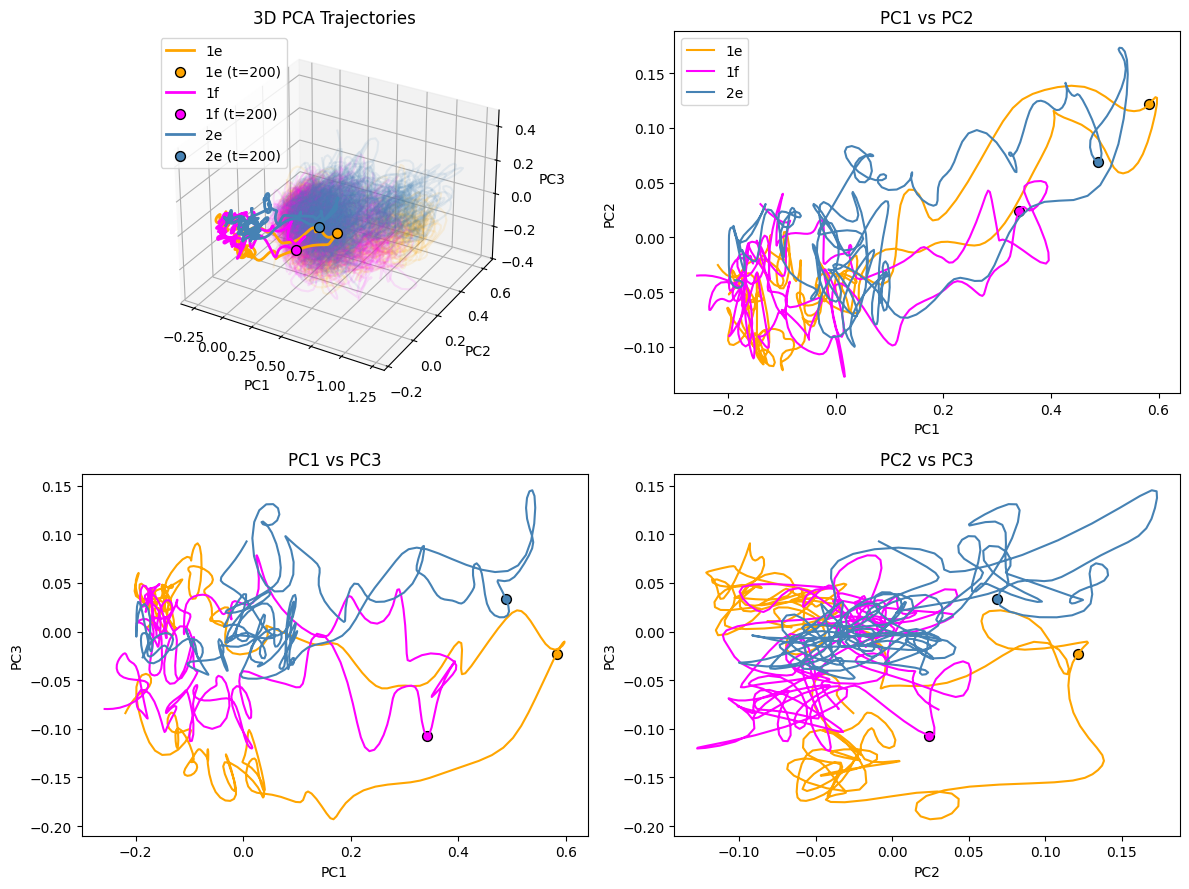

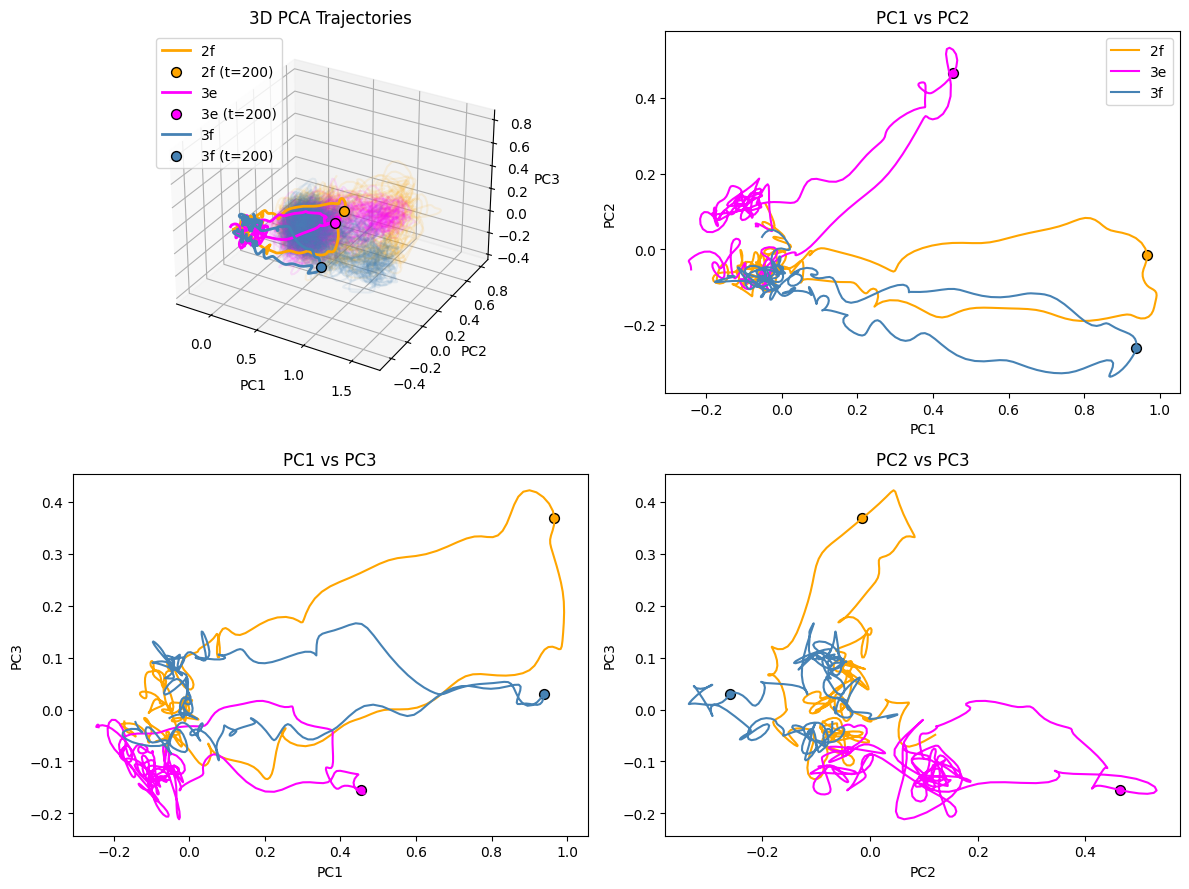

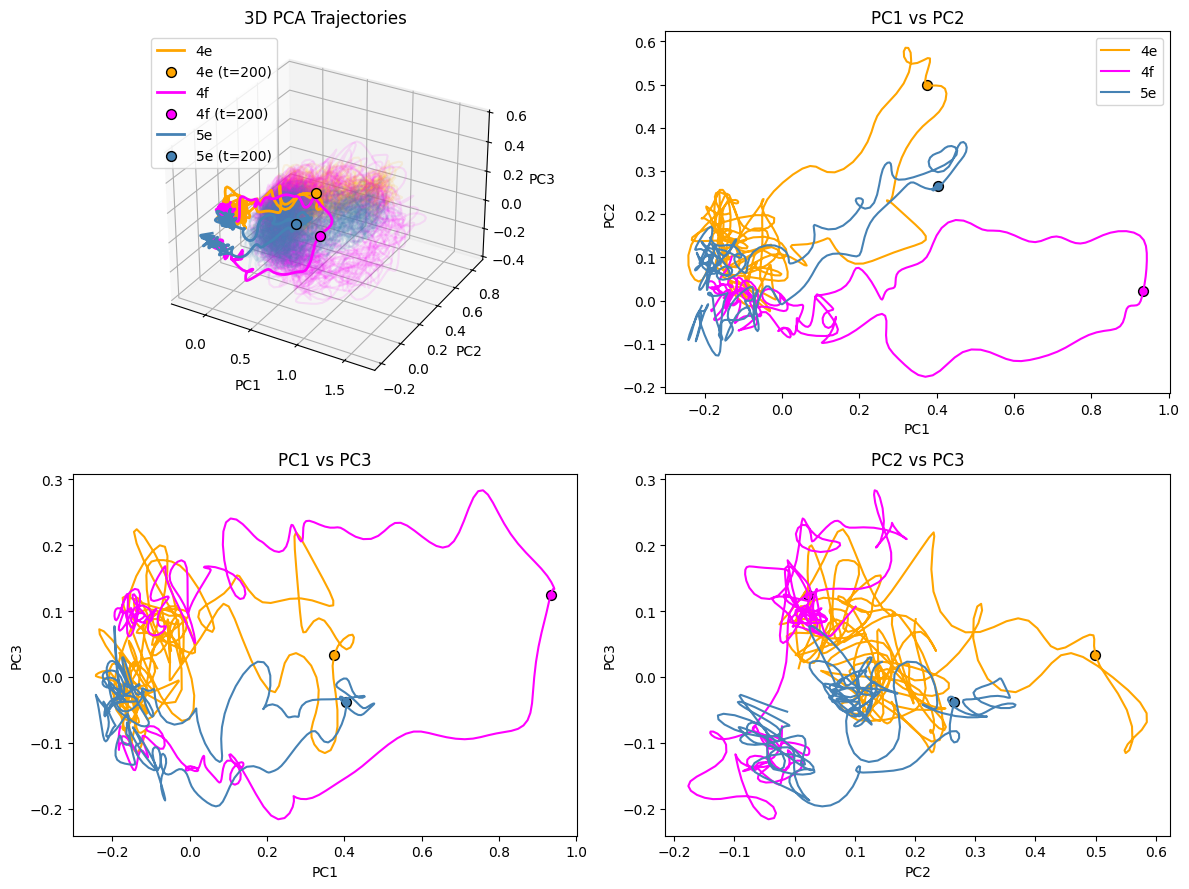

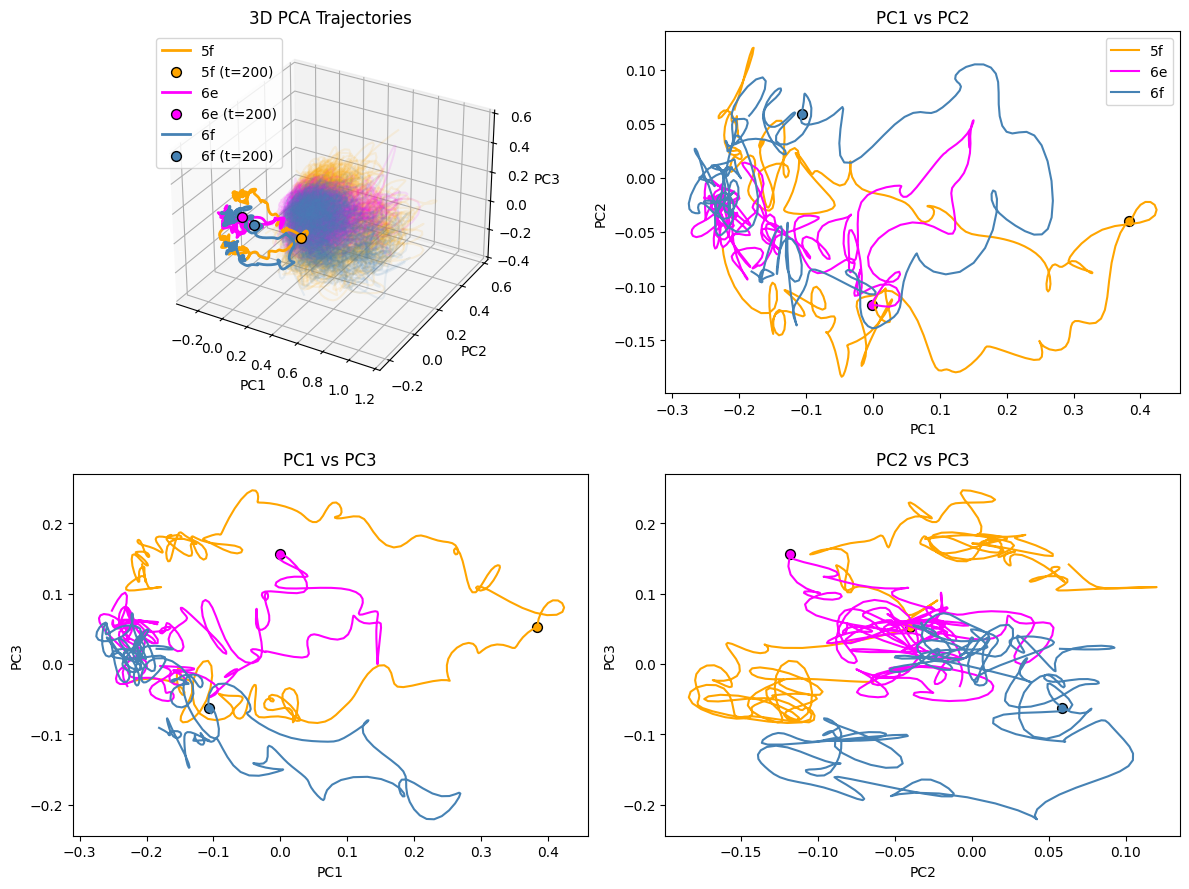

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D
import pyvista as pv
import matplotlib.animation as animation

# === Load data ===
base_path = r"E:\OneDrive - Technion\Documents\000PhD\research\neural_networks\synthetic_multi_neuron_data_Chip\train"
X = np.load(base_path + r"\X_long.npy")  # [trials, neurons, time]
y = np.load(base_path + r"\y_long.npy")  # [trials]
with open(base_path + r"\movements.txt", 'r') as f:
    movement_names = [line.strip() for line in f.readlines()]

# cut the edges of each trial to remove the time before and after the movement  $$$$
X = X[:, :, 300:800]  # [trials, neurons, time]
n_movements = len(np.unique(y))
n_time = X.shape[2]
n_neurons = X.shape[1]

# === Compute mean trajectory and per-trial smoothed PCA ===

X_all = X.reshape(X.shape[0], -1)  # flatten for PCA
X_centered = X_all - np.mean(X_all, axis=0)

pca = PCA(n_components=3)
X_pca_all = pca.fit_transform(X_centered)  # [n_trials, PC]
X_pca_trials = X_pca_all.reshape(X.shape[0], 3, -1)  # [n_trials, 3, time] later reshaped properly

# We want PCA of time course, so do PCA on [movement * time x neuron]
X_by_movement = np.array([X[y == i].mean(axis=0) for i in range(n_movements)])  # [movements, neurons, time]
X_timewise = X_by_movement.transpose(0, 2, 1).reshape(-1, n_neurons)  # [movements*time, neurons]
X_timewise_centered = X_timewise - np.mean(X_timewise, axis=0)
X_pca_timewise = pca.fit_transform(X_timewise_centered)
X_pca_by_movement = X_pca_timewise.reshape(n_movements, n_time, 3)

# === Smoothing ===
X_pca_mean_smooth = np.zeros_like(X_pca_by_movement)
for i in range(n_movements):
    for dim in range(3):
        X_pca_mean_smooth[i, :, dim] = gaussian_filter1d(X_pca_by_movement[i, :, dim], sigma=3)
        # Update colors to match the new palette
        colors = ['orange', 'magenta', 'steelblue']

        # Ensure the number of colors matches the number of movements
        if len(colors) < n_movements:
            colors = colors * (n_movements // len(colors)) + colors[:n_movements % len(colors)]

# === Plot in batches of 3 movements ===

movements_per_fig = 3
for start_idx in range(0, n_movements, movements_per_fig):
    end_idx = min(start_idx + movements_per_fig, n_movements)

    fig = plt.figure(figsize=(12, 9))
    ax3d = fig.add_subplot(221, projection='3d')

    # === Plot smoothed trial trajectories (alpha = 0.1) ===
    for i in range(start_idx, end_idx):
        trial_indices = np.where(y == i)[0]
        for tidx in trial_indices:
            trial_data = X[tidx].T  # shape: [time, neurons]
            trial_pca = pca.transform(trial_data)  # [time, 3]
            trial_smooth = gaussian_filter1d(trial_pca, sigma=3, axis=0)
            ax3d.plot(trial_smooth[:, 0], trial_smooth[:, 1], trial_smooth[:, 2], color=colors[i], alpha=0.1)

    # === Plot smoothed mean trajectory (alpha = 1.0) ===
    for i in range(start_idx, end_idx):
        traj = X_pca_mean_smooth[i]
        ax3d.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=movement_names[i], color=colors[i], alpha=1.0, linewidth=2)
        # Add marker at t=500
        if 200 < traj.shape[0]:
            ax3d.scatter(traj[200, 0], traj[200, 1], traj[200, 2], color=colors[i], s=50, edgecolor='black', label=f'{movement_names[i]} (t=200)')

    ax3d.set_title("3D PCA Trajectories")
    ax3d.set_xlabel("PC1")
    ax3d.set_ylabel("PC2")
    ax3d.set_zlabel("PC3")
    ax3d.legend()

    # === 2D projections ===
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    for i in range(start_idx, end_idx):
        traj = X_pca_mean_smooth[i]
        ax2.plot(traj[:, 0], traj[:, 1], color=colors[i], alpha=1.0, label=movement_names[i])
        ax3.plot(traj[:, 0], traj[:, 2], color=colors[i], alpha=1.0)
        ax4.plot(traj[:, 1], traj[:, 2], color=colors[i], alpha=1.0)
        # Add marker at t=200 for 2D projections
        if 200 < traj.shape[0]:
            ax2.scatter(traj[200, 0], traj[200, 1], color=colors[i], s=50, edgecolor='black')
            ax3.scatter(traj[200, 0], traj[200, 2], color=colors[i], s=50, edgecolor='black')
            ax4.scatter(traj[200, 1], traj[200, 2], color=colors[i], s=50, edgecolor='black')

    ax2.set_title("PC1 vs PC2")
    ax2.set_xlabel("PC1"); ax2.set_ylabel("PC2"); ax2.legend()

    ax3.set_title("PC1 vs PC3")
    ax3.set_xlabel("PC1"); ax3.set_ylabel("PC3")

    ax4.set_title("PC2 vs PC3")
    ax4.set_xlabel("PC2"); ax4.set_ylabel("PC3")

    plt.tight_layout()
    plt.show()


    

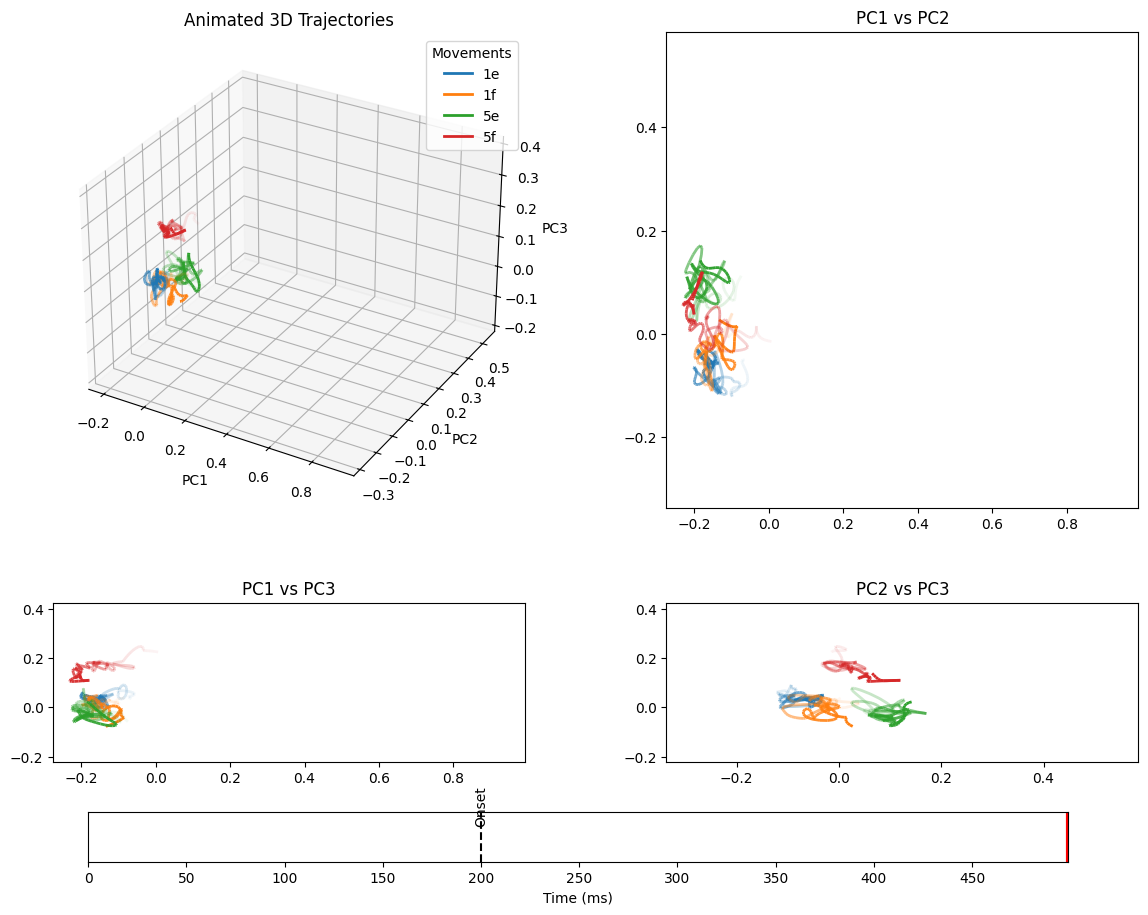

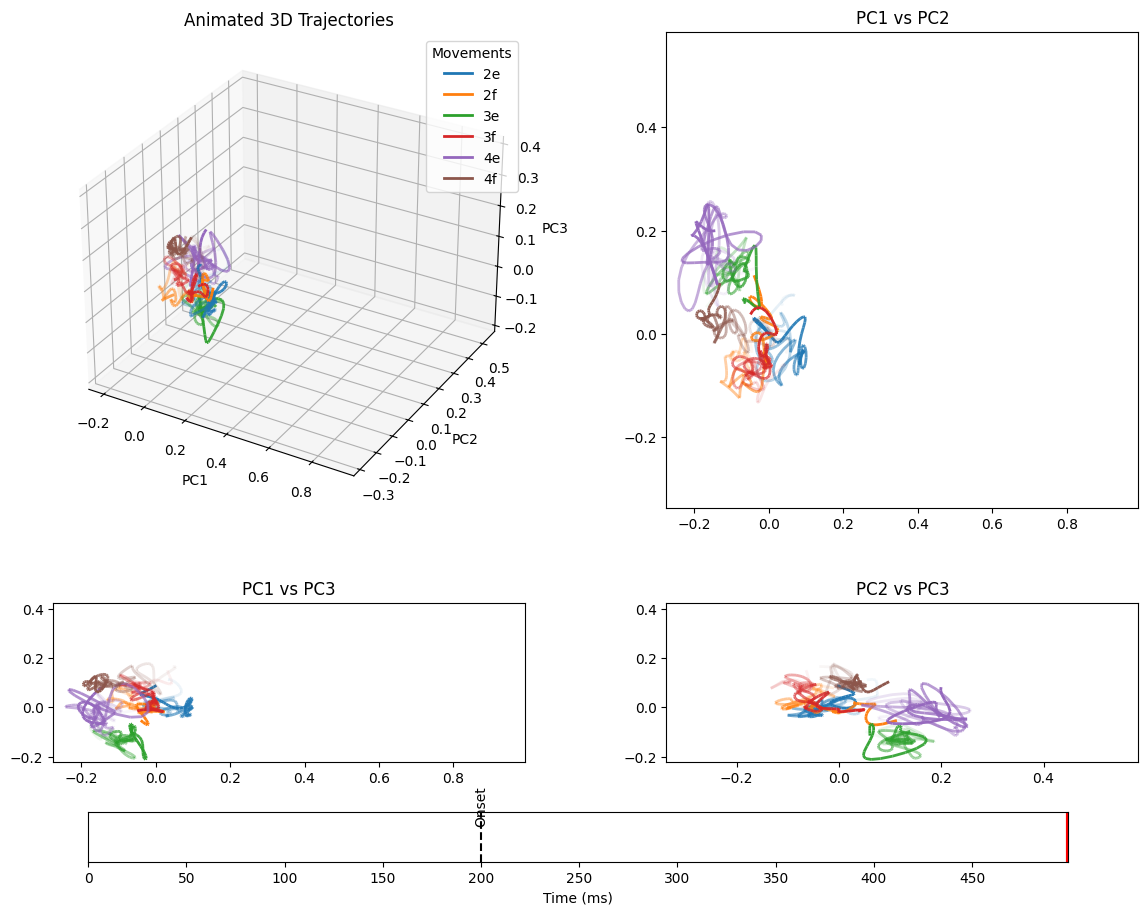

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import gridspec
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.lines import Line2D

# === Parameters ===
# 0 - 1f, 1 - 1e, 2 - 2f, 3 - 2e, 4 - 3f, 5 - 3e,
# 6 - 4f, 7 - 4e, 8 - 5f, 9 - 5e, 10 - 6f, 11 - 6e
dict_for_plotting = {"1f": 0, "1e": 1, "2f": 2, "2e": 3, "3f": 4, "3e": 5,
                     "4f": 6, "4e": 7, "5f": 8, "5e": 9, "6f": 10, "6e": 11}

# 1fe and 5fe
list_of_plots = [['1f', '1e','5f', '5e'], ['2f', '2e','3f', '3e', '4f', '4e']]
for plot_idx in range(len(list_of_plots)):
    plot_indices = [dict_for_plotting[i] for i in list_of_plots[plot_idx]]  # convert labels to indices
    fade_window_frames = int(0.4 * 500)  # 700ms fade window
    colors = ['orange', 'magenta', 'steelblue', 'green', 'red', 'purple']
    T = min([X_pca_mean_smooth[i].shape[0] for i in plot_indices])  # shortest movement length

    # === Prepare Figure ===
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[2, 2], hspace=0.3, wspace=0.3)

    # 3D plot
    ax3d = fig.add_subplot(gs[0, 0], projection='3d')
    ax3d.set_title("Animated 3D Trajectories")
    ax3d.set_xlabel("PC1")
    ax3d.set_ylabel("PC2")
    ax3d.set_zlabel("PC3")
    ax3d.set_xlim(np.min(X_pca_mean_smooth[:, :, 0]), np.max(X_pca_mean_smooth[:, :, 0]))
    ax3d.set_ylim(np.min(X_pca_mean_smooth[:, :, 1]), np.max(X_pca_mean_smooth[:, :, 1]))
    ax3d.set_zlim(np.min(X_pca_mean_smooth[:, :, 2]), np.max(X_pca_mean_smooth[:, :, 2]))
    legend_elements = [
        Line2D([0], [0], color=plt.colormaps['tab10'](i % 10), lw=2, label=movement_names[idx])
        for i, idx in enumerate(plot_indices)
    ]
    ax3d.legend(handles=legend_elements, title="Movements")

    # 2D projection axes
    ax_proj1 = fig.add_subplot(gs[0, 1])  # PC1 vs PC2
    ax_proj2 = fig.add_subplot(gs[1, 0])  # PC1 vs PC3
    ax_proj3 = fig.add_subplot(gs[1, 1])  # PC2 vs PC3
    for ax, (d1, d2) in zip([ax_proj1, ax_proj2, ax_proj3], [(0, 1), (0, 2), (1, 2)]):
        ax.set_xlim(np.min(X_pca_mean_smooth[:, :, d1]), np.max(X_pca_mean_smooth[:, :, d1]))
        ax.set_ylim(np.min(X_pca_mean_smooth[:, :, d2]), np.max(X_pca_mean_smooth[:, :, d2]))
    ax_proj1.set_title("PC1 vs PC2")
    ax_proj2.set_title("PC1 vs PC3")
    ax_proj3.set_title("PC2 vs PC3")

    # Time axis
    fig.subplots_adjust(bottom=0.15)
    ax_time = fig.add_axes([0.15, 0.05, 0.7, 0.05])
    time_ms = np.arange(T)   # 500 Hz → 2 ms per frame
    ax_time.set_xlim(time_ms[0], time_ms[-1])
    ax_time.set_ylim(0, 1)
    ax_time.set_yticks([])
    ax_time.set_xlabel("Time (ms)")
    tick_vals = np.arange(0, time_ms[-1] + 1, 50)
    ax_time.set_xticks(tick_vals)
    ax_time.set_xticklabels([f"{int(t)}" for t in tick_vals])
    progress_line = ax_time.axvline(x=0, color='red', lw=3)
    ax_time.axvline(x=200, color='black', linestyle='--', lw=1.5)
    ax_time.text(200, 0.7, "Onset", rotation=90, ha='center', va='bottom', fontsize=10)

    # === Storage for dynamic collections ===
    collections_3d = []
    collections_2d = [[], [], []]  # per axis: PC1-PC2, PC1-PC3, PC2-PC3

    # === Init function ===
    def init():
        # Remove all 3D collections
        for coll in collections_3d:
            try:
                coll.remove()
            except Exception:
                pass
        collections_3d.clear()

        # Remove all 2D collections
        for j in range(3):
            for coll in collections_2d[j]:
                try:
                    coll.remove()
                except Exception:
                    pass
            collections_2d[j].clear()

        # Reset progress bar
        progress_line.set_xdata([0])
        return [progress_line]

    # === Update function ===
    def update(frame):
        for i, idx in enumerate(plot_indices):
            traj = X_pca_mean_smooth[idx][:T]
            x, y, z = traj[:, 0], traj[:, 1], traj[:, 2]

            start_fade = max(0, frame - fade_window_frames)
            segment_indices = np.arange(start_fade, frame)
            if len(segment_indices) < 2:
                continue
            alphas = np.linspace(0.05, 1.0, len(segment_indices))

            # 3D fading line
            segments_3d = np.array([
                [[x[j], y[j], z[j]], [x[j+1], y[j+1], z[j+1]]] for j in segment_indices[:-1]
            ])
            color = plt.colormaps['tab10'](i % 10)
            colors_3d = np.array([[*color[:3], a] for a in alphas[:-1]])
            lc3d = Line3DCollection(segments_3d, colors=colors_3d, linewidths=2)

            if i < len(collections_3d):
                collections_3d[i].remove()
                collections_3d[i] = lc3d
            else:
                collections_3d.append(lc3d)
            ax3d.add_collection3d(lc3d)

            # 2D fading projections
            dims = [(x, y), (x, z), (y, z)]
            axs_proj = [ax_proj1, ax_proj2, ax_proj3]

            for j, (xv, yv) in enumerate(dims):
                segs = np.array([
                    [[xv[k], yv[k]], [xv[k+1], yv[k+1]]] for k in segment_indices[:-1]
                ])
                colors_2d = np.array([[*color[:3], a] for a in alphas[:-1]])
                lc = LineCollection(segs, colors=colors_2d, linewidths=2)

                if i < len(collections_2d[j]):
                    collections_2d[j][i].remove()
                    collections_2d[j][i] = lc
                else:
                    collections_2d[j].append(lc)
                axs_proj[j].add_collection(lc)

        t_ms = frame   # progress bar time
        progress_line.set_xdata([t_ms])
        return [progress_line]


    # === Animate ===
    ani = animation.FuncAnimation(
        fig, update, frames=range(1, T, 2), init_func=init, blit=False
    )

    # === Save ===
    ani.save(rf"E:\OneDrive - Technion\Documents\000PhD\research\Shared_Daniel_Firas\neural_networks\trajectory_animation_{str(plot_indices)}.gif", fps=30, dpi=100, writer='pillow')
    plt.show()


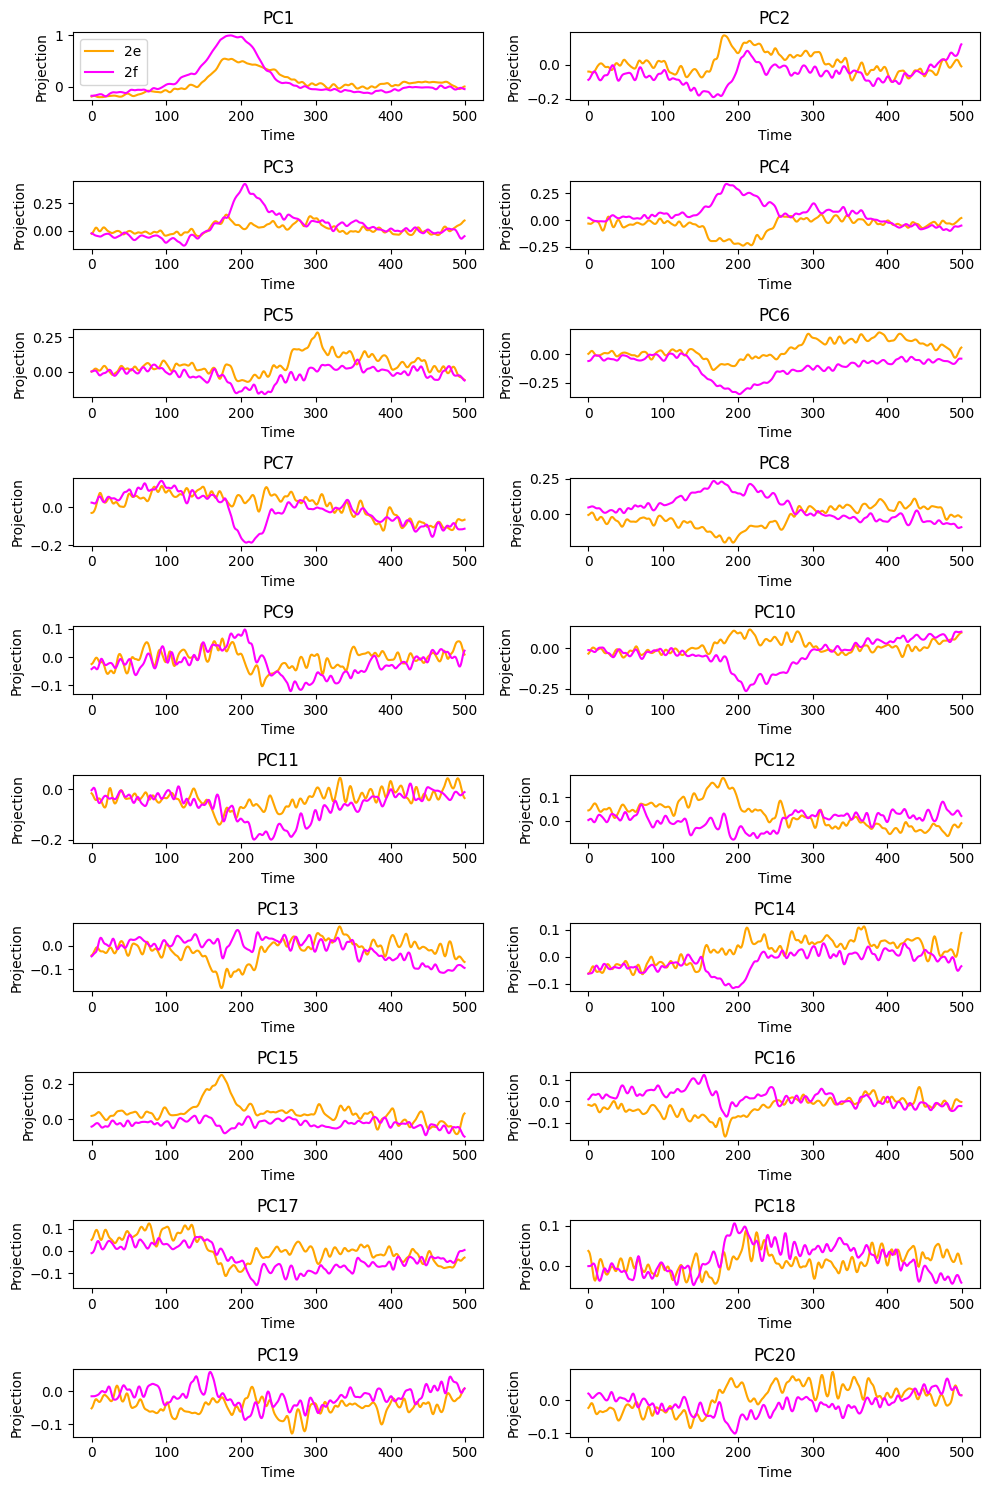

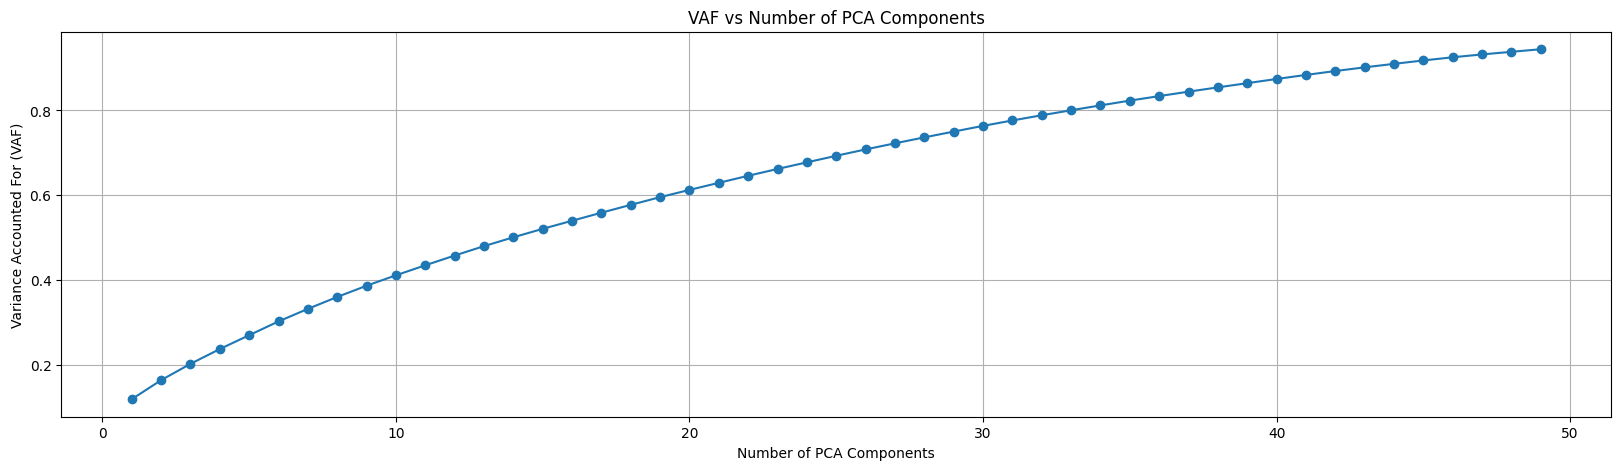

Minimum number of components for 0.61 VAF: 20
Minimum number of components for 0.63 VAF: 21
Minimum number of components for 0.65 VAF: 22
Minimum number of components for 0.66 VAF: 23
Minimum number of components for 0.68 VAF: 24
Minimum number of components for 0.69 VAF: 25
Minimum number of components for 0.71 VAF: 26
Minimum number of components for 0.72 VAF: 27
Minimum number of components for 0.74 VAF: 28
Minimum number of components for 0.75 VAF: 29
Minimum number of components for 0.76 VAF: 30
Minimum number of components for 0.78 VAF: 31
Minimum number of components for 0.79 VAF: 32
Minimum number of components for 0.80 VAF: 33
Minimum number of components for 0.81 VAF: 34
Minimum number of components for 0.82 VAF: 35
Minimum number of components for 0.83 VAF: 36
Minimum number of components for 0.84 VAF: 37
Minimum number of components for 0.85 VAF: 38
Minimum number of components for 0.86 VAF: 39
Minimum number of components for 0.87 VAF: 40
Minimum number of components for 0

In [59]:
# === Re-run PCA with 20 components ===
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d

n_movements = len(np.unique(y))
n_time = X.shape[2]

X_by_movement = np.array([X[y == i].mean(axis=0) for i in range(n_movements)])  # [movements, neurons, time]
X_timewise = X_by_movement.transpose(0, 2, 1).reshape(-1, X.shape[1])  # [movements*time, neurons]
X_timewise_centered = X_timewise - np.mean(X_timewise, axis=0)

pca = PCA(n_components=20)
X_pca_timewise = pca.fit_transform(X_timewise_centered)
X_pca_by_movement = X_pca_timewise.reshape(n_movements, n_time, 20)

# Smooth
X_pca_mean_smooth = np.zeros_like(X_pca_by_movement)
for i in range(n_movements):
    for dim in range(20):
        X_pca_mean_smooth[i, :, dim] = gaussian_filter1d(X_pca_by_movement[i, :, dim], sigma=3)
import matplotlib.pyplot as plt

plot_indices = [2, 3]  # for example, '2e' and '2f'
colors = ['orange', 'magenta']
labels = [movement_names[i] for i in plot_indices]

T = X_pca_mean_smooth.shape[1]

fig, axs = plt.subplots(10, 2, figsize=(10, 15))
axs = axs.flatten()

time = np.arange(T)

for pc_idx in range(20):
    ax = axs[pc_idx]
    for i, idx in enumerate(plot_indices):
        ax.plot(time, X_pca_mean_smooth[idx, :, pc_idx], color=colors[i], label=labels[i])
    ax.set_title(f"PC{pc_idx + 1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Projection")
    if pc_idx == 0:
        ax.legend()

plt.tight_layout()
plt.show()


# make a vaf plot and find the best number of components
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Compute VAF (Variance Accounted For) for different numbers of PCA components
components_range = range(1, 50)
vaf = []
for n in components_range:
    pca_temp = PCA(n_components=n)
    pca_temp.fit(X_timewise_centered)
    # Sum of explained variance ratios is our VAF
    vaf.append(np.sum(pca_temp.explained_variance_ratio_))

# Plot the VAF curve
plt.figure(figsize=(20, 5))
plt.plot(components_range, vaf, marker='o', linestyle='-')
plt.xlabel('Number of PCA Components')
plt.ylabel('Variance Accounted For (VAF)')
plt.title('VAF vs Number of PCA Components')
plt.grid(True)
plt.show()

# Optionally, print the smallest number of components reaching ≥90% VAF
for n, value in zip(components_range, vaf):
    if value >= 0.6:
        print(f"Minimum number of components for {value:.2f} VAF: {n}")
        

# J-PCA


C:\Users\danielkatz\AppData\Local\Temp\ipykernel_14832\58865640.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


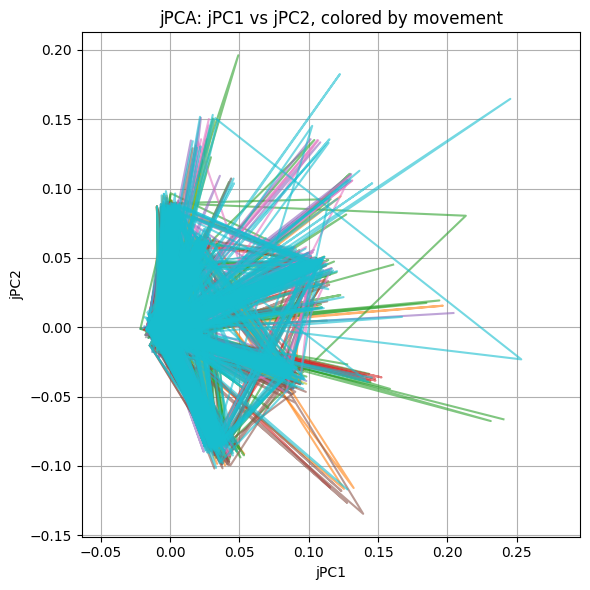

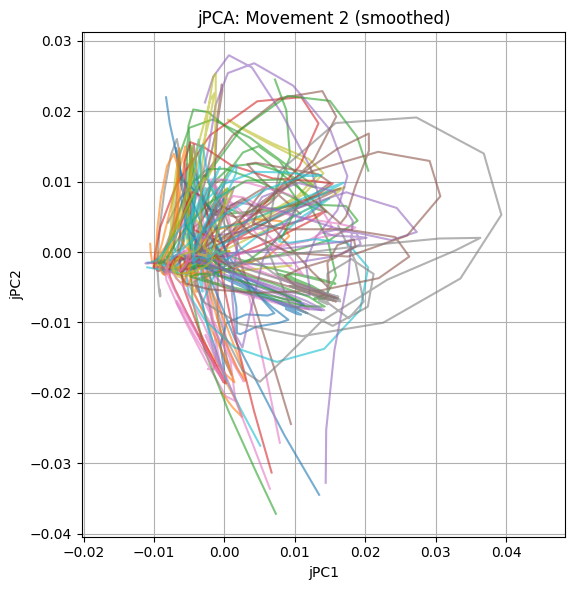

In [85]:
import os
import numpy as np
import jPCA
from jPCA.util import plot_projections


# Paths
data_path = r"E:\OneDrive - Technion\Documents\000PhD\research\neural_networks\synthetic_multi_neuron_data"
X = np.load(os.path.join(data_path, "X_long.npy"))  # shape: [trials, neurons, time]
y = np.load(os.path.join(data_path, "y_long.npy"))  # shape: [trials]
# Use float time points for each bin

datas = [X[i].T.astype(np.float32) for i in range(X.shape[0])]
X = X[:, :, 450:550]  # [trials, neurons, time]
bin_hz = 500
duration = X.shape[2] / bin_hz
times = list(np.linspace(0, duration, X.shape[2]))

tstart = times[0]
tend = times[-1]

jpca = jPCA.JPCA(num_jpcs=2)
projected, full_data_var, pca_var_capt, jpca_var_capt = jpca.fit(
    datas,
    times=times,
    tstart=tstart,
    tend=tend
)

import matplotlib.pyplot as plt
import numpy as np

# `projected` is a list of np.ndarrays [time, jPCs] for each trial
# `y` contains the movement label per trial

unique_labels = np.unique(y)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

plt.figure(figsize=(6, 6))
for i, trial in enumerate(projected):
    label = y[i]
    plt.plot(trial[:, 0], trial[:, 1], color=colors(label), alpha=0.6)

plt.title("jPCA: jPC1 vs jPC2, colored by movement")
plt.xlabel("jPC1")
plt.ylabel("jPC2")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np

# === Settings ===
movement_idx = 2  # choose a single movement label
smoothing_sigma = 2  # adjust for more or less smoothing

# === Filter and smooth ===
filtered_trials = [gaussian_filter1d(projected[i], sigma=smoothing_sigma, axis=0)
                   for i in range(len(projected)) if y[i] == movement_idx]

# === Plot ===
plt.figure(figsize=(6, 6))
for trial in filtered_trials:
    plt.plot(trial[:, 0], trial[:, 1], alpha=0.6)

plt.title(f"jPCA: Movement {movement_idx} (smoothed)")
plt.xlabel("jPC1")
plt.ylabel("jPC2")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()


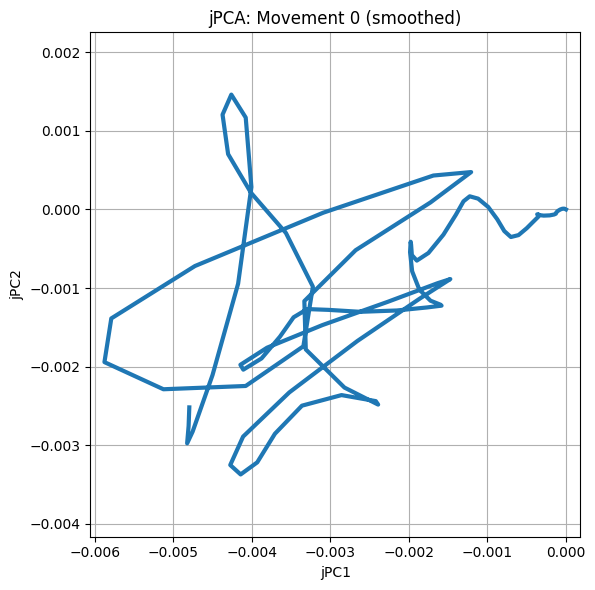

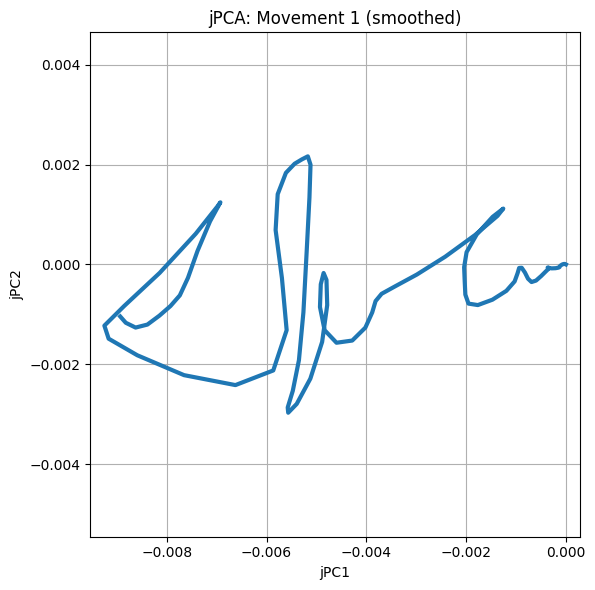

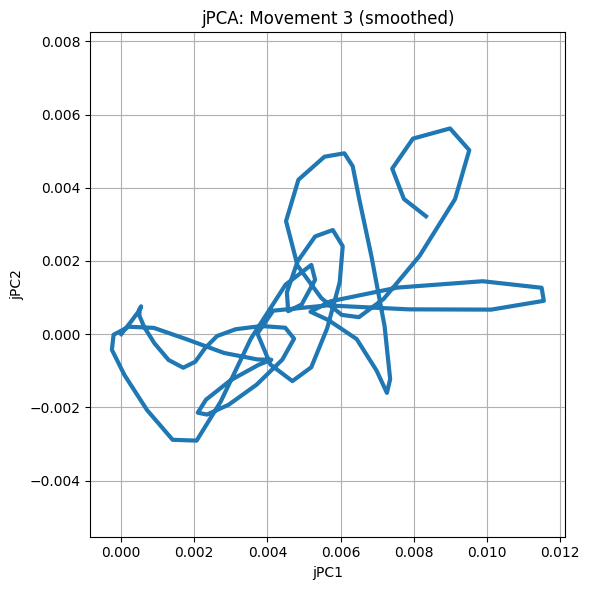

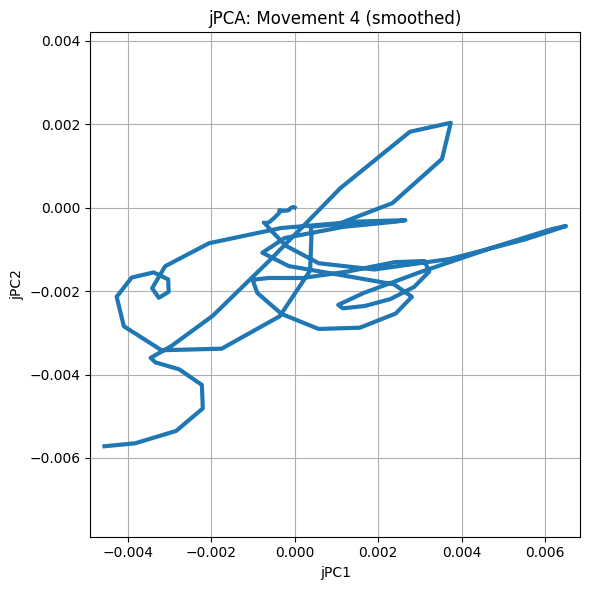

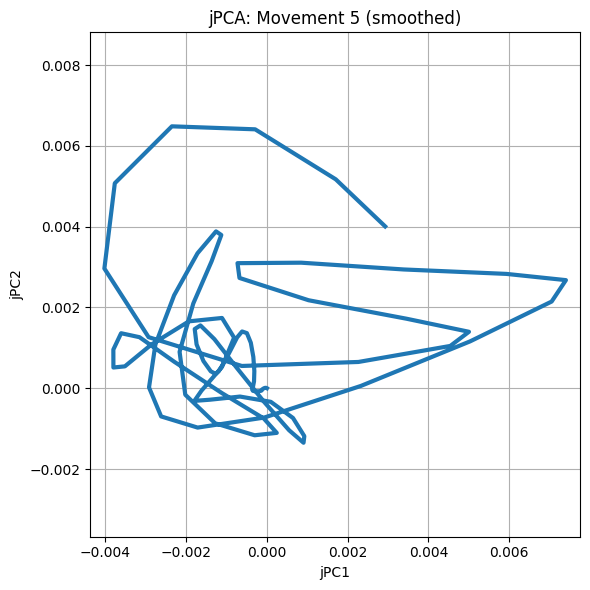

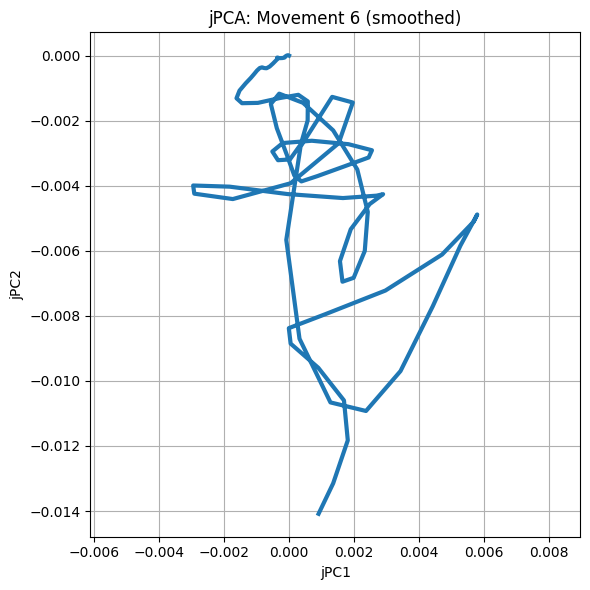

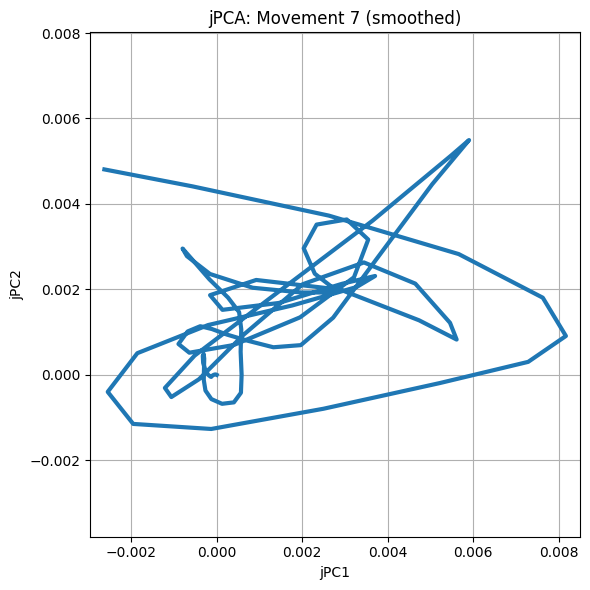

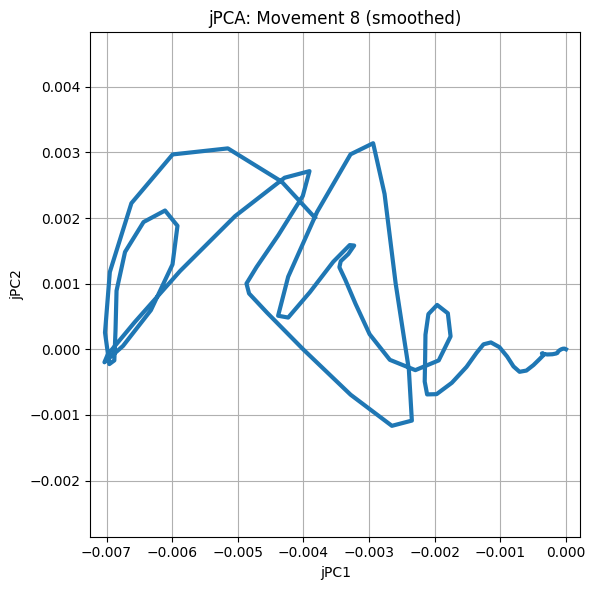

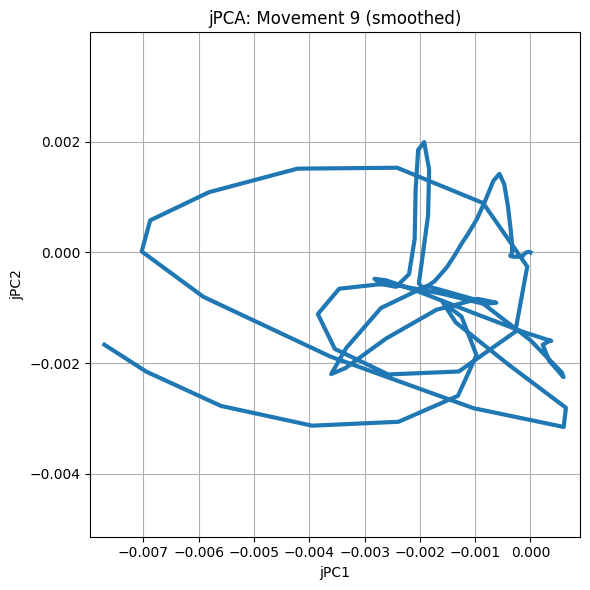

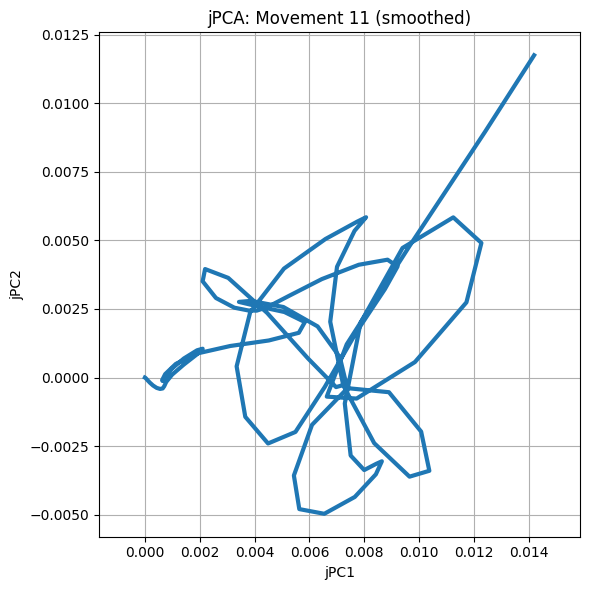

In [86]:
# === Loop through each movement ===
for movement_idx in np.unique(y):  # Loop through unique movement labels
    smoothing_sigma = 2  # Adjust for more or less smoothing

    # === Filter and smooth ===
    filtered_trials = [gaussian_filter1d(projected[i], sigma=smoothing_sigma, axis=0)
                       for i in range(len(projected)) if y[i] == movement_idx]

    # === Plot ===
    plt.figure(figsize=(6, 6))
    mean_traj = np.mean(filtered_trials, axis=0)
    plt.plot(mean_traj[:, 0], mean_traj[:, 1], lw=3)

    plt.title(f"jPCA: Movement {movement_idx} (smoothed)")
    plt.xlabel("jPC1")
    plt.ylabel("jPC2")
    plt.axis("equal")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
import os
import pickle
import numpy as np
from collections import defaultdict
from tqdm import tqdm

# === STEP 1: Index Trials ===
def index_trials(base_path):
    trial_index = defaultdict(list)

    for movement in tqdm(os.listdir(base_path), desc="Indexing movements"):
        movement_path = os.path.join(base_path, movement)
        for file in os.listdir(movement_path):
            if file.endswith('_spikes.pkl'):
                base = file.replace('_spikes.pkl', '')
                split_idx = base.rfind('_')
                if split_idx == -1:
                    continue
                neuron = base[:split_idx]
                trial_idx_str = base[split_idx+1:]
                try:
                    trial_idx = int(trial_idx_str)
                except ValueError:
                    continue

                with open(os.path.join(movement_path, file), 'rb') as f:
                    data = pickle.load(f)
                    markers = data['markers']
                    onset = markers.get('onset_location')
                    start = markers.get('start_location')
                    if onset is None or start is None:
                        continue

                emg_files = {}
                for f_emg in os.listdir(movement_path):
                    if f_emg.startswith(f"{neuron}_{trial_idx}_emg_"):
                        muscle = f_emg.split('_emg_')[1].replace('.pkl', '')
                        emg_files[muscle] = os.path.join(movement_path, f_emg)

                traj_file = os.path.join(movement_path, f"{neuron}_{trial_idx}_fingers.pkl")
                if not os.path.exists(traj_file):
                    traj_file = None

                trial_index[movement].append({
                    "neuron": neuron,
                    "trial_idx": trial_idx,
                    "onset": onset,
                    "start": start,
                    "spike_file": os.path.join(movement_path, file),
                    "emg_files": emg_files,
                    "traj_file": traj_file
                })

    return trial_index


# === STEP 2: Find Shared Neurons ===
def get_neurons_with_complete_movements(trial_index, required_movements):
    movement_to_neurons = defaultdict(set)

    for movement in required_movements:
        for trial in trial_index.get(movement, []):
            movement_to_neurons[movement].add(trial['neuron'])

    common_neurons = set.intersection(*movement_to_neurons.values())
    return sorted(list(common_neurons))


# === STEP 3: Generate Synthetic Trials ===
def generate_synthetic_trials(trial_index, required_movements=None, timing_tolerance=0.03, bin_hz=500, duration=2.5):
    synthetic_dataset = []
    n_bins = int(bin_hz * duration)

    if required_movements is None:
        required_movements = list(trial_index.keys())

    shared_neurons = get_neurons_with_complete_movements(trial_index, required_movements)
    print(f"Found {len(shared_neurons)} shared neurons across all movements.")

    for movement in tqdm(required_movements, desc="Generating trials per movement"):
        trials = [t for t in trial_index[movement] if t['neuron'] in shared_neurons]
        print(f"  {movement}: {len(trials)} usable trials")

        for _ in range(100):
            base_trial = np.random.choice(trials)
            target_interval = base_trial['onset'] - base_trial['start']

            matching_trials = [
                t for t in trials
                if abs((t['onset'] - t['start']) - target_interval) < timing_tolerance
            ]

            matching_by_neuron = {}
            for t in matching_trials:
                if t['neuron'] not in matching_by_neuron:
                    matching_by_neuron[t['neuron']] = t

            if len(matching_by_neuron) < len(shared_neurons):
                continue

            selected = [matching_by_neuron[n] for n in shared_neurons if n in matching_by_neuron]

            X_spikes = []
            emg_by_muscle = defaultdict(list)
            traj_list = []

            for t in selected:
                with open(t['spike_file'], 'rb') as f:
                    data = pickle.load(f)
                    spikes = data['spikes']
                    spike_vector, _ = np.histogram(spikes, bins=n_bins, range=(0, duration))
                    X_spikes.append(spike_vector)

                for muscle, emg_path in t['emg_files'].items():
                    with open(emg_path, 'rb') as f:
                        emg_data = pickle.load(f)
                        emg_by_muscle[muscle].append(emg_data['emg'])

                if t['traj_file']:
                    with open(t['traj_file'], 'rb') as f:
                        traj_data = pickle.load(f)
                        traj = traj_data['trajectories']['v']
                        traj_list.append(traj)

            X = np.stack(X_spikes, axis=0)
            muscles = sorted(emg_by_muscle.keys())
            if not muscles:
                continue

            Y_emg = np.stack([np.mean(emg_by_muscle[m], axis=0) for m in muscles], axis=-1)
            Y_traj = np.mean(np.stack(traj_list), axis=0) if traj_list else None

            synthetic_dataset.append({
                'X_spikes': X,
                'Y_emg': Y_emg,
                'Y_fingers': Y_traj,
                'movement_label': movement,
                'muscles': muscles
            })

    return synthetic_dataset


# === STEP 4: Save Dataset ===
def save_dataset(synthetic_dataset, output_path):
    os.makedirs(output_path, exist_ok=True)
    for i, example in tqdm(enumerate(synthetic_dataset), desc="Saving trials", total=len(synthetic_dataset)):
        out_file = os.path.join(output_path, f"synthetic_trial_{i:04d}.pkl")
        with open(out_file, 'wb') as f:
            pickle.dump(example, f)


# === USAGE ===
if __name__ == '__main__':
    dataset_input_path = r"D:\\PhD\\neural_networks\\single_trial_dataset"
    dataset_output_path = r"D:\\PhD\\neural_networks\\synthetic_emg_data"
    os.makedirs(dataset_output_path, exist_ok=True)

    print("Indexing dataset...")
    trial_index = index_trials(dataset_input_path)

    print("Generating synthetic dataset...")
    synthetic_dataset = generate_synthetic_trials(trial_index)

    print(f"Saving {len(synthetic_dataset)} synthetic trials...")
    save_dataset(synthetic_dataset, dataset_output_path)


Indexing dataset...


Indexing movements:  17%|█▋        | 2/12 [04:35<22:57, 137.77s/it]


KeyboardInterrupt: 

In [25]:
import os
import pickle
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from scipy.signal import resample

# === STEP 1: Index Trials ===
def index_trials(base_path):
    trial_index = defaultdict(list)

    for movement in tqdm(os.listdir(base_path), desc="Indexing movements"):
        movement_path = os.path.join(base_path, movement)
        for file in os.listdir(movement_path):
            if file.endswith('_spikes.pkl'):
                base = file.replace('_spikes.pkl', '')
                split_idx = base.rfind('_')
                if split_idx == -1:
                    continue
                neuron = base[:split_idx]
                trial_idx_str = base[split_idx+1:]
                try:
                    trial_idx = int(trial_idx_str)
                except ValueError:
                    continue

                with open(os.path.join(movement_path, file), 'rb') as f:
                    data = pickle.load(f)
                    markers = data['markers']
                    onset = markers.get('onset_location')
                    start = markers.get('start_location')
                    if onset is None or start is None:
                        continue

                emg_files = {}
                for f_emg in os.listdir(movement_path):
                    if f_emg.startswith(f"{neuron}_{trial_idx}_emg_"):
                        muscle = f_emg.split('_emg_')[1].replace('.pkl', '')
                        emg_files[muscle] = os.path.join(movement_path, f_emg)

                traj_file = os.path.join(movement_path, f"{neuron}_{trial_idx}_fingers.pkl")
                if not os.path.exists(traj_file):
                    traj_file = None

                trial_index[movement].append({
                    "neuron": neuron,
                    "trial_idx": trial_idx,
                    "onset": onset,
                    "start": start,
                    "spike_file": os.path.join(movement_path, file),
                    "emg_files": emg_files,
                    "traj_file": traj_file
                })

    return trial_index


# === STEP 2: Find Shared Neurons ===
def get_neurons_with_complete_movements(trial_index, required_movements):
    movement_to_neurons = defaultdict(set)

    for movement in required_movements:
        for trial in trial_index.get(movement, []):
            movement_to_neurons[movement].add(trial['neuron'])

    common_neurons = set.intersection(*movement_to_neurons.values())
    return sorted(list(common_neurons))


# === STEP 3: Generate Synthetic Trials ===
def generate_synthetic_trials(trial_index, movement_sample_dict, timing_tolerance=0.1, bin_hz=500, duration=2.5):
    synthetic_dataset = []
    n_bins = int(bin_hz * duration)
    required_movements = list(movement_sample_dict.keys())

    all_shared_neurons = get_neurons_with_complete_movements(trial_index, required_movements)
    if len(all_shared_neurons) < 70:
        print(f"⚠️ Only {len(all_shared_neurons)} shared neurons found, using all of them.")
        shared_neurons = all_shared_neurons
    else:
        shared_neurons = sorted(np.random.choice(all_shared_neurons, size=70, replace=False).tolist())

    print(f"Using {len(shared_neurons)} neurons for this synthetic generation.")

    for movement in tqdm(required_movements, desc="Generating trials per movement"):
        trials = [t for t in trial_index[movement] if t['neuron'] in shared_neurons]
        n_samples = movement_sample_dict[movement]
        print(f"  {movement}: attempting to generate {n_samples} synthetic trials from {len(trials)} usable trials")

        for _ in range(n_samples):
            base_trial = np.random.choice(trials)
            target_interval = base_trial['onset'] - base_trial['start']

            matching_trials = [
                t for t in trials
                if abs((t['onset'] - t['start']) - target_interval) < timing_tolerance
            ]

            matching_by_neuron = {}
            for t in matching_trials:
                if t['neuron'] not in matching_by_neuron:
                    matching_by_neuron[t['neuron']] = t

            selected = [matching_by_neuron[n] for n in shared_neurons if n in matching_by_neuron]

            X_spikes = []
            emg_by_muscle = defaultdict(list)
            traj_list = []

            for t in selected:
                with open(t['spike_file'], 'rb') as f:
                    data = pickle.load(f)
                    spikes = data['spikes']
                    spike_vector, _ = np.histogram(spikes, bins=n_bins, range=(0, duration))
                    X_spikes.append(spike_vector)

                for muscle, emg_path in t['emg_files'].items():
                    with open(emg_path, 'rb') as f:
                        emg_data = pickle.load(f)
                        emg_signal = emg_data['emg']
                        resampled_emg = resample(emg_signal, n_bins)
                        emg_by_muscle[muscle].append(resampled_emg)

                if t['traj_file']:
                    with open(t['traj_file'], 'rb') as f:
                        traj_data = pickle.load(f)
                        traj = traj_data['trajectories']['v']
                        traj_list.append(traj)

            X = np.stack(X_spikes, axis=0)
            if X.shape[0] < 70:
                n_pad = 70 - X.shape[0]
                pad_indices = np.random.choice(range(70), size=n_pad, replace=False)
                padded_X = np.zeros((70, X.shape[1]), dtype=X.dtype)
                insert_indices = sorted(set(range(70)) - set(pad_indices))
                for i, idx in enumerate(insert_indices):
                    padded_X[idx] = X[i]
                X = padded_X

            muscles = sorted(emg_by_muscle.keys())
            if not muscles:
                print(f"⚠️ No EMG data for {movement} with shared neurons.")
                continue

            valid_emg_means = []
            valid_muscles = []

            for m in muscles:
                emgs = emg_by_muscle[m]
                mean_emg = np.mean(emgs, axis=0)
                valid_emg_means.append(mean_emg)
                valid_muscles.append(m)

            Y_emg = np.stack(valid_emg_means, axis=-1)
            muscles = valid_muscles

            Y_traj = np.mean(np.stack(traj_list), axis=0) if traj_list else None

            synthetic_dataset.append({
                'X_spikes': X,
                'Y_emg': Y_emg,
                'Y_fingers': Y_traj,
                'movement_label': movement,
                'muscles': muscles
            })

    return synthetic_dataset


# === STEP 4: Save Dataset ===
def save_dataset(synthetic_dataset, output_path):
    os.makedirs(output_path, exist_ok=True)
    for i, example in tqdm(enumerate(synthetic_dataset), desc="Saving trials", total=len(synthetic_dataset)):
        out_file = os.path.join(output_path, f"synthetic_trial_{i:04d}.pkl")
        with open(out_file, 'wb') as f:
            pickle.dump(example, f)


# === USAGE ===
if __name__ == '__main__':
    dataset_input_path = r"D:\\PhD\\neural_networks\\single_trial_dataset"
    dataset_output_path = r"D:\\PhD\\neural_networks\\synthetic_emg_data"
    os.makedirs(dataset_output_path, exist_ok=True)

    movement_sample_dict = {
        '1f': 80,
        '1e': 80,
    }

    # print("Indexing dataset...")
    # trial_index = index_trials(dataset_input_path)

    print("Generating synthetic dataset...")
    synthetic_dataset = generate_synthetic_trials(trial_index, movement_sample_dict, timing_tolerance=0.01)

    print(f"Saving {len(synthetic_dataset)} synthetic trials...")
    save_dataset(synthetic_dataset, dataset_output_path)


Generating synthetic dataset...
Using 70 neurons for this synthetic generation.


Generating trials per movement:   0%|          | 0/2 [00:00<?, ?it/s]

  1f: attempting to generate 80 synthetic trials from 1466 usable trials


Generating trials per movement:  50%|█████     | 1/2 [00:50<00:50, 50.47s/it]

  1e: attempting to generate 80 synthetic trials from 1549 usable trials


Generating trials per movement: 100%|██████████| 2/2 [02:11<00:00, 65.86s/it]


Saving 160 synthetic trials...


Saving trials: 100%|██████████| 160/160 [00:04<00:00, 35.87it/s]


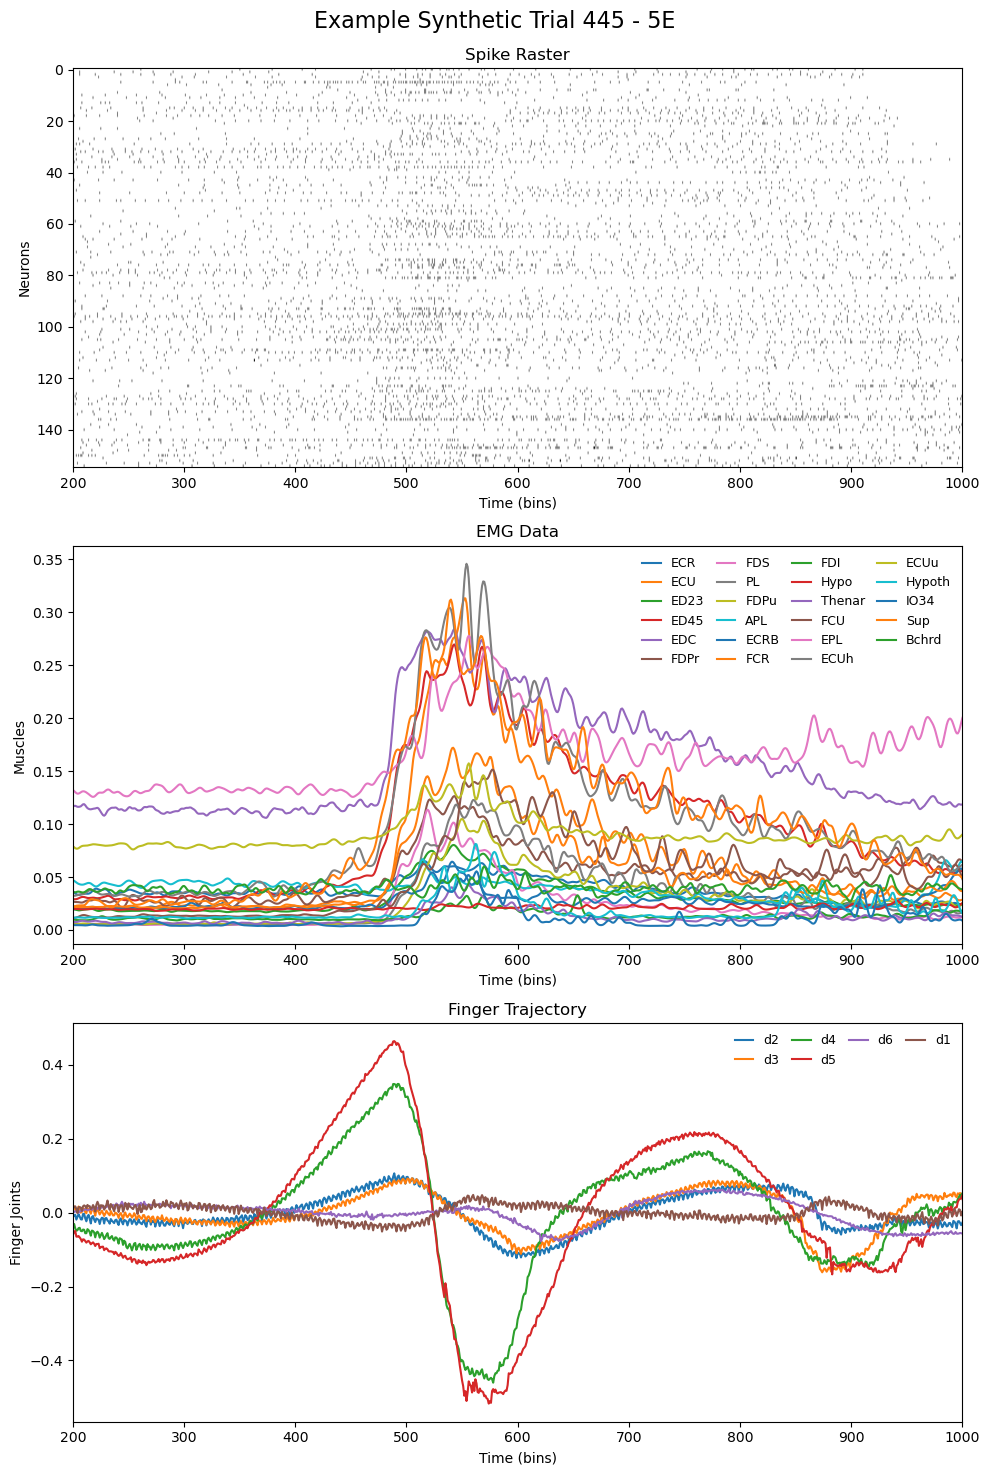

In [35]:
import os
import pickle   
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from scipy.signal import resample
from sklearn.decomposition import PCA
import pickle
from scipy.ndimage import gaussian_filter1d

# show an example of the synthetic data
# Load an example synthetic trial
x =  r"dataset\Chip\train\X_long.npy"
y_emg = r"dataset\Chip\train\y_emg_dict.pkl"
y_finger = r"dataset\Chip\train\y_fingers_dict.pkl"
y_movement = r"dataset\Chip\train\y_long.npy"

# load eahch file
X = np.load(x)
with open(y_emg, 'rb') as f:
    y_emg_dict = pickle.load(f)
with open(y_finger, 'rb') as f:
    y_fingers_dict = pickle.load(f)
y = np.load(y_movement)

index  = 445

# plot 3 subplots with the 3 different data
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs[0].imshow(X[index], aspect='auto', cmap='gray_r')
axs[0].set_title("Spike Raster")
axs[0].set_xlabel("Time (bins)")
axs[0].set_ylabel("Neurons")

# plot the EMG data
emg_data = y_emg_dict[index]
for key, value in emg_data.items():
    emg_data[key] = np.array(value)
    axs[1].plot(emg_data[key], label=key)
# Horizontal legend, 2 rows for EMG
axs[1].legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=4, fontsize=9, frameon=False, handlelength=1.5, columnspacing=1)
axs[1].set_title("EMG Data")
axs[1].set_xlabel("Time (bins)")
axs[1].set_ylabel("Muscles")

# plot the finger trajectory
finger_data = y_fingers_dict[index]
for key, value in finger_data.items():
    finger_data[key] = np.array(value)
    axs[2].plot(finger_data[key], label=key)
# Horizontal legend for finger trajectory
axs[2].legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=4, fontsize=9, frameon=False, handlelength=1.5, columnspacing=1)
axs[2].set_title("Finger Trajectory")
axs[2].set_xlabel("Time (bins)")
axs[2].set_ylabel("Finger Joints")

# set all xlims to 200:1000
for ax in axs:
    ax.set_xlim(200, 1000)
plt.suptitle(f"Example Synthetic Trial {index} - 5E", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])

plt.show()






In [6]:
y_fingers_dict[0]
y_emg_dict[0]

{'ECR': array([0.06406747, 0.06370203, 0.06278948, ..., 0.04355475, 0.04457387,
        0.04497134]),
 'ECU': array([0.01840994, 0.01860025, 0.01913138, ..., 0.01386618, 0.0141991 ,
        0.0143133 ]),
 'ED23': array([0.03803285, 0.03789712, 0.03756677, ..., 0.02532688, 0.02524694,
        0.02520979]),
 'ED45': array([0.04662192, 0.04666429, 0.04675723, ..., 0.0308357 , 0.03084361,
        0.03084583]),
 'EDC': array([0.14211418, 0.14254431, 0.14318731, ..., 0.11877284, 0.11712278,
        0.11623954]),
 'FDPr': array([0.0278164 , 0.02769386, 0.02744332, ..., 0.02267348, 0.02280829,
        0.02287505]),
 'FDS': array([0.00431815, 0.00431684, 0.0043129 , ..., 0.00408228, 0.00406436,
        0.00405718]),
 'PL': array([0.00594655, 0.00591645, 0.00583992, ..., 0.0050754 , 0.00507036,
        0.00506811]),
 'FDPu': array([0.00638685, 0.00638095, 0.0063678 , ..., 0.00688761, 0.00695429,
        0.00698086]),
 'APL': array([0.03750048, 0.03756334, 0.03774074, ..., 0.02228353, 0.02246428,